In [6]:
import networkx as nx
import random
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15,7]

In [7]:
g = nx.read_edgelist("complete_networld_cap.edgelist", create_using = nx.DiGraph())

In [8]:
def random_walk(g):
    edge_count = {}
    for i in range(5000):
        start = str(np.random.randint(1,12982))
        status = True
        while status == True:
            for j in range(1,9):
                node_neighbors = list(g.neighbors(start))
                if len(node_neighbors) != 0:
                    N = random.choice(list(g.neighbors(start)))
                    pair = start + ' ' + N

                    try: 
                        edge_count[pair] += 1
                    except KeyError as e:
                        edge_count[pair] = 1   
                    start = N

                else:
                    status = False
            status = False 
    return edge_count
            

In [9]:
def avg_list(alist):
    avg_list = [sum(elem)/len(elem) for elem in zip(*alist)]
    
    return avg_list

In [97]:
def res_test(edgelist, runs, redistribute):
    
    avg_weak_comp_list, avg_strong_comp_list, avg_total_comp_list, avg_edge_percentage_value_list = [], [], [], []
    
    for run in range(runs):
        print("Run: ", run+1)
    
        g = nx.read_edgelist(edgelist, create_using = nx.DiGraph())
        
        if redistribute:
            g_edge_cap = nx.get_edge_attributes(g,'capacity')
            g_edge_cars = nx.get_edge_attributes(g,'cars')
        
        edge_count = random_walk(g)
        ordered_edges = sorted(edge_count, key=edge_count.get, reverse=True)
        
        comp_count, weakly_comp_count, strongly_comp_count, edge_percentage = [], [], [], []
        weakly_comp_count.append(nx.number_weakly_connected_components(g))
        strongly_comp_count.append(nx.number_strongly_connected_components(g))
        comp_count.append(weakly_comp_count[0] + strongly_comp_count[0])
        edge_percentage.append(0/len(g.edges())*100)
        total_edge_count = len(g.edges())

        for index, elem in enumerate(ordered_edges):
            elem = elem.split(' ')
            start_node = elem[0]
            end_node = elem[1]
            
            if g.has_edge(start_node, end_node):
                g.remove_edge(start_node,end_node)
            
            if redistribute:
                cars = g_edge_cars[start_node,end_node]
                start_node_neighbors = g.successors(start_node)
                neighbors_w_path = {}

                for successor in start_node_neighbors:
                    have_path = nx.has_path(g, successor, end_node)
                    if have_path:
                        neighbors_w_path[successor] = start_node, successor
                        #print(neighbors_w_path[successor])
                        #print(neighbors_w_path[successor][1])
                    else:
                        continue

                if len(neighbors_w_path) != 0:
                    cars_frac = cars/len(neighbors_w_path)
                    fail_set = set()
                    redistribute_cars(g,start_node, cars_frac, neighbors_w_path,g_edge_cars, g_edge_cap, fail_set)

                else:
                    print("Fail Option 1")

            
            if index % 100 == 0:

                weakly_comp = nx.number_weakly_connected_components(g)
                strongly_comp = nx.number_strongly_connected_components(g)

                comp_count.append(weakly_comp + strongly_comp)
                weakly_comp_count.append(weakly_comp)
                strongly_comp_count.append(strongly_comp)

                edge_percentage_value = index/total_edge_count * 100
                edge_percentage.append(edge_percentage_value)

        avg_weak_comp_list.append(weakly_comp_count)
        avg_strong_comp_list.append(strongly_comp_count)
        avg_total_comp_list.append(comp_count)
        avg_edge_percentage_value_list.append(edge_percentage)

    final_weak = avg_list(avg_weak_comp_list)
    final_strong =  avg_list(avg_strong_comp_list)
    final_total = avg_list(avg_total_comp_list)
    final_percentage = avg_list(avg_edge_percentage_value_list)

    plt.plot(final_percentage, final_weak, label="weak")
    plt.plot(final_percentage, final_strong, label="strong")
    plt.plot(final_percentage, final_total, label="total")
    plt.xlabel('Edge Removal Percentage')
    plt.ylabel('Number of Components')
    plt.legend()

In [98]:
def redistribute_cars(g,start_node, cars_frac, neighbor_w_path, g_edge_cars, g_edge_cap, fail_set):
    for successor in neighbor_w_path:
        end_node = neighbor_w_path[successor][1]
        if g_edge_cars[start_node, end_node] + cars_frac > g_edge_cap[start_node,end_node]:
            if successor in fail_set:
                continue
            else:
                fail_set.add(successor)
                
                if len(fail_set) != len(neighbor_w_path):
                    extra_cars = cars_frac/(len(neighbor_w_path)-len(fail_set))
                    print(start_node, extra_cars, neighbor_w_path, end_node, fail_set)
                    print(g_edge_cap[start_node, end_node])
                    print(g_edge_cars[start_node, end_node])
                    g.remove_edge(start_node,end_node)
                    redistribute_cars(g,start_node, extra_cars, neighbor_w_path, g_edge_cars, g_edge_cap, fail_set)
                else:
                    print("Fail Option 2")
        else:
            g_edge_cars[start_node,end_node] += cars_frac

Run:  1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5828 600.0 {'5826': ('5828', '5826'), '5829': ('5828', '5829')} 5829 {'5829'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
10667 700.0 {'10669': ('10667', '10669'), '10470': ('10667', '10470')} 10470 {'10470'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
7749 600.0 {'7787': ('7749', '7787'), '7712': ('7749', '7712')} 7787 {'7787

Fail Option 1
Fail Option 2
10675 600.0 {'10676': ('10675', '10676'), '184': ('10675', '184')} 10676 {'10676'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11474 700.0 {'11475': ('11474', '11475'), '489': ('11474', '489')} 489 {'489'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6813 600.0 {'6710': ('6813', '6710'), '6973': (

2757 700.0 {'2752': ('2757', '2752'), '2607': ('2757', '2607')} 2752 {'2752'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8346 600.0 {'8341': ('8346', '8341'), '8348': ('8346', '8348')} 8348 {'8348'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
6311 800.0 {'6286': ('6311', '6286'), '535': ('6311', '535')} 535 {'535'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
873 233.33333333333334 {'12920': ('873', '12920'), '373': ('873', '373'), '12352': ('873', '12352')} 12920 {'12920'}
600.0
300.0
873 466.6666666666667 {'12920': ('873', '12920'), '373': ('873', '373'), '12352': ('873', '12352')} 373 {'12920', '373'}
900.0
68

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
548 43.6 {'6322': ('548', '6322'), '556': ('548', '556'), '546': ('548', '546'), '88': ('548', '88'), '6324': ('548', '6324')} 556 {'556'}
600.0
518.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4000 600.0 {'4033': ('4000', '4033'), '3998': ('4000', '3998')} 3998 {'3998'}
900.0
450.0
11513 600.0 {'11507': ('11513', '11507'), '11504': ('11513', '11504')} 11504 {'11504'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8414 700.0 {'8360': ('8414', '8360'), '424': ('8414', '424')} 424 {'424'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fai

618 43.6 {'3788': ('618', '3788'), '552': ('618', '552'), '623': ('618', '623'), '616': ('618', '616'), '3789': ('618', '3789')} 623 {'623'}
600.0
518.0
Fail Option 1
10290 218.75 {'50': ('10290', '50'), '10292': ('10290', '10292'), '3376': ('10290', '3376')} 3376 {'3376'}
900.0
562.5
10290 218.75 {'50': ('10290', '50'), '10292': ('10290', '10292'), '3376': ('10290', '3376')} 50 {'50', '3376'}
1309
1204.0
Fail Option 1
Fail Option 2
6480 700.0 {'6209': ('6480', '6209'), '6475': ('6480', '6475')} 6209 {'6209'}
600.0
300.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
12404 700.0 {'3896': ('12404', '3896'), '186': ('12404', '186')} 186 {'186'}
1309
654
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
683 636.0 {'4962': ('683', '4962'), '4790': ('683', '4790')} 4962 {'4962'}
1309
1272.0
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 2
10134 402.0 {'10131'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12583 700.0 {'12637': ('12583', '12637'), '107': ('12583', '107')} 107 {'107'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
5436 600.0 {'5437': ('5436', '5437'), '4127': ('5436', '4127')} 5437 {'5437'}
900.0
45

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
11713 600.0 {'11698': ('11713', '11698'), '11715': ('11713', '11715')} 11698 {'11698'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
8406 334.0 {'8404': ('8406', '8404'), '9356': ('8406', '9356')} 8404 {'8404'}
600.0
518.0
Fail Option 2
Fail Option 1
Fail Option 1
5711 402.0 {'994': ('5711', '994'), '5698': ('5711', '5698')} 994 {'994'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3981 600.0 {'3977': ('3981', '3977'), '3978': ('3981', '3978')} 3977 {'3977'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10793 200.0 {'10787': ('10793', '10787'), '10458': ('10793', '10458'), '175': ('10793', '175')} 10458 {'10458'}
600.0
300.0
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11

Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12845 1500.0 {'218': ('12845', '218'), '12851': ('12845', '12851')} 218 {'218'}
1309
654
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
410 69.2 {'7548': ('410', '7548'), '453': ('410', '453'), '10013': ('410', '10013'), '10006': ('410', '10006'), '10009': ('410', '10009')} 453 {'453'}
900.0
634.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail O

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
3959 334.0 {'3954': ('3959', '3954'), '317': ('3959', '317')} 3954 {'3954'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5356 709.0 {'676': ('5356', '676'), '674': ('5356', '674')} 676 {'676'}
1309
872.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
877

Fail Option 2
Fail Option 1
11280 327.0 {'1082': ('11280', '1082'), '11825': ('11280', '11825')} 11825 {'11825'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
640 186.25 {'4803': ('640', '4803'), '4801': ('640', '4801'), '4805': ('640', '4805')} 4803 {'4803'}
1309
1117.5
640 372.5 {'4803': ('640', '4803'), '4801': ('640', '4801'), '4805': ('640', '4805')} 4801 {'4803', '4801'}
1309
1303.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
186 28.55449735449735 {'28': ('186', '28'), '172': ('186', '172'), '189': ('186', '189'), '171': ('186', '171'), '11': ('186', '11'), '12408': ('186', '12408')} 189 {'189'}
900.0
856.6349206349206
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
251 24.982142857142858 {'8522': ('251', '8522'), '7771': ('251', '7771'), '7783': ('251', '7783'), '165': ('251', '165'), '84': ('251', '84'), '80': ('251', '80'), '26': ('251', '26')} 84 {'84'}
900.0
845.25
251 29.978571428571428 {'8522': ('251', '8522'), '7771': ('251', '7771'), '7783': ('251', '7783'), '165': ('251', '165'), '84': ('251', '84'), '80': ('251', '80'), '26': ('251', '26')} 80 {'84', '80'}
900.0
870.2321428571429
Fail Option 1
659 161.79999999999998 {'5165': ('659', '5165'), '5316': ('659', '5316'), '4683': ('659', '4683'), '9': ('659', '9')} 5165 {'5165'}


Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
9496 600.0 {'9376': ('9496', '9376'), '9492': ('9496', '9492')} 9492 {'9492'}
600.0
300.0
Fail Option 1
810 48.11666666666667 {'6575': ('810', '6575'), '6576': ('810', '6576'), '5601': ('810', '5601'), '811': ('810', '811'), '5602': ('810', '5602')} 811 {'811'}
900.0
758.3333333333334
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1


Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
87 10.19320987654321 {'7': ('87', '7'), '11998': ('87', '11998'), '86': ('87', '86'), '11993': ('87', '11993'), '925': ('87', '925'), '108': ('87', '108'), '223': ('87', '223'), '89': ('87', '89'), '12004': ('87', '12004'), '924': ('87', '924')} 86 {'86'}
600.0
563.3888888888889
87 11.467361111111112 {'7': ('87', '7'), '11998': ('87', '11998'), '86': ('87', '86'), '11993': ('87', '11993'), '925': ('87', '925'), '108': ('87', '108'), '223': ('87', '223'), '89': ('87', '89'), '12004': ('87', '12004'), '924': ('87', '924')} 108 {'86', '108'}
600.0
573.5820987654321
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12651 402.0 {'12641': ('12651', '12641'), '12650': ('

Fail Option 2
10557 327.0 {'498': ('10557', '498'), '10515': ('10557', '10515')} 10515 {'10515'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
240 25.25595238095238 {'7638': ('240', '7638'), '7639': ('240', '7639'), '32': ('240', '32'), '7644': ('240', '7644'), '36': ('240', '36'), '295': ('240', '295'), '355': ('240', '355')} 355 {'355'}
900.0
856.75
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6173 875.0 {'789': ('6173', '789'), '12977': ('6173', '12977')} 789 {'789'}
1309
1004.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail

201 26.857142857142854 {'13': ('201', '13'), '7': ('201', '7'), '10985': ('201', '10985'), '21': ('201', '21'), '205': ('201', '205'), '206': ('201', '206'), '11845': ('201', '11845'), '200': ('201', '200'), '193': ('201', '193')} 200 {'205', '200'}
900.0
765.5
201 31.33333333333333 {'13': ('201', '13'), '7': ('201', '7'), '10985': ('201', '10985'), '21': ('201', '21'), '205': ('201', '205'), '206': ('201', '206'), '11845': ('201', '11845'), '200': ('201', '200'), '193': ('201', '193')} 193 {'205', '200', '193'}
900.0
792.3571428571429
296 12.694444444444445 {'101': ('296', '101'), '360': ('296', '360'), '294': ('296', '294'), '3948': ('296', '3948'), '9156': ('296', '9156'), '9151': ('296', '9151'), '11164': ('296', '11164'), '297': ('296', '297'), '1': ('296', '1')} 294 {'294'}
600.0
560.0
Fail Option 1
Fail Option 2
186 29.531398809523807 {'28': ('186', '28'), '172': ('186', '172'), '171': ('186', '171'), '11': ('186', '11'), '12408': ('186', '12408')} 11 {'11'}
1309
1231.9619047619

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
642 476.875 {'5357': ('642', '5357'), '22': ('642', '22')} 5357 {'5357'}
1309
953.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
419 190.75 {'414': ('419', '414'), '8421': ('419', '8421'), '428': ('419', '428')} 8421 {'8421'}
1309
1144.5
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10418 700.0 {'166': ('10418', '166'), '10472': ('10418', '10472')} 166 {'166'}
1309
654
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
8780 600.0 {'8781': ('8780', '8781'), '8628': ('8780', '8628')} 8781 {'8781'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
6423 600.0 {'3882': ('6423', '3882'), '6422': ('6423', '6422')} 6422 {'6422'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail O

Fail Option 1
Fail Option 1
Fail Option 1
9085 800.0 {'381': ('9085', '381'), '383': ('9085', '383')} 381 {'381'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
11456 600.0 {'11463': ('11456', '11463'), '133': ('11456', '133')} 11463 {'11463'}
900.0
450.0
Fail Option 2
Fail Option 1
489 168.40714285714287 {'498': ('489', '498'), '486': ('489', '486'), '11475': ('489', '11475')} 486 {'486'}
900.0
806.4428571428571
489 336.81428571428575 {'498': ('489', '498'), '486': ('489', '486'), '11475': ('489', '11475')} 11475 {'486', '11475'}
1309
1178.8500000000001
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4758 800.0 {'656': ('4758', '656'), '4761': ('4758', '4761')} 656 {'656'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
246 62.445833333333326 {'7702': ('246'

1309
1251.8999999999999
372 144.45 {'368': ('372', '368'), '8301': ('372', '8301'), '21': ('372', '21'), '8304': ('372', '8304')} 8304 {'8304', '8301', '21'}
1309
1251.8999999999999
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
270 14.01736111111111 {'273': ('270', '273'), '263': ('270', '263'), '3605': ('270', '3605'), '268': ('270', '268'), '7543': ('270', '7543'), '7540': ('270', '7540'), '272': ('270', '272'), '61': ('270', '61'), '269': ('270', '269')} 269 {'269'}
900.0
805.25
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
521 465.0 {'90': ('521', '90'), '1082': ('521', '1082')} 90 {'90'}
1309
930.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8484 327.0 {'7579': ('8484', '7579'), '8480': ('8484', '8480')} 8480 {'8480'}
600.0
300.0
106 10.456565656565655 {'78': ('106', '78'), '10900': ('106', '10900'), '112': ('106', '112'), '109': ('106', '109'), '10904': ('106', '10904'), '10905': ('106', '10905'), '107': ('106', '107'), '100': ('106', '100'), '91': ('106', '91'), '118': ('106', '118')} 78 {'78'}
600.0
587.090909090909
Fail Option 1
Fail Option 1
Fail Option 1
6069 527.0 {'6077': ('6069', '6077'), '6100': ('6069', '6100')} 6077 {'6077'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
130 6.06868686868687 {'129': ('130', '129'), '121': ('130', '12

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8793 402.0 {'394': ('8793', '394'), '8795': ('8793', '8795')} 8795 {'8795'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
12610 233.33333333333334 {'12602': ('12610', '12602'), '12614': ('12610', '12614'), '3728': ('12610', '3728')} 12602 {'12602'}
600.0
300.0
12610 466.6666666666667 {'12602': ('12610', '12602'), '12614': ('12610', '12614'), '3728': ('12610', '3728')} 3728 {'12602', '3728'}
600.0
533.3333333333334
206 6.794871794871795 {'13': ('206', '13'), '12455': ('206', '12455'), '230': ('206', '230'), '231': ('206', '231'), '12456': ('206', '12456'), '218': ('206', '218'), '12444': ('206', '12444'), '210': ('206', '210'), '22': ('206', '22'), '201': ('206', '201'), '211': ('206', '211'), '212': ('206', '212')} 201 {'201'}
600.0
542.9230769230769
206 7.474358974358974 {'13': ('206', '13'), '1245

Fail Option 1
89 12.565268065268064 {'11116': ('89', '11116'), '104': ('89', '104'), '7': ('89', '7'), '90': ('89', '90'), '147': ('89', '147'), '87': ('89', '87'), '11117': ('89', '11117'), '11113': ('89', '11113'), '148': ('89', '148'), '34': ('89', '34'), '88': ('89', '88'), '175': ('89', '175')} 88 {'88'}
600.0
558.6153846153845
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
478 523.1999999999999 {'12725': ('478', '12725'), '12729': ('478', '12729')} 12725 {'12725'}
1309
1046.3999999999999
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
407 792.5 {'450': ('407', '450'), '8675': ('407', '8675')} 450 {'450'}
900.0
835.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
268 3.620879120879121 {'36': ('268', '36'), '

324 52.45624999999999 {'275': ('324', '275'), '328': ('324', '328'), '337': ('324', '337'), '81': ('324', '81'), '326': ('324', '326')} 275 {'275'}
900.0
845.1249999999999
324 69.94166666666665 {'275': ('324', '275'), '328': ('324', '328'), '337': ('324', '337'), '81': ('324', '81'), '326': ('324', '326')} 81 {'275', '81'}
1309
1101.5812499999997
324 34.970833333333324 {'275': ('324', '275'), '328': ('324', '328'), '337': ('324', '337'), '81': ('324', '81'), '326': ('324', '326')} 326 {'275', '81', '326'}
900.0
897.5812499999998
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fai

178 73.46190476190476 {'33': ('178', '33'), '10521': ('178', '10521'), '179': ('178', '179'), '10782': ('178', '10782')} 33 {'33'}
1309
1300.857142857143
178 36.73095238095238 {'33': ('178', '33'), '10521': ('178', '10521'), '179': ('178', '179'), '10782': ('178', '10782')} 10521 {'10521', '33'}
1309
1300.857142857143
178 36.73095238095238 {'33': ('178', '33'), '10521': ('178', '10521'), '179': ('178', '179'), '10782': ('178', '10782')} 10782 {'10521', '10782', '33'}
1309
1300.8571428571431
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
197 314.13888888888886 {'198': ('197', '198'), '11617': ('197', '11617'), '193': ('197', '193')} 11617 {'11617'}
1309
1138.8333333333333
197 314.13888888888886 {'198': ('197', '198'), '11617': ('197', '11617'), '193': ('197', '193')} 198 

353 23.34444444444445 {'360': ('353', '360'), '79': ('353', '79'), '285': ('353', '285'), '9409': ('353', '9409'), '964': ('353', '964'), '23': ('353', '23'), '351': ('353', '351'), '354': ('353', '354'), '8325': ('353', '8325')} 354 {'360', '354', '285', '351'}
900.0
897.2185846560848
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
121 35.53506493506494 {'122': ('121', '122'), '11129': ('121', '11129'), '3842': ('121', '3842'), '12': ('121', '12'), '123': ('121', '123'), '128': ('121', '128')} 122 {'122'}
900.0
862.051948051948
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3430 800.0 {'499': ('3430', '499'), '501': ('3430', '501')} 499 {'499'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Opti

709 545.0 {'5482': ('709', '5482'), '5479': ('709', '5479')} 5482 {'5482'}
1309
1090.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
34 17.905158730158732 {'11823': ('34', '11823'), '11358': ('34', '11358'), '160': ('34', '160'), '89': ('34', '89'), '35': ('34', '35'), '90': ('34', '90'), '98': ('34', '98'), '139': ('34', '139'), '11311': ('34', '11311')} 11823 {'11823'}
1309
1289.1714285714286
34 20.463038548752838 {'11823': ('34', '11823'), '11358': ('34', '11358'), '160': ('34', '160'), '89': ('34', '89'), '35': ('34', '35'), '90': ('34', '90'), '98': ('34', '98'), '139': ('34', '139'), '11311': ('34', '11311')} 11358 {'11823', '11358'}
1309
1307.0765873015873
34 3.4105064247921395 {'11823': ('34', '11823'), '11358': ('34', '11358'), '160': ('34', '160'), '89': ('34', '89'), '35': ('34', '35'), '90': ('34', '90'), '98': (

177 28.595238095238095 {'174': ('177', '174'), '178': ('177', '178'), '11932': ('177', '11932'), '11933': ('177', '11933'), '11928': ('177', '11928'), '6': ('177', '6'), '173': ('177', '173'), '587': ('177', '587')} 173 {'173'}
900.0
851.3333333333333
456 640.5 {'24': ('456', '24'), '9141': ('456', '9141')} 24 {'24'}
1309
1281.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
6015 1500.0 {'12979': ('6015', '12979'), '6013': ('6015', '6013')} 12979 {'12979'}
1309
654
Fail Option 2
Fail Option 1
43 39.490833333333335 {'47': ('43', '47'), '721': ('43', '721'), '228': ('43', '228'), '796': ('43', '796'), '794': ('43', '794'), '361': ('43', '361')} 721 {'721'}
1309
1184.7250000000001
43 49.36354166666667 {'47': ('43', '47'), '721': ('43', '721'), '228': ('43', '228'), '796': ('43', '796'), '794': ('43', '794'), '361': ('43', '361')} 796 {'796', '721'}
1309
1224.2158333333334
43 65.81805555555556 {'47

1212.229267029267
29 22.73992673992674 {'264': ('29', '264'), '549': ('29', '549'), '155': ('29', '155'), '11221': ('29', '11221'), '157': ('29', '157'), '252': ('29', '252'), '266': ('29', '266'), '546': ('29', '546'), '152': ('29', '152'), '11227': ('29', '11227'), '40': ('29', '40'), '9': ('29', '9')} 157 {'264', '549', '155', '11221', '157'}
1309
1232.1267029267028
29 26.52991452991453 {'264': ('29', '264'), '549': ('29', '549'), '155': ('29', '155'), '11221': ('29', '11221'), '157': ('29', '157'), '252': ('29', '252'), '266': ('29', '266'), '546': ('29', '546'), '152': ('29', '152'), '11227': ('29', '11227'), '40': ('29', '40'), '9': ('29', '9')} 252 {'264', '549', '155', '11221', '157', '252'}
1309
1254.8666296666295
29 31.835897435897436 {'264': ('29', '264'), '549': ('29', '549'), '155': ('29', '155'), '11221': ('29', '11221'), '157': ('29', '157'), '252': ('29', '252'), '266': ('29', '266'), '546': ('29', '546'), '152': ('29', '152'), '11227': ('29', '11227'), '40': ('29', '40

1233.2962962962963
154 51.38734567901235 {'152': ('154', '152'), '155': ('154', '155'), '30': ('154', '30'), '11935': ('154', '11935')} 11935 {'30', '11935'}
1309
1233.2962962962963
Fail Option 1
Fail Option 1
Fail Option 1
275 152.80813492063496 {'3603': ('275', '3603'), '3602': ('275', '3602'), '276': ('275', '276'), '9308': ('275', '9308')} 3603 {'3603'}
1309
1287.6976190476191
275 76.40406746031748 {'3603': ('275', '3603'), '3602': ('275', '3602'), '276': ('275', '276'), '9308': ('275', '9308')} 3602 {'3603', '3602'}
1309
1287.6976190476191
275 76.40406746031748 {'3603': ('275', '3603'), '3602': ('275', '3602'), '276': ('275', '276'), '9308': ('275', '9308')} 9308 {'3603', '3602', '9308'}
1309
1287.6976190476191
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
155 16.692857142857143 {'10471': ('1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
508 116.85714285714285 {'11967': ('508', '11967'), '507': ('508', '507'), '73': ('508', '73')} 507 {'507'}
900.0
841.3714285714285
508 116.85714285714285 {'11967': ('508', '11967'), '507': ('508', '507'), '73': ('508', '73')} 11967 {'507', '11967'}
1309
1279.0857142857144
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
301 57.28253968253968 {'7901': ('301', '7

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
134 16.333666333666333 {'132': ('134', '132'), '386': ('134', '386'), '30': ('134', '30'), '143': ('134', '143'), '11453': ('134', '11453'), '130': ('134', '130'), '135': ('134', '135'), '140': ('134', '140')} 135 {'135'}
600.0
560.6853146853148
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
97 25.25877825877826 {'24': ('97', '24'), '10760': ('97', '10760'), '91': ('97', '91'), '133': ('97', '133'), '96': ('97', '96'), '10890': ('97', '10890

Fail Option 1
408 130.79999999999998 {'8275': ('408', '8275'), '8367': ('408', '8367'), '410': ('408', '410')} 410 {'410'}
900.0
842.3999999999999
408 130.79999999999998 {'8275': ('408', '8275'), '8367': ('408', '8367'), '410': ('408', '410')} 8275 {'8275', '410'}
1309
1307.9999999999998
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
315 57.53884211660254 {'13': ('315', '13'), '8539': ('315', '8539'), '8552': ('315', '8552'), '366': ('315', '366'), '8553': ('315', '8553')} 13 {'13'}
1309
1150.7768423320508
315 76.71845615547005 {'13': ('315', '13'), '8539': ('315', '8539'), '8552': ('315', '8552'), '366': ('315', '366'), '8553': ('315', '8553')} 8539 {'13', '8539'}
1309
1208.3156844486534
315 115.07768423320508 {'13': ('315', '13'), '8539': ('315', '8539'), '8552': ('315', '8552'), '366': ('315', '366'), '8553': ('315', '8553')} 8552 {'13', '8552', '8539'}
1309
1285.0341406041234
315 115.077684

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
6776 327.0 {'12981': ('6776', '12981'), '6774': ('6776', '6774')} 12981 {'12981'}
1309
1254.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
344 206.86203703703703 {'9092': ('344', '9092'), '347': ('344', '347'), '71': ('344', '71')} 9092 {'9092'}
1309
1241.1722222222222
344 206.86203703703703 {'9092': ('344', '9092'), '347': ('344', '347'), '71': ('344', '71')} 71 {'9092', '71'}
1309
1241.1722222222222
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

Fail Option 1
Fail Option 1
155 53.81142857142858 {'10471': ('155', '10471'), '16': ('155', '16'), '159': ('155', '159'), '10469': ('155', '10469'), '142': ('155', '142'), '162': ('155', '162')} 10471 {'10471'}
1309
1068.3428571428572
155 13.452857142857145 {'10471': ('155', '10471'), '16': ('155', '16'), '159': ('155', '159'), '10469': ('155', '10469'), '142': ('155', '142'), '162': ('155', '162')} 142 {'142', '10471'}
900.0
864.3428571428573
155 89.6857142857143 {'10471': ('155', '10471'), '16': ('155', '16'), '159': ('155', '159'), '10469': ('155', '10469'), '142': ('155', '142'), '162': ('155', '162')} 16 {'142', '10471', '16'}
1309
1135.607142857143
155 134.52857142857144 {'10471': ('155', '10471'), '16': ('155', '16'), '159': ('155', '159'), '10469': ('155', '10469'), '142': ('155', '142'), '162': ('155', '162')} 10469 {'142', '10471', '16', '10469'}
1309
1225.2928571428572
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Opti

887.9940476190476
229 4.274404761904762 {'47': ('229', '47'), '242': ('229', '242'), '10824': ('229', '10824'), '228': ('229', '228'), '82': ('229', '82'), '10276': ('229', '10276'), '646': ('229', '646')} 646 {'646', '82', '10824', '242'}
900.0
887.9940476190476
229 128.23214285714286 {'47': ('229', '47'), '242': ('229', '242'), '10824': ('229', '10824'), '228': ('229', '228'), '82': ('229', '82'), '10276': ('229', '10276'), '646': ('229', '646')} 10276 {'646', '10276', '82', '10824', '242'}
1309
1160.3845238095241
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
156 32.300505050505045 {'598': ('156', '598'), '3295': ('156', '3295'), '30': ('156', '30'), '158': ('156', '158'), '29': ('156', '29'), '387': ('156', '387'), '10639': ('156', '10639'), '18': ('156', '18')} 3295 {'3295'}
1309
1262.8282828282827
156 37.68392255892255 {'598': ('156', '598'), '3295': ('156', '3295'), '30': ('156', '30'), '158': ('156',

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
423 490.5 {'424': ('423', '424'), '8338': ('423', '8338')} 424 {'424'}
900.0
777.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
207 296.56481481481484 {'12441': ('207', '12441'), '10217': ('207', '10217'), '12452': ('207', '12452')} 12441 {'12441'}
1309
1233.3888888888891
207 296.56481481481484 {'12441': ('207', '12441'), '10217': ('207', '10217'), '12452': ('207', '12452')} 10217 {'10217', '12441'}
1309
1233.3888888888891
Fail Option 2
Fail Option 1
686 67.625 {'689': ('686', '689'), '5285': ('686', '5285'), '5289': ('686', '5289'), '5294': ('686', '5294')} 689 {'689'}
600.0
457.5
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
172 18.208152958152958

Fail Option 1
163 148.66397306397303 {'54': ('163', '54'), '164': ('163', '164'), '182': ('163', '182')} 54 {'54'}
2800.0
2672.2079685746357
163 148.66397306397303 {'54': ('163', '54'), '164': ('163', '164'), '182': ('163', '182')} 164 {'54', '164'}
2800.0
2672.2079685746357
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
331 64.58874458874458 {'25': ('331', '25'), '6': ('331', '6'), '8576': ('331', '8576'), '8526': ('331', '8526'), '327': ('331', '327'), '8572': ('331', '8572')} 25 {'25'}
1309
1191.6623376623377
331 80.73593073593072 {'25': ('331', '25'), '6': ('331', '6'), '8576': ('331', '8576'), '8526': ('331', '8526'), '327': ('331', '327'), '8572': ('331', '8572')} 6 {'

Fail Option 1
Fail Option 1
Fail Option 1
318 41.09318181818182 {'3938': ('318', '3938'), '320': ('318', '320'), '3': ('318', '3'), '750': ('318', '750'), '325': ('318', '325'), '8963': ('318', '8963')} 3938 {'3938'}
1309
1232.7954545454547
318 51.36647727272727 {'3938': ('318', '3938'), '320': ('318', '320'), '3': ('318', '3'), '750': ('318', '750'), '325': ('318', '325'), '8963': ('318', '8963')} 3 {'3938', '3'}
1309
1273.8886363636366
318 17.12215909090909 {'3938': ('318', '3938'), '320': ('318', '320'), '3': ('318', '3'), '750': ('318', '750'), '325': ('318', '325'), '8963': ('318', '8963')} 8963 {'3938', '3', '8963'}
1309
1273.8886363636364
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
143 149.78584020146522 {'138': ('143', '138'), '19': ('143', '19'), '140': ('143', '140')} 19 {'19'}
1309
1293.2753891941393
Fail Option 1
Fail Option 1
93 216.2223905723906 {'597': ('93', '597'), '330': ('93', '330'), '12345': ('93', '12345')} 597 {'597'}
1309
1297.334343434

354 47.07619047619048 {'9109': ('354', '9109'), '9488': ('354', '9488'), '257': ('354', '257'), '9485': ('354', '9485'), '36': ('354', '36')} 257 {'257'}
900.0
737.5238095238094
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
9558 809.0 {'9568': ('9558', '9568'), '9555': ('9558', '9555')} 9568 {'9568'}
600.0
518.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
231 130.42261904761904 {'223': ('231', '223'), '9707': ('231', '9707'), '232': ('231', '232')} 9707 {'9707'}
1309
1195.0357142857142
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option

70 9.827272727272726 {'28': ('70', '28'), '8261': ('70', '8261'), '245': ('70', '245'), '75': ('70', '75'), '163': ('70', '163'), '73': ('70', '73'), '74': ('70', '74'), '8240': ('70', '8240'), '8160': ('70', '8160'), '147': ('70', '147'), '18': ('70', '18')} 245 {'245'}
900.0
877.0
70 10.919191919191919 {'28': ('70', '28'), '8261': ('70', '8261'), '245': ('70', '245'), '75': ('70', '75'), '163': ('70', '163'), '73': ('70', '73'), '74': ('70', '74'), '8240': ('70', '8240'), '8160': ('70', '8160'), '147': ('70', '147'), '18': ('70', '18')} 75 {'245', '75'}
900.0
886.8272727272728
70 12.284090909090908 {'28': ('70', '28'), '8261': ('70', '8261'), '245': ('70', '245'), '75': ('70', '75'), '163': ('70', '163'), '73': ('70', '73'), '74': ('70', '74'), '8240': ('70', '8240'), '8160': ('70', '8160'), '147': ('70', '147'), '18': ('70', '18')} 73 {'245', '75', '73'}
900.0
897.7464646464647
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opt

1055.7333333333333
293 75.07222222222222 {'9498': ('293', '9498'), '264': ('293', '264'), '141': ('293', '141'), '9499': ('293', '9499')} 264 {'9498', '264'}
900.0
851.7333333333332
293 75.07222222222222 {'9498': ('293', '9498'), '264': ('293', '264'), '141': ('293', '141'), '9499': ('293', '9499')} 141 {'9498', '264', '141'}
900.0
851.7333333333332
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
863 78.91666666666667 {'1334': ('863', '1334'), '860': ('863', '860'), '1153': ('863', '1153'), '859': ('863', '859')} 860 {'860'}
900.0
743.0
863 118.375 {'1334': ('863', '1334'), '860': ('863', '860'), '1153': ('863', '1153'), '859': ('863', '859')} 859 {'859', '860'}
900.0
821.9166666666666
863 118.375 {'1334': ('863', '1334'), '860': ('863', '860'), '1153': ('863', '1153'), '859': ('863', '859')} 1334 {'1334', '859', '860'}
1309
1262.6666666666667
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

421 249.95833333333334 {'55': ('421', '55'), '7506': ('421', '7506'), '9341': ('421', '9341')} 55 {'55'}
1309
953.75
421 499.9166666666667 {'55': ('421', '55'), '7506': ('421', '7506'), '9341': ('421', '9341')} 7506 {'55', '7506'}
1309
1203.7083333333333
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
125 101.92286139455781 {'58': ('125', '58'), '10703': ('125', '10703'), '10726': ('125', '10726'), '195': ('125', '195')} 58 {'58'}
1309
1223.0743367346938
125 50.96143069727891 {'58': ('125', '58'), '10703': ('125', '10703'), '10726': ('125', '10726'), '195': ('125', '195')} 10703 {'58', '10703'}
1309
1223.0743367346938
125 101.92286139455781 {'58': ('125', '58'), '10703': ('125', '10703'), '10726': ('125', '10726'), '195': ('125', '195')} 10726 {'58', '10703', '10726'}
1309
1274.035767431973
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6100 675.0 {'6894': ('

190 33.66599025974026 {'191': ('190', '191'), '64': ('190', '64'), '22': ('190', '22'), '21': ('190', '21'), '107': ('190', '107'), '165': ('190', '165')} 64 {'191', '64'}
900.0
834.9165584415585
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
340 35.81904761904762 {'7': ('340', '7'), '151': ('340', '151'), '32': ('340', '32'), '9113': ('340', '9113'), '343': ('340', '343'), '345': ('340', '345')} 345 {'345'}
900.0
870.5714285714286
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
15 11.501623376623375 {'11175': ('15', '11175'), '320': ('15', '320'), '151': ('15', '151'), '11176': ('15', '11176'), '183': ('15', '183'), '11118': ('15', '11118'), '123': ('15', '123'), '157': ('15', '157'), '674': ('15', '674'), '191': ('15', '191'), '125': ('15', '125')

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
105 264.4761904761905 {'78': ('105', '78'), '98': ('105', '98'), '10759': ('105', '10759')} 78 {'78'}
600.0
486.8571428571429
105 528.952380952381 {'78': ('105', '78'), '98': ('105', '98'), '10759': ('105', '10759')} 10759 {'78', '10759'}
1309
1105.3333333333335
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10835 527.0 {'265': ('10835', '265'), '10841': ('10835', '10841')} 265 {'265'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
173 8.0 {'174': ('173', '174'), '172': ('173', '172'), '167': ('173', '167'), '10785': ('173', '10785'), '3279': ('173', '3279'), '446': ('173', '446'), '152': ('173', '152'), '10447': ('173', '10447'), '217': ('173', '217'), '170': ('173', '170'), '349': ('173', '349')} 170 {'170'}
600.0
526.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1


4475 159.0 {'4255': ('4475', '4255'), '3884': ('4475', '3884'), '855': ('4475', '855')} 3884 {'4255', '3884'}
900.0
750.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
284 32.75555555555555 {'23': ('284', '23'), '355': ('284', '355'), '8988': ('284', '8988'), '8989': ('284', '8989'), '281': ('284', '281'), '283': ('284', '283')} 355 {'355'}
900.0
778.6666666666666
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
627 730.8 {'988': ('627', '988'), '5531': ('627', '5531')} 988 {'988'}
1309
915.6
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
330 145.5625 {'7584': (

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
2 14.297839506172838 {'753': ('2', '753'), '11714': ('2', '11714'), '11711': ('2', '11711'), '221': ('2', '221'), '256': ('2', '256'), '32': ('2', '32'), '751': ('2', '751'), '245': ('2', '245'), '204': ('2', '204'), '242': ('2', '242')} 753 {'753'}
1309
1286.8055555555554
2 16.085069444444443 {'753': ('2', '753'), '11714': ('2', '11714'), '11711': ('2', '11711'), '221': ('2', '221'), '256': ('2', '256'), '32': ('2', '32'), '751': ('2', '751'), '245': ('2', '245'), '204': ('2', '204'), '242': ('2', '242')} 11714 {'753', '11714'}
1309
1301.1033950617282
2 2.2978670634920633 {'753': ('2', '753'), '11714': ('2', '11714'), '11711': ('2', '11711'), '221': ('2', '221'), '256': ('2', '256'), '32': ('2', '32'), '751': ('2', '751'), '245': ('2', '245'), '204': ('2', '204'), '242': ('2', '242')} 11711 {'753', '11714', '11711'}
1309
1301.1033950617282
2 2.680844907407407 {'753': ('2', '753'), '11714': ('2', '11714'), '11711': ('2', '11711'),

1309
1207.2650312650312
258 80.48433541766875 {'8914': ('258', '8914'), '3': ('258', '3'), '337': ('258', '337'), '11': ('258', '11'), '3565': ('258', '3565')} 3 {'3', '8914'}
1309
1267.6282828282829
258 40.24216770883437 {'8914': ('258', '8914'), '3': ('258', '3'), '337': ('258', '337'), '11': ('258', '11'), '3565': ('258', '3565')} 11 {'3', '8914', '11'}
1309
1267.6282828282829
258 80.48433541766875 {'8914': ('258', '8914'), '3': ('258', '3'), '337': ('258', '337'), '11': ('258', '11'), '3565': ('258', '3565')} 3565 {'3', '8914', '11', '3565'}
1309
1307.8704505371172
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
115 33.33068783068783 {'113': ('115', '113'), '3830': ('115', '3830'), '41': ('115', '41'), '112': ('115', '112'), '109': ('115', '109'), '111': ('115', '111'), '429': ('115', '429')} 113 {'113'}
600.0
499.88888888888886
115 39.9968253968254 {'113': ('115', '113'), '383

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
123 11.946789321789321 {'3349': ('123', '3349'), '626': ('123', '626'), '122': ('123', '122'), '14': ('123', '14'), '15': ('123', '15'), '10909': ('123', '10909'), '95': ('123', '95'), '124': ('123', '124'), '130': ('123', '130')} 122 {'122'}
600.0
506.16883116883116
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
28 18.04883040935672 {'214': ('28', '214'), '70': ('28', '70'), '69': ('28', '69'), '153': ('28', '153'), '68': ('28', '68'), '107': ('28', '107'), '57': ('28', '57'), '11221': ('28', '11221'), '215': ('28', '215')} 214 {'214'}
1309
1299.515789473684
28 2.57840434419381

1309
1290.3019913419914
Fail Option 1
5523 933.3333333333334 {'637': ('5523', '637'), '628': ('5523', '628')} 637 {'637'}
1309
1120.6666666666667
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
93 576.3636363636364 {'12270': ('93', '12270'), '330': ('93', '330')} 12270 {'12270'}
1309
1152.7272727272727
Fa

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
9659 600.0 {'9351': ('9659', '9351'), '9650': ('9659', '9650')} 9351 {'9351'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
8818 327.0 {'448': ('8818', '448'), '8826': ('8818', '8826')} 8826 {'8826'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9978 700.0 {'441': ('9978', '441'), '10017': ('9978', '10017')} 441 {'441'}
1309
654
8322 709.0 {'8321': ('8322', '8321'), '8319': ('8322', '8319')} 8321 {'8321'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
2301 800.0 {'2302': ('2301', '2302'), '2291': ('2301', '2291')} 2302 {'2302'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
11280 600.0 {'11825': ('11280', '11825'), '525': ('11280', '525')} 11825 {'11825'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9201 700.0 {'9626': ('9201', '9626'), '9199': ('9201', '9199')} 9626 {'9626'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1


2502 327.0 {'865': ('2502', '865'), '2504': ('2502', '2504')} 2504 {'2504'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
816 138.46666666666667 {'1673': ('816', '1673'), '907': ('816', '907'), '7437': ('816', '7437'), '7443': ('816', '7443')} 1673 {'1673'}
1309
915.6
816 207.7 {'1673': ('816', '1673'), '907': ('816', '907'), '7437': ('816', '7437'), '7443': ('816', '7443')} 7437 {'1673', '7437'}
1309
1054.0666666666666
816 415.4 {'1673': ('816', '1673'), '907': ('816', '907'), '7437': ('816', '7437'), '7443': ('816', '7443')} 7443 {'1673', '7437', '7443'}
1309
1261.7666666666667
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9139 700.0 {'414': ('9139', '414'), '8363': ('9139', '8363')} 414 {'414'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
4763 327.0 {'4758': ('4763', '4758'), '4764': ('4763', '4764')} 4758 {'4758'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
5858 700.0 {'5689': ('5858', '5689'), '777': ('5858', '777')} 777 {'777'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
10706 327.0 {'10704': ('10706', '10704'), '125': ('10706', '125')} 10704 {'10704'}
600.0
300.0
Fail Option 1
Fail Option 1
8215 700.0 {'8217': ('8215', '8217'), '370': ('8215', '370')} 370 {'370'}
1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
10159 1500.0 {'100': ('10159', '100'), '3386': ('10159', '3386')} 100 {'100'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fai

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3534 700.0 {'947': ('3534', '947'), '217': ('3534', '217')} 217 {'217'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6613 700.0 {'6616': ('6613', '6616'), '7044': ('6613', '7044')} 6616 {'6616'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
1853 600.0 {'904': ('1853', '904'), '1850': ('1853', '1850')} 1850 {'1850'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3762 327.0 {'3764': ('3762', '3764'), '3763': ('3762', '3763')} 3764 {'3764'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Op

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
596 523.1999999999999 {'7368': ('596', '7368'), '600': ('596', '600')} 7368 {'7368'}
1309
1046.3999999999999
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
696 76.3 {'4076': ('696', '4076'), '4314': ('696', '4314'), '693': ('696', '693'), '49': ('696', '49')} 693 {'693'}
900.0
711.6
Fail Option 1
Fail Option 1
Fail Option 1
850 65.39999999999999 {'4969': ('850', '4969'), '4970': ('850', '4970'), '881': ('850', '881'), '4718': ('850', '4718')} 881 {'881'}
600.0
430.8
Fail Option 1
Fail Option 1
Fa

772 377.25 {'25': ('772', '25'), '5684': ('772', '5684'), '5895': ('772', '5895'), '5685': ('772', '5685')} 5895 {'25', '5684', '5895'}
1309
1277.375
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
486 52.833333333333336 {'12955': ('486', '12955'), '487': ('486', '487'), '1070': ('486', '1070'), '11921': ('486', '11921')} 487 {'487'}
600.0
484.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
8525 600.0 {'8524': ('8525', '8524'), '7744': ('8525', '7744')} 7744 {'7744'}
900.0
450.0
5542 700.0 {'5537': ('5542', '5537'), '625': ('5542', '625')} 625 {'625'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opti

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8639 334.0 {'8638': ('8639', '8638'), '8036': ('8639', '8036')} 8638 {'8638'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
6526 700.0 {'6528': ('6526', '6528'), '6525': ('6526', '6525')} 6525 {'6525'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
696 610.4 {'4314': ('696', '4314'), '49': ('696', '49')} 4314 {'4314'}
1309
1220.8
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9311 259.0 {'9545': ('9311', '9545'), '9312': ('9311', '9312')} 9545 {'9545'}
900.0
668.0
Fail Option 1
Fail Option 1
Fai

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3397 327.0 {'3407': ('3397', '3407'), '3402': ('3397', '3402')} 3402 {'3402'}
600.0
300.0
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
4778 600.0 {'2744': ('4778', '2744'), '4779': ('4778', '4779')} 4779 {'4779'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
519 182.25 {'6269': ('519', '6269'), '6275': ('519', '6275'), '6210': ('519', '6210')} 6269 {'6269'}
1309
1093.5
519 364.5 {'6269': ('519', '6269'), '6275': ('519', '6275'), '6210': ('519', '6210')} 6275 {'6269', '6275'}
1309
1275.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11969 334.0 {'11891': ('11969', '11891'), '11968': ('1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
411 523.2 {'8363': ('411', '8363'), '8362': ('411', '8362')} 8363 {'8363'}
1309
1046.4
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
848 43.114285714285714 {'5313': ('848', '5313'), '4996': ('848', '4996'), '847': ('848', '847'), '5312': ('848', '5312'), '562': ('848', '562'), '5255': ('848', '5255')} 562 {'562'}
600.0
393.4285714

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6197 875.0 {'533': ('6197', '533'), '524': ('6197', '524')} 533 {'533'}
1309
1004.0
Fail Option 2
Fail Option 2
452 76.3 {'8862': ('452', '8862'), '371': ('452', '371'), '8865': ('452', '8865'), '806': ('452', '806')} 806 {'806'}
900.0
711.6
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
489 28.46666666666667 {'486': ('489', '486'), '12050': ('489', '12050'), '10552': ('489', '10552'), '11475': ('489', '11475'), '495': ('489', '495'), '11474': ('489', '11474')} 495 {'495'}
600.0
500.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6385 600.0 {'6381': ('6385', '6381'), '6446': ('6385', '6446')} 6381 {'6381'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
677 213.5 {'4995': ('677', '4995'), '687': ('677', '687'), '4955': ('677', '4955')} 4995 {'4995'}
1309
1281.0
677 213.5 {'4995': ('677', '4995'), '687': ('677', '687'), '4955': ('677', '4955')} 4955 {'4995', '4955'}
1309
1281.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
203 19.74719387755102 {'12793': ('203', '12793'), '149': ('203', '149'), '202': ('203', '202'), '12802': ('203', '12802'), '207': ('203', '207'), '10993': ('203', '10993'), '12797': ('203', '12797')} 202 {'202'}
900.0
829.3821428571429
203 23.696632653061222 {'12793': ('203', '12793'), '149': ('203', '149'), '202': ('203', '202'), '12802': ('203', '12802'), '207': ('203', '207'), '10993': ('203', '10993'), '12797': ('203', '12797')} 207 {'202', '207'}
900.0
849.1293367346939
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
7426 700.0 {'7425': ('7426', '7425'), '569': ('7426', '569')} 7425 {'7425'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
232 27.5952380952381 {'233': ('232', '233'), '263': ('232', '263'), '234': ('232', '234'), '226': ('232', '226'), '7': ('232', '7'), '230': ('232', '230'), '9446': ('232', '9446'), '4': ('232', '4')} 234 {'234'}
600.0
445.3333333333333
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
10242 527.0 {'12353': ('10242', '12353'), '42': ('10242', '42')} 42 {'42'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
593 490.5 {'6451': ('593', '6451'), '166': ('593', '166')

Fail Option 1
Fail Option 1
Fail Option 1
321 46.22857142857143 {'3956': ('321', '3956'), '302': ('321', '302'), '8563': ('321', '8563'), '8533': ('321', '8533'), '341': ('321', '341'), '318': ('321', '318')} 341 {'341'}
600.0
486.8571428571429
321 11.557142857142857 {'3956': ('321', '3956'), '302': ('321', '302'), '8563': ('321', '8563'), '8533': ('321', '8533'), '341': ('321', '341'), '318': ('321', '318')} 302 {'302', '341'}
900.0
868.0
Fail Option 2
Fail Option 2
1156 327.0 {'863': ('1156', '863'), '2580': ('1156', '2580')} 2580 {'2580'}
600.0
300.0
Fail Option 2
Fail Option 1
587 181.70833333333334 {'7327': ('587', '7327'), '7326': ('587', '7326'), '7312': ('587', '7312')} 7327 {'7327'}
1309
1090.25
587 363.4166666666667 {'7327': ('587', '7327'), '7326': ('587', '7326'), '7312': ('587', '7312')} 7326 {'7327', '7326'}
1309
1271.9583333333333
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
3296 527.0 {'3300': ('3296', '3300'), '157': ('3296', '157')} 157 {'157'

8892 402.0 {'8896': ('8892', '8896'), '8903': ('8892', '8903')} 8903 {'8903'}
900.0
600.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
7158 233.33333333333334 {'7021': ('7158', '7021'), '6875': ('7158', '6875'), '7159': ('7158', '7159')} 6875 {'6875'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
760 99.95833333333333 {'6038': ('760', '6038'), '6035': ('760', '6035'), '759': ('760', '759')} 759 {'759'}
600.0
599.75
Fail Option 1
Fail Option 1
67 216.242818986569 {'64': ('67', '64'), '369': ('67', '369'), '58': ('67', '58')} 64 {'64'}
2400.0
2046.751785714286
67 432.485637973138 {'64': ('67', '64'), '369': ('67', '369'), '58': ('67', '58')} 369 {'64', '369'}
2800.0
2462.9946047008552
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opti

Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
376 251.9047619047619 {'377': ('376', '377'), '8035': ('376', '8035'), '8641': ('376', '8641')} 377 {'377'}
900.0
761.4285714285714
376 503.8095238095238 {'377': ('376', '377'), '8035': ('376', '8035'), '8641': ('376', '8641')} 8035 {'377', '8035'}
1309
1217.3333333333333
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
471 72.66666666666667 {'10773': ('471', '10773'), '17': ('471', '17'), '370': ('471', '370'), '11928': ('471', '11928')} 370 {'370'}
600.0
518.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opt

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
110 15.166666666666668 {'117': ('110', '117'), '31': ('110', '31'), '187': ('110', '187'), '111': ('110', '111'), '118': ('110', '118'), '120': ('110', '120'), '10191': ('110', '10191'), '10200': ('110', '10200')} 187 {'187'}
600.0
495.33333333333326
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
275 67.36607142857143 {'3603': ('275', '3603'), '9308': ('275', '9308'), '11': ('275', '11'), '157': ('275', '157')} 3603 {'3603'}
1309
1285.0119047619048
275 33.683035714285715 {'3603': ('275', '3603'), '9308': ('275', '9308'), '11': ('275', '1

190 13.193181818181818 {'191': ('190', '191'), '64': ('190', '64'), '183': ('190', '183'), '9147': ('190', '9147'), '95': ('190', '95'), '21': ('190', '21'), '20': ('190', '20'), '107': ('190', '107'), '165': ('190', '165'), '243': ('190', '243')} 64 {'191', '64'}
900.0
863.1818181818182
190 15.077922077922079 {'191': ('190', '191'), '64': ('190', '64'), '183': ('190', '183'), '9147': ('190', '9147'), '95': ('190', '95'), '21': ('190', '21'), '20': ('190', '20'), '107': ('190', '107'), '165': ('190', '165'), '243': ('190', '243')} 183 {'191', '64', '183'}
900.0
876.3750000000001
190 17.59090909090909 {'191': ('190', '191'), '64': ('190', '64'), '183': ('190', '183'), '9147': ('190', '9147'), '95': ('190', '95'), '21': ('190', '21'), '20': ('190', '20'), '107': ('190', '107'), '165': ('190', '165'), '243': ('190', '243')} 243 {'243', '191', '64', '183'}
900.0
891.4529220779222
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1

8420 602.0 {'8352': ('8420', '8352'), '8353': ('8420', '8353')} 8352 {'8352'}
2400.0
2250.0
Fail Option 2
Fail Option 1
Fail Option 1
159 12.149999999999999 {'10467': ('159', '10467'), '10462': ('159', '10462'), '10464': ('159', '10464'), '333': ('159', '333'), '17': ('159', '17'), '10463': ('159', '10463'), '161': ('159', '161'), '200': ('159', '200'), '160': ('159', '160')} 161 {'161'}
600.0
520.8
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4522 402.0 {'4521': ('4522', '4521'), '4525': ('4522', '4525')} 4521 {'4521'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
3791 402.0 {'3784': ('3791', '3784'), '3789': ('3791', '3789')} 3784 {'3784'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option

794 99.63333333333333 {'6981': ('794', '6981'), '6753': ('794', '6753'), '43': ('794', '43'), '796': ('794', '796')} 6981 {'6981'}
1309
1195.6
794 149.45 {'6981': ('794', '6981'), '6753': ('794', '6753'), '43': ('794', '43'), '796': ('794', '796')} 6753 {'6981', '6753'}
1309
1295.2333333333331
794 149.45 {'6981': ('794', '6981'), '6753': ('794', '6753'), '43': ('794', '43'), '796': ('794', '796')} 43 {'6981', '6753', '43'}
1309
1295.2333333333331
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9043 334.0 {'63': ('9043', '63'), '9046': ('9043', '9046')} 9046 {'9046'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
953 32.5 {'354': ('953', '354'), '30': ('953', '30'), '955': ('953', '955'), '835': ('953', '835'), '878': ('953', '878')} 354 {'354'}
600.0
500.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Opt

Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
604 190.75 {'6432': ('604', '6432'), '7316': ('604', '7316'), '601': ('604', '601')} 6432 {'6432'}
1309
1144.5
604 190.75 {'6432': ('604', '6432'), '7316': ('604', '7316'), '601': ('604', '601')} 7316 {'6432', '7316'}
1309
1144.5
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
10243 527.0 {'30': ('10243', '30'), '10233': ('10243', '10233')} 30 {'30'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
404 595.0 {'9120': ('404', '9120'), '9660': ('404', '9660')} 9120 {'9120'}
1309
1190.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
642 190.

820.7166666666666
Fail Option 1
Fail Option 1
Fail Option 1
572 76.3 {'5640': ('572', '5640'), '5642': ('572', '5642'), '573': ('572', '573'), '578': ('572', '578')} 573 {'573'}
900.0
711.6
Fail Option 2
Fail Option 1
4157 709.0 {'4158': ('4157', '4158'), '4161': ('4157', '4161')} 4161 {'4161'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
258 14.718589743589746 {'260': ('258', '260'), '888': ('258', '888'), '8916': ('258', '8916'), '9509': ('258', '9509'), '354': ('258', '354'), '337': ('258', '337'), '261': ('258', '261'), '11': ('258', '11'), '30': ('258', '30')} 260 {'260'}
900.0
855.7384615384617
258 16.821245421245425 {'260': ('258', '260'), '888': ('258', '888'), '8916': ('258', '8916'), '9509': ('258', '9509'), '354': ('258', '354'), '337': ('258', '337'), '261': ('258', '261'), '11': ('258', '11'), '30': ('258', '30')} 888 {'260', '888'}
900.0
870.4570512820515
258 19.624786324786328 {'260': ('258', 

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
79 5.895604395604395 {'742': ('79', '742'), '273': ('79', '273'), '9558': ('79', '9558'), '81': ('79', '81'), '68': ('79', '68'), '779': ('79', '779'), '80': ('79', '80'), '251': ('79', '251'), '303': ('79', '303'), '74': ('79', '74'), '9567': ('79', '9567'), '72': ('79', '72'), '352': ('79', '352')} 80 {'80'}
600.0
565.7142857142857
Fail Option 1
Fail Option 1
7982 436.0 {'7977': ('7982', '7977'), '7983': ('7982', '7983')} 7983 {'7983'}
600.0
518.0
Fail Option 2
123 12.809090909090912 {'3349': ('123', '3349'), '79': ('123', '79'), '132': ('123', '132'), '122': ('123', '122'), '14': ('123', '14'), '3350': ('123', '3350'), '116': ('123', '116'), '15': ('123', '15'), '95': ('123', '95'), '124': ('123', '124'), '3366': ('123', '3366')} 122 {'122'}
600.0
509.0
Fail Option 1
113 12.636574074074073 {'108': ('113', '108'), '11615': ('113', '11615'), '11689': ('113', '11689'), '8': ('113', '8'), '109': ('113', '109'), '10986': ('113', '10

Fail Option 1
Fail Option 1
276 12.283333333333333 {'9305': ('276', '9305'), '198': ('276', '198'), '146': ('276', '146'), '7838': ('276', '7838'), '27': ('276', '27'), '280': ('276', '280'), '358': ('276', '358'), '7836': ('276', '7836'), '7852': ('276', '7852')} 198 {'198'}
600.0
530.4
276 14.038095238095238 {'9305': ('276', '9305'), '198': ('276', '198'), '146': ('276', '146'), '7838': ('276', '7838'), '27': ('276', '27'), '280': ('276', '280'), '358': ('276', '358'), '7836': ('276', '7836'), '7852': ('276', '7852')} 280 {'198', '280'}
600.0
542.6833333333333
Fail Option 1
Fail Option 1
133 19.25 {'24': ('133', '24'), '129': ('133', '129'), '132': ('133', '132'), '14': ('133', '14'), '136': ('133', '136'), '134': ('133', '134'), '135': ('133', '135'), '69': ('133', '69')} 129 {'129'}
900.0
874.0
133 22.458333333333332 {'24': ('133', '24'), '129': ('133', '129'), '132': ('133', '132'), '14': ('133', '14'), '136': ('133', '136'), '134': ('133', '134'), '135': ('133', '135'), '69': ('1

193 139.94814814814814 {'10932': ('193', '10932'), '192': ('193', '192'), '10944': ('193', '10944'), '271': ('193', '271')} 10932 {'10932'}
1309
1133.3777777777777
193 209.92222222222222 {'10932': ('193', '10932'), '192': ('193', '192'), '10944': ('193', '10944'), '271': ('193', '271')} 10944 {'10932', '10944'}
1309
1273.325925925926
193 209.92222222222222 {'10932': ('193', '10932'), '192': ('193', '192'), '10944': ('193', '10944'), '271': ('193', '271')} 192 {'10932', '192', '10944'}
2400.0
2239.1703703703706
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
509 610.4 {'11962': ('509', '11962'), '11964': ('509', '11964')} 11962 {'11962'}
1309
1220.8
Fail Option 2
Fail Option 1
Fail Option 2
242 40.714682539682535 {'24': ('242', '24'), '9233': ('242', '9233'), '10': ('242', '10'), '9231': ('242', '9231'), '270': ('242', '270'), '237': ('242', '237')} 24 {'24'}
1309
1221.4404761904761
242 50.89335317460317 {'24': ('242', '24'), '9233': ('2

Fail Option 1
Fail Option 1
Fail Option 1
4063 383.25 {'710': ('4063', '710'), '4065': ('4063', '4065')} 4065 {'4065'}
900.0
562.5
Fail Option 2
957 409.0 {'5448': ('957', '5448'), '74': ('957', '74')} 5448 {'5448'}
900.0
818.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
11285 54.5 {'11288': ('11285', '11288'), '11284': ('11285', '11284'), '11274': ('11285', '11274'), '33': ('11285', '33')} 11274 {'11274'}
10.0
5.0
90 43.50857142857142 {'108': ('90', '108'), '83': ('90', '83'), '11987': ('90', '11987'), '520': ('90', '520'), '34': ('90', '34'), '94': ('90', '94')} 108 {'108'}
1309
1305.2571428571428
90 10.877142857142855 {'108': ('90', '108'), '83': ('90', '83'), '11987': ('90', '11987'), '520': ('90', '520'), '34': ('90', '34'), '94': ('90', '94')} 11987 {'11987', '108'}
1309
1305.2571428571428
90 3.625714285714285 {'108': ('90', '108'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
864 144.1261904761905 {'47': ('864', '47'), '2501': ('864', '2501'), '1155': ('864', '1155')} 47 {'47'}
1309
1231.0999999999997
864 144.1261904761905 {'47': ('864', '47'), '2501': ('864', '2501'), '1155': ('864', '1155')} 2501 {'47', '2501'}
1309
1231.0999999999997
Fail Option 2
8517 327.0 {'7619': ('8517', '7619'), '7611': ('8517', '7611')} 7611 {'7611'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12772 700.0 {'108': ('12772', '108'), '11071': ('12772', '11071')} 108 {'108'}
1309
654
801 281.75 {'1001': ('801', '1001'), '40': ('801', '40'), '6669': ('801', '6669')} 1001 {'1001'}
1309
1144.5
801 281.75 {'1001': ('801', '1001'), '40': ('801', '40'), '6669': ('801', '6669')} 40 {'1001', '40'}
1309
1144.5
Fail Option 2
Fail Option 1
708 908.8333

Fail Option 1
59 30.057440476190482 {'329': ('59', '329'), '8044': ('59', '8044'), '26': ('59', '26'), '11080': ('59', '11080'), '9827': ('59', '9827'), '7': ('59', '7'), '53': ('59', '53'), '264': ('59', '264')} 8044 {'8044'}
1309
1137.216666666667
59 35.067013888888894 {'329': ('59', '329'), '8044': ('59', '8044'), '26': ('59', '26'), '11080': ('59', '11080'), '9827': ('59', '9827'), '7': ('59', '7'), '53': ('59', '53'), '264': ('59', '264')} 26 {'8044', '26'}
1309
1167.2741071428575
59 42.08041666666667 {'329': ('59', '329'), '8044': ('59', '8044'), '26': ('59', '26'), '11080': ('59', '11080'), '9827': ('59', '9827'), '7': ('59', '7'), '53': ('59', '53'), '264': ('59', '264')} 11080 {'11080', '8044', '26'}
1309
1202.3411210317463
59 52.60052083333334 {'329': ('59', '329'), '8044': ('59', '8044'), '26': ('59', '26'), '11080': ('59', '11080'), '9827': ('59', '9827'), '7': ('59', '7'), '53': ('59', '53'), '264': ('59', '264')} 9827 {'11080', '8044', '26', '9827'}
1309
1244.421537698413

Fail Option 1
Fail Option 1
127 62.739297739297726 {'293': ('127', '293'), '10721': ('127', '10721'), '10723': ('127', '10723'), '11592': ('127', '11592'), '12': ('127', '12'), '10720': ('127', '10720')} 10721 {'10721'}
1309
1136.1789321789322
127 78.42412217412216 {'293': ('127', '293'), '10721': ('127', '10721'), '10723': ('127', '10723'), '11592': ('127', '11592'), '12': ('127', '12'), '10720': ('127', '10720')} 10723 {'10721', '10723'}
1309
1198.9182299182298
127 104.56549623216289 {'293': ('127', '293'), '10721': ('127', '10721'), '10723': ('127', '10723'), '11592': ('127', '11592'), '12': ('127', '12'), '10720': ('127', '10720')} 11592 {'11592', '10721', '10723'}
1309
1277.342352092352
127 52.28274811608144 {'293': ('127', '293'), '10721': ('127', '10721'), '10723': ('127', '10723'), '11592': ('127', '11592'), '12': ('127', '12'), '10720': ('127', '10720')} 12 {'11592', '12', '10721', '10723'}
1309
1277.342352092352
127 52.28274811608144 {'293': ('127', '293'), '10721': ('127', '

24 7.7344714109420005 {'11328': ('24', '11328'), '99': ('24', '99'), '27': ('24', '27'), '131': ('24', '131'), '243': ('24', '243'), '28': ('24', '28'), '456': ('24', '456'), '11333': ('24', '11333'), '317': ('24', '317'), '385': ('24', '385'), '242': ('24', '242'), '733': ('24', '733')} 27 {'27'}
900.0
816.950226244344
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
50 635.1269841269841 {'63': ('50', '63'), '51': ('50', '51')} 63 {'63'}
2800.0
2361.650793650794
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10905 127.75 {'10904': ('10905', '10904'), '10907': ('10905', '10907'), '106': ('10905', '106')} 10907 {'10907'}
600.0
412.5
10905 127.75 {'10904': ('10905', '10904'), '10907': ('10905', '10907'), '106': ('10905', '106')} 10904 {'10904', '10907'}
900.0
818.0


Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
85 58.15936507936509 {'252': ('85', '252'), '361': ('85', '361'), '355': ('85', '355'), '84': ('85', '84'), '34': ('85', '34'), '91': ('85', '91')} 361 {'361'}
1309
1198.7809523809526
85 72.69920634920636 {'252': ('85', '252'), '361': ('85', '361'), '355': ('85', '355'), '84': ('85', '84'), '34': ('85', '34'), '91': ('85', '91')} 355 {'361', '355'}
1309
1256.9403174603176
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
295 12.155555555555557 {'278': ('295', '278'), '238': ('295', '238'), '293': ('295', '293'), '7904': ('295', '7904'), '10': ('295', '10'), '8935': ('295', '8935'),

30 14.321969696969697 {'260': ('30', '260'), '11207': ('30', '11207'), '953': ('30', '953'), '152': ('30', '152'), '134': ('30', '134'), '36': ('30', '36'), '33': ('30', '33'), '10242': ('30', '10242'), '258': ('30', '258'), '18': ('30', '18'), '154': ('30', '154')} 18 {'260', '134', '258', '18', '11207', '953', '152', '10242'}
1309
1289.8338924963928
30 21.482954545454547 {'260': ('30', '260'), '11207': ('30', '11207'), '953': ('30', '953'), '152': ('30', '152'), '134': ('30', '134'), '36': ('30', '36'), '33': ('30', '33'), '10242': ('30', '10242'), '258': ('30', '258'), '18': ('30', '18'), '154': ('30', '154')} 154 {'260', '134', '258', '18', '154', '11207', '953', '152', '10242'}
1309
1304.1558621933625
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
315 63.15134048821549 {'8539': ('315', '8539'), '21': ('315', '21'), '8552': ('315', '8552'), '8551': ('315', '8551'), '331': ('315', '331')} 8539 {'8539'}
1309
1263.02680976431
315 21.050446829405164 {'8539': ('315', '8539'), '21': ('315', '21'), '8552': ('315', '8552'), '8551': ('315', '8551'), '331': ('315', '331')} 21 {'8539', '21'}
1309
1263.02680976431
315 31.575670244107744 {'8539': ('315', '8539'), '21': ('315', '21'), '8552': ('315', '8552'), '8551': ('315', '8551'), '331': ('315', '331')} 8552 {'8539', '21', '8552'}
1309
1284.0772565937152
315 31.575670244107744 {'8539': ('315', '8539'), '21': ('315', '21'), '8552': ('315', '8552'), '8551': ('315', '8551'), '331': ('315', '331')} 8551 {'8539', '8551', '21', '8552'}
1309
1284.0772565937152
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
103 51.02482142857143 {'117': ('103', '117'), '137': ('103', '137'), '124': ('103', '12

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
171 29.38095238095238 {'172': ('171', '172'), '3283': ('171', '3283'), '10413': ('171', '10413'), '165': ('171', '165'), '164': ('171', '164'), '3490': ('171', '3490'), '3452': ('171', '3452'), '169': ('171', '169')} 172 {'172'}
900.0
695.3333333333333
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
24 17.0158371040724 {'28': ('24', '28'), '11328': ('24', '11328'), '456': ('24', '456'), '733': ('24', '733'), '317': ('24', '317'), '385': ('24', '385'), '243': ('24', '243'), '242': ('24', '242'), '131': ('24', '131')} 11328 {'11328'}
1309
1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
177 24.682692307692307 {'178': ('177', '178'), '10778': ('177', '10778'), '179': ('177', '179'), '11928': ('177', '11928'), '176': ('177', '176'), '11932': ('177', '11932'), '173': ('177', '173')} 176 {'176'}
900.0
832.673076923077
177 29.619230769230768 {'178': ('177', '178'), '10778': ('177', '10778'), '179': ('177', '179'), '11928': ('177', '11928'), '176': ('177', '176'), '11932': ('177', '11932'), '173': ('177', '173')} 173 {'176', '173'}
900.0
857.3557692307693
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6067 600.0 {'6058': ('6067', '6058'), '6063': ('6067', '6063')} 6063 {'6063'}
900.0
450.0
781 448.45714285714286 {'2': ('781', '2'), '751': ('781', '751')} 2 {'2'}
1309
896.9142857142857
Fail Option 2
Fail Option 1
Fail Option 1
88 5.981684981684982 {'3309': ('88', '3309'), '17': ('88', '17'), '213': ('88', '213'), '10320': ('88', '10320'), '7': ('88', '7'), '546': ('88', '546'), '91': ('88', '91'),

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9092 527.0 {'8558': ('9092', '8558'), '323': ('9092', '323')} 323 {'323'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 2
208 60.839999999999996 {'207': ('208', '207'), '11793': ('208', '11793'), '11794': ('208', '11794'), '209': ('208', '209'), '11790': ('208', '11790'), '66': ('208', '66')} 11793 {'11793'}
1309
1079.2
208 15.209999999999999 {'207': ('208', '207'), '11793': ('208', '11793'), '11794': ('208', '11794'), '209': ('208', '209'), '11790': ('208', '11790'), '66': ('208', '66')} 66 {'11793', '66'}
900.0
875.2
208 101.39999999999999 {'207': ('208', '207'), '11793': ('208', '11793'), '11794': ('208', '11794'), '209': ('208', '209'), '11790': ('208', '11790'), '66': ('208', '66')} 11794 {'11793', '11794', '66'}
1309
1155.25
208 152.1 {'207': ('208', '207'), '11793': ('208', '11793

102 81.054329004329 {'11543': ('102', '11543'), '34': ('102', '34'), '80': ('102', '80'), '41': ('102', '41')} 34 {'11543', '34'}
1309
1199.303896103896
102 162.108658008658 {'11543': ('102', '11543'), '34': ('102', '34'), '80': ('102', '80'), '41': ('102', '41')} 80 {'11543', '34', '80'}
1309
1280.358225108225
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
60 96.64444444444443 {'394': ('60', '394'), '61': ('60', '61'), '272': ('60', '272'), '267': ('60', '267'), '263': ('60', '263')} 272 {'272'}
1309
1186.888888888889
60 128.85925925925923 {'394': ('60', '394'), '61': ('60', '61'), '272': ('60', '272'), '267': ('60', '267'), '263': ('60', '263')} 267 {'267', '272'}
1309
1283.5333333333333
60 64.42962962962962 {'394': ('60', '394'), '61': ('60', '61'), '272': ('60', '272

301 61.18484848484847 {'7895': ('301', '7895'), '1042': ('301', '1042'), '293': ('301', '293'), '358': ('301', '358'), '295': ('301', '295')} 7895 {'7895'}
1309
1223.6969696969695
301 81.57979797979796 {'7895': ('301', '7895'), '1042': ('301', '1042'), '293': ('301', '293'), '358': ('301', '358'), '295': ('301', '295')} 1042 {'7895', '1042'}
1309
1284.881818181818
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fai

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
202 53.5847619047619 {'7': ('202', '7'), '207': ('202', '207'), '201': ('202', '201'), '192': ('202', '192'), '200': ('202', '200'), '51': ('202', '51')} 201 {'201'}
900.0
657.5428571428572
202 66.98095238095237 {'7': ('202', '7'), '207': ('202', '207'), '201': ('202', '201'), '192': ('202', '192'), '200': ('202', '200'), '51': ('202', '51')} 200 {'201', '200'}
900.0
711.1276190476191
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
1 17.529239766081872 {'348': ('1', '348'), '183': ('1', '183'), '296': ('1', '296'), '821': ('1', '821'), '32': ('1', '32'), '11717': ('1', '11717'), '11007': ('1', '11007'), '11704': ('1', '11704'), '307':

270 61.06551226551227 {'273': ('270', '273'), '263': ('270', '263'), '3605': ('270', '3605'), '17': ('270', '17'), '272': ('270', '272'), '5': ('270', '5')} 3605 {'3605'}
1309
1285.965367965368
270 15.266378066378067 {'273': ('270', '273'), '263': ('270', '263'), '3605': ('270', '3605'), '17': ('270', '17'), '272': ('270', '272'), '5': ('270', '5')} 17 {'17', '3605'}
1309
1285.965367965368
270 20.355170755170757 {'273': ('270', '273'), '263': ('270', '263'), '3605': ('270', '3605'), '17': ('270', '17'), '272': ('270', '272'), '5': ('270', '5')} 5 {'17', '3605', '5'}
1309
1301.231746031746
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
229 1110.942857142857 {'47': ('229', '47'), '231': ('229', '231')} 47 {'47'}
2800.0
2421.885714285714
Fail Option 2
Fail Option 1
Fail Opt

10152 700.0 {'20': ('10152', '20'), '10149': ('10152', '10149')} 20 {'20'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
9277 527.0 {'9295': ('9277', '9295'), '342': ('9277', '342')} 342 {'342'}
1309
1054.0
Fail Option 2
377 292.0 {'8308': ('377', '8308'), '357': ('377', '357')} 357 {'357'}
900.0
734.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
605 148.25 {'6605': ('605', '6605'), '6604': ('605', '6604'), '6925': ('605', '6925')} 6605 {'6605'}
1309
1093.5
605 296.5 {'6605': ('605', '6605'), '6604': ('605', '6604'), '6925': ('605', '6925')} 6604 {'6605', '6604'}
1309
1241.75
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11962 77.25 {'509': ('11962', '509'), '11963': ('11962', '11963'), '11966': ('11962', '11966'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
325 130.1990740740741 {'324': ('325', '324'), '318': ('325', '318'), '208': ('325', '208'), '204': ('325', '204')} 324 {'324'}
2800.0
2414.7337962962965
325 195.29861111111114 {'324': ('325', '324'), '318': ('325', '318'), '208': ('325', '208'), '204': ('325', '204')} 318 {'324', '318'}
2400.0
2344.9328703703704
325 195.29861111111114 {'324': ('325', '324'), '318': ('325', '318'), '208': ('325', '208'), '204': ('325', '204')} 208 {'324', '318', '208'}
2400.0
2344.9328703703704
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
58 48.85714285714286 {'26': ('58', '26'), '57': ('58', '

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
199 44.8689423076923 {'10280': ('199', '10280'), '191': ('199', '191'), '197': ('199', '197'), '192': ('199', '192'), '3527': ('199', '3527')} 10280 {'10280'}
1309
1255.059615384615
199 59.8252564102564 {'10280': ('199', '10280'), '191': ('199', '191'), '197': ('199', '197'), '192': ('199', '192'), '3527': ('199', '3527')} 3527 {'10280', '3527'}
1309
1299.9285576923075
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 

334 164.67976190476188 {'25': ('334', '25'), '58': ('334', '58'), '9163': ('334', '9163'), '8559': ('334', '8559')} 25 {'25'}
1309
1230.1571428571428
334 82.33988095238094 {'25': ('334', '25'), '58': ('334', '58'), '9163': ('334', '9163'), '8559': ('334', '8559')} 9163 {'25', '9163'}
1309
1230.1571428571428
334 82.33988095238094 {'25': ('334', '25'), '58': ('334', '58'), '9163': ('334', '9163'), '8559': ('334', '8559')} 8559 {'25', '8559', '9163'}
1309
1230.1571428571428
Fail Option 2
Fail Option 1
521 182.25 {'6221': ('521', '6221'), '6214': ('521', '6214'), '6215': ('521', '6215')} 6221 {'6221'}
1309
1093.5
521 364.5 {'6221': ('521', '6221'), '6214': ('521', '6214'), '6215': ('521', '6215')} 6214 {'6221', '6214'}
1309
1275.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
88 14.130975505975506 {'7': ('88', '7'), '3309': ('88', '3309'), '213': ('88', '213'), '546': ('88', '546'), '138': ('88', '138'), '548': ('88', '548'), '10316': ('88', '10316'), '91': ('88', '91'), '10320'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
333 39.7125 {'334': ('333', '334'), '330': ('333', '330'), '7755': ('333', '7755'), '7591': ('333', '7591'), '6': ('333', '6')} 334 {'334'}
900.0
794.25
333 52.949999999999996 {'334': ('333', '334'), '330': ('333', '330'), '7755': ('333', '7755'), '7591': ('333', '7591'), '6': ('333', '6')} 330 {'334', '330'}
900.0
833.9625
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
348 82.4375 {'349': ('348', '349'), '8116': ('348', '8116'), '476': ('348', '476'), '3581': ('348', '3581')} 349 {'349'}
900.0
785.25
348 123.65625 {'349': ('348', '349'), '8116': ('348', '8116'), '476': ('348', '476'), '3581'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
117 19.391203703703702 {'110': ('117', '110'), '12012': ('117', '12012'), '119': ('117', '119'), '8': ('117', '8'), '12014': ('117', '12014'), '109': ('117', '109'), '10160': ('117', '10160'), '118': ('117', '118'), '103': ('117', '103')} 110 {'110'}
900.0
801.2962962962963
117 22.16137566137566 {'110': ('117', '110'), '12012': ('117', '12012'), '119': ('117', '119'), '8': ('117', '8'), '12014': ('117', '12014'), '109': ('117', '109'), '10160': ('117', '10160'), '118': ('117', '118'), '103': ('117', '103')} 118 {'110', '118'}
900.0


Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
545 610.4 {'6204': ('545', '6204'), '644': ('545', '644')} 6204 {'6204'}
1309
1220.8
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10904 306.75 {'10901': ('10904', '10901'), '104': ('10904', '104')} 10901 {'10901'}
900.0
613.5
Fail Option 2
80 59.21082852332853 {'776': ('80', '776'), '79': ('80', '79'), '8265': ('80', '8265'), '9603': ('80', '9603'), '102': ('80', '102'), '243': ('80', '243')} 776 {'776'}
1309
1030.3248556998556
80 74.01353565416066 {'776': ('80', '776'), '79': ('80', '79'), '8265': ('80', '8265'), '9603': ('80', '9603'), '102': ('80', '102'), '243': ('80', '243')} 79 {'79', '776'}
900.0
885.5356842231843
80 24.671178551386888 {'776': ('80', '776'), '79': ('80', '79'), '8265': ('80', '8265'), '9603': ('80', '960

6 9.527972027972025 {'196': ('6', '196'), '68': ('6', '68'), '707': ('6', '707'), '71': ('6', '71'), '11695': ('6', '11695'), '193': ('6', '193'), '177': ('6', '177'), '809': ('6', '809'), '69': ('6', '69'), '333': ('6', '333'), '173': ('6', '173'), '11717': ('6', '11717')} 196 {'196'}
1309
1257.6923076923074
6 10.480769230769228 {'196': ('6', '196'), '68': ('6', '68'), '707': ('6', '707'), '71': ('6', '71'), '11695': ('6', '11695'), '193': ('6', '193'), '177': ('6', '177'), '809': ('6', '809'), '69': ('6', '69'), '333': ('6', '333'), '173': ('6', '173'), '11717': ('6', '11717')} 68 {'196', '68'}
1309
1267.2202797202794
6 11.645299145299141 {'196': ('6', '196'), '68': ('6', '68'), '707': ('6', '707'), '71': ('6', '71'), '11695': ('6', '11695'), '193': ('6', '193'), '177': ('6', '177'), '809': ('6', '809'), '69': ('6', '69'), '333': ('6', '333'), '173': ('6', '173'), '11717': ('6', '11717')} 707 {'196', '707', '68'}
1309
1277.7010489510487
6 13.100961538461535 {'196': ('6', '196'), '68'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
1385 233.33333333333334 {'1380': ('1385', '1380'), '1379': ('1385', '1379'), '1382': ('1385', '1382')} 1379 {'1379'}
900.0
450.0
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
1104 700.0 {'1467': ('1104', '1467'), '1253': ('1104', '1253')} 1467 {'1467'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option

Fail Option 1
Fail Option 1
9867 327.0 {'9868': ('9867', '9868'), '9852': ('9867', '9852')} 9868 {'9868'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
2404 600.0 {'2406': ('2404', '2406'), '2391': ('2404', '2391')} 2391 {'2391'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8444 600.0 {'9054': ('8444', '9054'), '3567': ('8444', '3567')} 3567 {'3567'}
900.0
450.0
Fail Option 1
8036 700.0 {'379': ('8036', '379'), '8629': ('8036', '8629')} 379 {'379'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
7077 200.0 {'5613': ('7077', '5613'), '7071': ('7077', '7071'), '7156': ('7077', '7156')} 5613 {'5613'}
600.0
300.0
7077 400.0 {'5613': ('7077', '5613'), '7071': ('7077', '7071'), '7156': ('7077', '7156')} 7071 {'5613', '7071'}
600.0
500.0
Fail Option 1
Fail Option 1
Fail Option 1
F

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12419 600.0 {'12424': ('12419', '12424'), '12180': ('12419', '12180')} 12424 {'12424'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8837 700.0 {'454': ('8837', '454'), '8839': ('8837', '8839')} 454 {'454'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
12717 700.0 {'139': ('12717', '139'), '12728': ('12717', '12728')} 139 {'139'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fa

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
10457 327.0 {'10458': ('10457', '10458'), '10453': ('10457', '10453')} 10458 {'10458'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8774 327.0 {'8773': ('8774', '8773'), '9134': ('8774', '9134')} 8773 {'8773'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6412 327.0 {'7426': ('6412', '7426'), '568': ('6412', '568')} 7426 {'7426'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
7982 436.0 {'7977': ('7982', '7977'), '7983': ('7982', '7983')} 7983 {'7983'}
600.0
518.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

Fail Option 1
4979 600.0 {'5401': ('4979', '5401'), '4962': ('4979', '4962')} 5401 {'5401'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4860 402.0 {'4856': ('4860', '4856'), '8842': ('4860', '8842')} 4856 {'4856'}
900.0
600.0
Fail Option 2
Fail Option 1
4270 600.0 {'4268': ('4270', '4268'), '5602': ('4270', '5602')} 4268 {'4268'}
900.0
450.0
Fail Option 2
7425 233.33333333333334 {'7426': ('7425', '7426'), '569': ('7425', '569'), '568': ('7425', '568')} 7426 {'7426'}
900.0
450.0
7425 466.6666666666667 {'7426': ('7425', '7426'), '569': ('7425', '569'), '568': ('7425', '568')} 569 {'7426', '569'}
1309
887.3333333333334
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12614 809.0 {'12615': ('12614', '12615'), '12610': ('12614

Fail Option 1
5588 700.0 {'5575': ('5588', '5575'), '538': ('5588', '538')} 538 {'538'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
2304 425.0 {'2327': ('2304', '2327'), '2330': ('2304', '2330')} 2330 {'2330'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
411 65.39999999999999 {'8362': ('411', '8362'), '8365': ('411', '8365'), '8363': ('411', '8363'), '407': ('411', '407')} 407 {'407'}
600.0
430.8
Fail Option 1
Fail Option 1
Fail Option 1
706 43.6 {'708': ('706', '708'), '4283': ('706', '4283'), '737': ('706', '737'), '4304': ('706', '4304'), '4281': ('706', '4281')} 737 {'737'}
600.0
518.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
3001 600.0 {'3002': ('3001', '3002'), '3000': ('3001', '3000')} 3000 {'3000'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
438

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6069 527.0 {'6077': ('6069', '6077'), '6087': ('6069', '6087')} 6077 {'6077'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5450 600.0 {'5439': ('5450', '5439'), '5445': ('5450', '5445')} 5439 {'5439'}
900.0
450.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
699 523.1999999999999 {'5394': ('699', '5394'), '246': ('699', '246')} 5394 {'5394'}
1309
1046.3999999999999
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option

4715 600.0 {'4713': ('4715', '4713'), '5146': ('4715', '5146')} 4713 {'4713'}
900.0
450.0
Fail Option 1
Fail Option 1
3799 600.0 {'4045': ('3799', '4045'), '719': ('3799', '719')} 4045 {'4045'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
4997 327.0 {'5139': ('4997', '5139'), '4998': ('4997', '4998')} 5139 {'5139'}
600.0
300.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
4437 200.0 {'5167': ('4437', '5167'), '4435': ('4437', '4435'), '631': ('4437', '631')} 5167 {'5167'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9542 427.0 {'9568': ('9542', '9568'), '9550': ('9542', '9550')} 9568 {'9

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
433 76.3 {'12': ('433', '12'), '434': ('433', '434'), '8432': ('433', '8432'), '8891': ('433', '8891')} 434 {'434'}
900.0
711.6
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
770 654.0 {'16': ('770', '16'), '5744': ('770', '5744')} 16 {'16'}
1309
1308.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
11869 327.0 {'10234': ('11869', '10234'), '11865': ('11869', '11865')} 11865 {'11865'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opt

600.0
300.0
9278 527.0 {'342': ('9278', '342'), '9294': ('9278', '9294')} 342 {'342'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
3658 300.0 {'7099': ('3658', '7099'), '595': ('3658', '595')} 7099 {'7099'}
600.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
118 24.235714285714284 {'129': ('118', '129'), '12011': ('118', '12011'), '108': ('118', '108'), '117': ('118', '117'), '109': ('118', '109'), '123': ('118', '123'), '111': ('118', '111')} 117 {'117'}
900.0
813.9
118 29.082857142857144 {'129': ('118', '1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
11437 227.25 {'10432': ('11437', '10432'), '183': ('11437', '183'), '11446': ('11437', '11446')} 10432 {'10432'}
900.0
613.5
11437 454.5 {'10432': ('11437', '10432'), '183': ('11437', '183'), '11446': ('11437', '11446')} 183 {'10432', '183'}
1309
1044.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8659 334.0 {'387': ('8659', '387'), '8657': ('8659', '8657')} 8657 {'8657'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
10365 402.0 {'11412': ('10365', '11412'), '10337': ('10365', '10337')} 11412 {'11412'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
598 186.25 {'6539': ('598', '6539'), '7453': ('598', '7453'), '6536': ('598', '6536')} 6539 {'6539'}
1309
1117.5
598 372.5 {'6539': ('598', '6539'), '7453': ('598', '7453'), '6536': ('598', '6536')} 7453 {'6539', '7453'}
1309
1303.75
Fail Option 2
Fail Option 1
Fail Option 1
130 15.711111111111112 {'129': ('130', '129'), '121': ('130', '121'), '14': ('130', '14'), '11585': ('130', '11585'), '11582': ('130', '11582'), '124': ('130', '124'), '11581': ('130', '11581'), '131': ('130', '131'), '11587': ('130', '11587'), '11586': ('130', '11586')} 129 {'129'}
600.0
514.0
Fail Option 1
347 90.25 {'8134': ('347', '8134'), '33': ('347', 

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
4989 259.0 {'4988': ('4989', '4988'), '4990': ('4989', '4990')} 4990 {'4990'}
900.0
668.0
Fail Option 1
265 15.357142857142858 {'60': ('265', '60'), '266': ('265', '266'), '8500': ('265', '8500'), '29': ('265', '29'), '267': ('265', '267'), '10847': ('265', '10847'), '261': ('265', '261'), '8488': ('265', '8488')} 261 {'261'}
600.0
506.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fa

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
223 17.101724941724942 {'11187': ('223', '11187'), '231': ('223', '231'), '11189': ('223', '11189'), '246': ('223', '246'), '295': ('223', '295'), '222': ('223', '222'), '237': ('223', '237'), '12879': ('223', '12879'), '224': ('223', '224'), '240': ('223', '240')} 222 {'222'}
900.0
789.1552447552447
223 19.23944055944056 {'11187': ('223', '11187'), '231': ('223', '231'), '11189': ('223', '11189'), '246': ('223', '246'), '295': ('223', '295'), '222': ('223', '222'), '237': ('223', '237'), '12879': ('223', '12879'), '224': ('223', '224'), '240': ('223', '240')} 224 {'222', '224'}
900.0
806.2569696969696
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 

1283.5671626984129
247 422.3935185185185 {'7675': ('247', '7675'), '7680': ('247', '7680'), '36': ('247', '36'), '53': ('247', '53'), '52': ('247', '52'), '267': ('247', '267'), '7679': ('247', '7679'), '242': ('247', '242')} 267 {'7675', '36', '52', '267', '7679', '7680', '53'}
2400.0
1987.964732142857
Fail Option 2
269 12.416666666666666 {'61': ('269', '61'), '7918': ('269', '7918'), '201': ('269', '201'), '247': ('269', '247'), '9626': ('269', '9626'), '59': ('269', '59'), '1': ('269', '1'), '31': ('269', '31')} 247 {'247'}
600.0
545.3333333333333
Fail Option 1
42 45.3342151675485 {'3': ('42', '3'), '913': ('42', '913'), '10250': ('42', '10250'), '11203': ('42', '11203'), '10242': ('42', '10242'), '43': ('42', '43'), '915': ('42', '915')} 3 {'3'}
1309
1158.037037037037
42 54.4010582010582 {'3': ('42', '3'), '913': ('42', '913'), '10250': ('42', '10250'), '11203': ('42', '11203'), '10242': ('42', '10242'), '43': ('42', '43'), '915': ('42', '915')} 913 {'3', '913'}
1309
1203.371252204

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
6232 327.0 {'6474': ('6232', '6474'), '6233': ('6232', '6233')} 6474 {'6474'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
405 489.2 {'8801': ('405', '8801'), '5036': ('405', '5036')} 8801 {'8801'}
1309
978.4
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 

1300.89346340388
57 6.158275462962963 {'23': ('57', '23'), '56': ('57', '56'), '276': ('57', '276'), '8245': ('57', '8245'), '354': ('57', '354'), '8248': ('57', '8248'), '18': ('57', '18'), '8049': ('57', '8049')} 18 {'276', '8245', '354', '18', '23', '8248'}
1309
1304.9989803791887
57 6.158275462962963 {'23': ('57', '23'), '56': ('57', '56'), '276': ('57', '276'), '8245': ('57', '8245'), '354': ('57', '354'), '8248': ('57', '8248'), '18': ('57', '18'), '8049': ('57', '8049')} 8049 {'276', '8245', '354', '18', '8049', '23', '8248'}
1309
1304.9989803791887
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
510 620.0 {'11965': ('510', '11965'), '11966': ('510', '11966')} 11965 {'11965'}
1309
1240.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
797 523.2 {'794': ('797', '794'), '795': ('797', '795')} 794 {'794'}
2400.0
2388.6000000000004
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8216 700.0 

1309
1286.6333333333332
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
241 23.59583333333333 {'16': ('241', '16'), '75': ('241', '75'), '9440': ('241', '9440'), '9228': ('241', '9228'), '243': ('241', '243'), '18': ('241', '18'), '245': ('241', '245')} 75 {'75'}
900.0
787.025
3966 709.0 {'852': ('3966', '852'), '4481': ('3966', '4481')} 852 {'852'}
1309
872.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
290 14.019444444444444 {'289': ('290', '289'), '377': ('290', '377'), '288': ('290', '288'), '221': ('290', '221'), '9833': ('290', '9833'), '9831': ('290', '9831'), '9153': ('290', '9153'), '9':

Fail Option 1
Fail Option 1
373 47.4 {'7529': ('373', '7529'), '8203': ('373', '8203'), '366': ('373', '366'), '472': ('373', '472'), '21': ('373', '21'), '7538': ('373', '7538')} 366 {'366'}
900.0
672.0
373 59.25 {'7529': ('373', '7529'), '8203': ('373', '8203'), '366': ('373', '366'), '472': ('373', '472'), '21': ('373', '21'), '7538': ('373', '7538')} 472 {'366', '472'}
900.0
719.4
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8340 600.0 {'9122': ('8340', '9122'), '8332': ('8340', '8332')} 8332 {'8332'}
600.0
300.0
Fail Option 1
448 496.0 {'9705': ('448', '9705'), '8818': ('448', '8818')} 9705 {'9705'}
1309
992.0
Fail Option 2
Fail Option 1
Fail Option 1
609 236.79999999999998 {'68': ('609', '68'), '6440': ('609', '6440'), '6442': ('609', '6442')} 68 {'68'}
1309
874.8
609 473.59999999999997 {'68': ('609', '68'), '6440': ('609', '6440'), '6442': ('609', '6442')} 6440 {'68', '6440'}
1309
1111.6
Fail Option 2
Fail Option

44 40.758866133866135 {'24': ('44', '24'), '47': ('44', '47'), '42': ('44', '42'), '706': ('44', '706'), '708': ('44', '708'), '10874': ('44', '10874'), '46': ('44', '46')} 706 {'706'}
1309
1165.8723776223776
44 48.910639360639365 {'24': ('44', '24'), '47': ('44', '47'), '42': ('44', '42'), '706': ('44', '706'), '708': ('44', '708'), '10874': ('44', '10874'), '46': ('44', '46')} 708 {'708', '706'}
1309
1206.6312437562437
44 61.1382992007992 {'24': ('44', '24'), '47': ('44', '47'), '42': ('44', '42'), '706': ('44', '706'), '708': ('44', '708'), '10874': ('44', '10874'), '46': ('44', '46')} 10874 {'708', '706', '10874'}
1309
1255.5418831168831
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
187 54.64375000000001 {'186': ('187', '186'), '8491': ('187', '8491'), '14': ('187', '14'), '8926': ('187', '8926'), '190': ('187', '190')} 186 {'186'}
900.0
888.875
187 72.85833333333335 {'186': ('187', '186'), '8491': ('187', '8491'), '14': ('187', '14'), '8926': 

10351 121.0 {'181': ('10351', '181'), '10361': ('10351', '10361'), '876': ('10351', '876')} 10361 {'10361'}
900.0
726.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8322 675.0 {'351': ('8322', '351'), '8320': ('8322', '8320')} 351 {'351'}
1309
804.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10557 327.0 {'498': ('10557', '498'), '10515': ('10557', '10515')} 10515 {'10515'}
600.0
300.0
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1


Fail Option 1
Fail Option 1
Fail Option 1
6318 436.0 {'580': ('6318', '580'), '7230': ('6318', '7230')} 7230 {'7230'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
11117 402.0 {'11116': ('11117', '11116'), '3316': ('11117', '3316')} 11116 {'11116'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
8149 600.0 {'8150': ('8149', '8150'), '73': ('8149', '73')} 8150 {'8150'}
900.0
450.0
Fail Option 2
Fail Option 1
648 476.875 {'15': ('648', '15'), '4879': ('648', '4879')} 15 {'15'}
1309
953.75
Fail Option 2
Fail Option 1
10109 233.33333333333334 {'9128': ('10109', '9128'), '393': ('10109', '393'), '10108': ('10109', '10108')} 9128 {'9128'}
900.0
450.0
10109 466.6666666666667 {'9128': ('10109', '9128'), '393': ('10109', '393'), '10108': ('10109', '10108')} 393 {'393', '9128'}
1309
887.3333333333334
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
46

220 13.851157407407406 {'13': ('220', '13'), '219': ('220', '219'), '12428': ('220', '12428'), '12412': ('220', '12412'), '221': ('220', '221'), '17': ('220', '17'), '20': ('220', '20'), '213': ('220', '213'), '128': ('220', '128')} 219 {'219'}
900.0
793.2833333333333
220 15.829894179894179 {'13': ('220', '13'), '219': ('220', '219'), '12428': ('220', '12428'), '12412': ('220', '12412'), '221': ('220', '221'), '17': ('220', '17'), '20': ('220', '20'), '213': ('220', '213'), '128': ('220', '128')} 221 {'219', '221'}
900.0
807.1344907407407
220 18.46820987654321 {'13': ('220', '13'), '219': ('220', '219'), '12428': ('220', '12428'), '12412': ('220', '12412'), '221': ('220', '221'), '17': ('220', '17'), '20': ('220', '20'), '213': ('220', '213'), '128': ('220', '128')} 213 {'213', '219', '221'}
900.0
822.9643849206349
220 22.16185185185185 {'13': ('220', '13'), '219': ('220', '219'), '12428': ('220', '12428'), '12412': ('220', '12412'), '221': ('220', '221'), '17': ('220', '17'), '20': ('

261 26.18095238095238 {'788': ('261', '788'), '3': ('261', '3'), '9443': ('261', '9443'), '8519': ('261', '8519'), '9755': ('261', '9755'), '2329': ('261', '2329')} 788 {'788'}
900.0
785.4285714285714
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
102 10.002020202020203 {'11543': ('102', '11543'), '85': ('102', '85'), '11542': ('102', '11542'), '11541': ('102', '11541'), '959': ('102', '959'), '96': ('102', '96'), '34': ('102', '34'), '112': ('102', '112'), '11544': ('102', '11544'), '94': ('102', '94')} 112 {'112'}
600.0
546.1818181818182
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
724 174.58333333333334 {'6237': ('724', '6237'), '4': ('724', '4'), '6166': ('724', '6166')} 6237 {'6237'}
1309
1047.5
724 349.1666666666667 {'6237': (

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8217 700.0 {'370': ('8217', '370'), '8216': ('8217', '8216')} 370 {'370'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
401 130.875 {'88': ('401', '88'), '3569': ('401', '3569'), '404': ('401', '404')} 404 {'404'}
900.0
785.25
401 130.875 {'88': ('401', '88'), '3569': ('401', '3569'), '404': ('401', '404')} 88 {'88', '404'}
1309
1251.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6673 327.0 {'822': ('6673', '822'), '6786': ('6673', '6786')} 6786 {'6786'}
600.0
300.0
Fail Option 1
3326 527.0 {'3322': ('3326', '3322'), '94': ('3326', '94')} 3322 {'3322'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
438 77.25 {'9129': ('438', '9129'),

Fail Option 1
456 213.5 {'24': ('456', '24'), '9141': ('456', '9141'), '9142': ('456', '9142')} 24 {'24'}
1309
1281.0
456 213.5 {'24': ('456', '24'), '9141': ('456', '9141'), '9142': ('456', '9142')} 9141 {'24', '9141'}
1309
1281.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
300 630.1587301587301 {'294': ('300', '294'), '298': ('300', '298')} 294 {'294'}
2400.0
2209.6190476190477
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
6219 800.0 {'575': ('6219', '575'), '579': ('6219', '579')} 575 {'575'}
1309
1054.0
Fail Option 2
526 21.8 {'199': ('526', '199'), '11281': ('526', '11281'), '528': ('526', '528'), '524': ('526', '524'), '11288': ('526', '11288'), '11285': ('526', '11285')} 199 {'199'}
600.0
518.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
F

1127.9583333333333
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
349 34.278571428571425 {'179': ('349', '179'), '338': ('349', '338'), '71': ('349', '71'), '8090': ('349', '8090'), '8089': ('349', '8089'), '203': ('349', '203')} 203 {'203'}
900.0
824.3571428571429
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
188 41.98690476190476 {'8925': ('188', '8925'), '189': ('188', '189'), '8932': ('188', '8932'), '508': ('188', '508'), '192': ('188', '192'), '45': ('188', '45'), '91': ('188', '91')} 508 {'508'}
900.0
813.4499999999999
188 8.397380952380953 {'8925': ('188', '8925'), '189': ('188', '189'), '8932': ('188', '8932'), '508': ('188', '508'), '192': ('188', '192'), '45': ('188', '45'), '91': ('188', '91')} 8925 {'8925', '508'}
1309
1269.3714285714284
188 10.49672619047619 {'8925': ('188', '8925'), '189': ('188', '189'), '8932': ('188', '8932'), '508': ('188', '508'), '192': ('188', '192'), '45': ('188', '45'), '91': ('188', '91')} 8932 {'8925', '8932', 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
203 28.585714285714282 {'210': ('203', '210'), '27': ('203', '27'), '202': ('203', '202'), '206': ('203', '206'), '149': ('203', '149'), '398': ('203', '398')} 206 {'206'}
600.0
503.57142857142856
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6526 700.0 {'6528': ('6526', '6528'), '6525': ('6526', '6525')} 6525 {'6525'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
39 9.622727272727273 {'739': ('39', '739'), '3497': ('39', '3497'), '3493': ('39', '3493'), '294': ('39', '294'), '40': ('39', '40'), '33':

106 22.67113095238095 {'10901': ('106', '10901'), '16': ('106', '16'), '10900': ('106', '10900'), '10893': ('106', '10893'), '10904': ('106', '10904'), '10905': ('106', '10905'), '107': ('106', '107')} 10893 {'10901', '10893', '16', '10900'}
1309
1258.1279761904764
106 34.00669642857142 {'10901': ('106', '10901'), '16': ('106', '16'), '10900': ('106', '10900'), '10893': ('106', '10893'), '10904': ('106', '10904'), '10905': ('106', '10905'), '107': ('106', '107')} 10904 {'10901', '10893', '10904', '16', '10900'}
1309
1280.7991071428573
106 34.00669642857142 {'10901': ('106', '10901'), '16': ('106', '16'), '10900': ('106', '10900'), '10893': ('106', '10893'), '10904': ('106', '10904'), '10905': ('106', '10905'), '107': ('106', '107')} 10905 {'10901', '16', '10904', '10905', '10900', '10893'}
1309
1280.7991071428573
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
342 103.3142857142857 {'74': ('342', '74'), '340': ('342', '340'), '9277': ('342', '9277'), '350': ('342'

223 492.7911137196137 {'237': ('223', '237'), '246': ('223', '246'), '240': ('223', '240'), '295': ('223', '295')} 240 {'237', '240', '246'}
2800.0
2581.8237163114663
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6166 155.0 {'6237': ('6166', '6237'), '6168': ('6166', '6168'), '6888': ('6166', '6888')} 6237 {'6237'}
900.0
726.0
6166 155.0 {'6237': ('6166', '6237'), '6168': ('6166', '6168'), '6888': ('6166', '6888')} 6888 {'6237', '6888'}
600.0
576.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
237 1171.6966666666

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
707 127.25 {'732': ('707', '732'), '1010': ('707', '1010'), '4046': ('707', '4046'), '6': ('707', '6')} 1010 {'1010'}
1309
981.0
707 190.875 {'732': ('707', '732'), '1010': ('707', '1010'), '4046': ('707', '4046'), '6': ('707', '6')} 4046 {'1010', '4046'}
1309
1108.25
707 381.75 {'732': ('707', '732'), '1010': ('707', '1010'), '4046': ('707', '4046'), '6': ('707', '6')} 6 {'1010', '4046', '6'}
1309
1299.125
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
54 14.745757575757574 {'218': ('54', '218'), '9564': ('54', '9564'), '57': ('54', '57'), '9551': ('54', '9551'), '211': ('54', '211'), '9550': ('54', '9550'), '23': ('54', '23'), '53': ('54', '53'), '209': ('54', '209'), '55': ('54', '55'), '9563': ('54', '9563')} 53 {'53'}
600.0
522.0333333333333
215 5.142657342657343 {'28': ('215', '28'), '12236': ('215', '12236'), '217': ('215', '217'), '12239': ('215', '12239'), '326': ('215', '326'), '11334': ('215', '11334'), '208': 

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
364 33.285714285714285 {'365': ('364', '365'), '8': ('364', '8'), '335': ('364', '335'), '359': ('364', '359'), '8678': ('364', '8678'), '7499': ('364', '7499')} 365 {'365'}
900.0
794.5714285714284
364 41.607142857142854 {'365': ('364', '365'), '8': ('364', '8'), '335': ('364', '335'), '359': ('364', '359'), '8678': ('364', '8678'), '7499': ('364', '7499')} 335 {'335', '365'}
900.0
827.8571428571428
364 55.476190476190474 {'365': ('364', '365'), '8': ('364', '8'), '335': ('364', '335'), '359': ('364', '359'), '8678': ('364', '8678'), '7499': ('364', '7499')} 359 {'335', '365', '359'}
900.0
869.4642857142857
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Op

269 114.07407407407409 {'61': ('269', '61'), '59': ('269', '59'), '1': ('269', '1'), '7918': ('269', '7918'), '31': ('269', '31')} 59 {'61', '59'}
1309
1250.6666666666665
269 57.037037037037045 {'61': ('269', '61'), '59': ('269', '59'), '1': ('269', '1'), '7918': ('269', '7918'), '31': ('269', '31')} 1 {'61', '59', '1'}
1309
1250.6666666666665
269 114.07407407407409 {'61': ('269', '61'), '59': ('269', '59'), '1': ('269', '1'), '7918': ('269', '7918'), '31': ('269', '31')} 7918 {'61', '59', '1', '7918'}
1309
1307.7037037037035
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
7969 334.0 {'7954': ('7969', '7954'), '7547': ('7969', '7547')} 7954 {'7954'}
900.0
668.0
Fail Option 1
Fail Option 1
283 34.975 {'7926': ('283', '7926'), '336': ('283', '336'), '279': ('283', '279'), '285': ('283', '285'), '7518': ('283', '7518'), '280': ('283', '280')} 279 {'279'}
900.0
845.2500000000001
283 43.71875 {'7926': ('283', '792

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
342 645.7142857142857 {'340': ('342', '340'), '350': ('342', '350')} 340 {'340'}
2800.0
2450.6857142857143
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
65 46.27305194805194 {'37': ('65', '37'), '555': ('65', '555'), '184': ('65', '184'), '351': ('65', '351'), '21': ('65', '21'), '12': ('65', '12'), '63': ('65', '63')} 555 {'555'}
1309
1197.4681818181818
65 55.527662337662335 {'37': ('65', '37'), '555': ('65', '555'), '184': ('65', '184'), '351': ('65', '351'), '21': ('65', '21'), '12': ('65', '12'), '63': ('65', '63')} 184 {'555', '184'}
1309
1243.7412337662338
65 69.40957792207791 {'37': ('65', '37'), '555': ('65', '555'), '184': ('65', '184'), '351': ('65',

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
203 147.9238095238095 {'202': ('203', '202'), '210': ('203', '210'), '27': ('203', '27'), '398': ('203', '398')} 202 {'202'}
900.0
825.0857142857143
203 73.96190476190475 {'202': ('203', '202'), '210': ('203', '210'), '27': ('203', '27'), '398': ('203', '398')} 210 {'202', '210'}
900.0
825.0857142857143
203 147.9238095238095 {'202': ('203', '202'), '210': ('203', '210'), '27': ('203', '27'), '398': ('203', '398')} 398 {'202', '210', '398'}
900.0
899.047619047619
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
638 170.79999999999998 {'4930': ('638', '4930'), '4811': ('638', '4811'), '4931': ('638', '4931')} 4930 {'4930'}
1309
1024.8
63

183 9.429924242424242 {'180': ('183', '180'), '11437': ('183', '11437'), '10432': ('183', '10432'), '306': ('183', '306'), '323': ('183', '323'), '15': ('183', '15'), '10428': ('183', '10428'), '184': ('183', '184'), '292': ('183', '292'), '11444': ('183', '11444'), '154': ('183', '154')} 292 {'180', '323', '292'}
900.0
845.7594276094276
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
246 439.545 {'245': ('246', '245'), '212': ('246', '212')} 245 {'245'}
2400.0
2222.409166666667
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
346 31.857142857142858 {'71': ('346', '71'), '3': ('346', '3'), '7493': ('346', '7493'), '3596': ('346', '3596'), '344': ('346', '344'), '8625': ('346', '8625

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
349 890.0142857142857 {'338': ('349', '338'), '71': ('349', '71')} 338 {'338'}
2400.0
1780.0285714285715
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
621 151.875 {'5069': ('621', '5069'), '554': ('621', '554'), '3781': ('621', '3781')} 554 {'554'}
900.0
707.25
621 151.875 {'5069': ('621', '5069'), '554': ('621', '554'), '3781': ('621', '3781')} 5069 {'5069', '554'}
1309
1215.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
109 305.7019699876842 {'90': ('109', '90'), '523': ('109', '523

1239.6
236 51.65 {'7660': ('236', '7660'), '308': ('236', '308'), '9220': ('236', '9220'), '11': ('236', '11')} 9220 {'7660', '9220'}
1309
1239.6
236 103.3 {'7660': ('236', '7660'), '308': ('236', '308'), '9220': ('236', '9220'), '11': ('236', '11')} 11 {'7660', '9220', '11'}
1309
1291.25
68 90.13107142857143 {'13': ('68', '13'), '28': ('68', '28'), '77': ('68', '77'), '27': ('68', '27'), '6': ('68', '6')} 13 {'13'}
1309
1056.6214285714284
68 120.17476190476191 {'13': ('68', '13'), '28': ('68', '28'), '77': ('68', '77'), '27': ('68', '27'), '6': ('68', '6')} 28 {'13', '28'}
1309
1146.7524999999998
68 180.26214285714286 {'13': ('68', '13'), '28': ('68', '28'), '77': ('68', '77'), '27': ('68', '27'), '6': ('68', '6')} 27 {'13', '27', '28'}
1309
1266.9272619047617
68 180.26214285714286 {'13': ('68', '13'), '28': ('68', '28'), '77': ('68', '77'), '27': ('68', '27'), '6': ('68', '6')} 6 {'13', '6', '27', '28'}
1309
1266.9272619047617
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
F

93 12.880092592592595 {'597': ('93', '597'), '86': ('93', '86'), '611': ('93', '611'), '716': ('93', '716'), '12270': ('93', '12270'), '12': ('93', '12')} 12270 {'597', '12270', '716', '611'}
1309
1293.498472222222
93 25.76018518518519 {'597': ('93', '597'), '86': ('93', '86'), '611': ('93', '611'), '716': ('93', '716'), '12270': ('93', '12270'), '12': ('93', '12')} 12 {'597', '12270', '716', '12', '611'}
1309
1306.3785648148146
4551 600.0 {'862': ('4551', '862'), '4541': ('4551', '4541')} 4541 {'4541'}
600.0
300.0
Fail Option 2
846 181.66666666666666 {'5260': ('846', '5260'), '934': ('846', '934'), '5253': ('846', '5253')} 5260 {'5260'}
1309
1090.0
846 181.66666666666666 {'5260': ('846', '5260'), '934': ('846', '934'), '5253': ('846', '5253')} 934 {'5260', '934'}
900.0
886.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
4014 402.0 {'716': ('4014', '716'), '4013': ('4014', '4013')} 4013 {'4013

215 19.37026862026862 {'28': ('215', '28'), '12236': ('215', '12236'), '12239': ('215', '12239'), '208': ('215', '208'), '217': ('215', '217'), '204': ('215', '204'), '122': ('215', '122'), '12237': ('215', '12237')} 208 {'208'}
900.0
880.7350427350428
215 3.2283781033781036 {'28': ('215', '28'), '12236': ('215', '12236'), '12239': ('215', '12239'), '208': ('215', '208'), '217': ('215', '217'), '204': ('215', '204'), '122': ('215', '122'), '12237': ('215', '12237')} 217 {'217', '208'}
900.0
880.7350427350428
215 3.8740537240537245 {'28': ('215', '28'), '12236': ('215', '12236'), '12239': ('215', '12239'), '208': ('215', '208'), '217': ('215', '217'), '204': ('215', '204'), '122': ('215', '122'), '12237': ('215', '12237')} 204 {'217', '208', '204'}
900.0
883.9634208384209
215 4.842567155067155 {'28': ('215', '28'), '12236': ('215', '12236'), '12239': ('215', '12239'), '208': ('215', '208'), '217': ('215', '217'), '204': ('215', '204'), '122': ('215', '122'), '12237': ('215', '12237')} 1

554.5
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
28 13.985185185185182 {'11221': ('28', '11221'), '70': ('28', '70'), '167': ('28', '167'), '69': ('28', '69'), '109': ('28', '109'), '68': ('28', '68'), '164': ('28', '164'), '107': ('28', '107'), '213': ('28', '213'), '215': ('28', '215')} 11221 {'11221'}
1309
1258.6666666666665
28 15.73333333333333 {'11221': ('28', '11221'), '70': ('28', '70'), '167': ('28', '167'), '69': ('28', '69'), '109': ('28', '109'), '68': ('28', '68'), '164': ('28', '164'), '107': ('28', '107'), '213': ('28', '213'), '215': ('28', '215')} 70 {'70', '11221'}
1309
1272.6518518518517
28 17.980952380952377 {'11221': ('28', '11221'), '70': ('28', '70'), '167': ('28', '167'), '69': ('28', '69'), '109': ('28', '109'), '68': ('28', '68'), '164': ('28', '164'), '107': ('28', '107'), '213': ('28', '213'), '215': ('28', '215')} 167 {'70', '167', '11221'}
1309
1288.385185185185
28 20.977777777777774 {'11221': ('28', '11221'), '70': 

288 1028.2169191919193 {'286': ('288', '286'), '291': ('288', '291')} 286 {'286'}
2800.0
2256.433838383839
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
199 14.060185185185183 {'10288': ('199', '10288'), '67': ('199', '67'), '194': ('199', '194'), '228': ('199', '228'), '10280': ('199', '10280'), '95': ('199', '95'), '3527': ('199', '3527'), '192': ('199', '192'), '10284': ('199', '10284')} 228 {'228'}
900.0
808.3333333333333
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
110 45.15714285714285 {'10191': ('110', '10191'), '120': ('110', '120'), '10991': ('110', '10991')

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
117 58.847101972101974 {'12012': ('117', '12012'), '12013': ('117', '12013'), '8': ('117', '8'), '12014': ('117', '12014'), '10160': ('117', '10160'), '409': ('117', '409')} 12012 {'12012'}
1309
1219.4130591630592
117 73.55887746512747 {'12012': ('117', '12012'), '12013': ('117', '12013'), '8': ('117', '8'), '12014': ('117', '12014'), '10160': ('117', '10160'), '409': ('117', '409')} 12013 {'12013', '12012'}
1309
1278.260161135161
117 24.519625821709155 {'12012': ('117', '12012'), '12013': ('117', '12013'), '8': ('117', '8'), '12014': ('117', '12014'), '10160': ('117', '10160'), '409': ('117', '409')} 8 {'12013', '12012', '8'}
1309
1278.260161135161
117 36.77943873256373 {'12012': ('117', '12012'), '12013': ('117', '12013'), '8': ('117', '8'), '12014': ('117', '12014'), '10160': ('117', '10160'), '409': ('117', '409')} 1

317 41.607142857142854 {'24': ('317', '24'), '3959': ('317', '3959'), '3954': ('317', '3954'), '149': ('317', '149'), '318': ('317', '318'), '383': ('317', '383')} 383 {'383', '149'}
900.0
827.8571428571428
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
238 60.16570512820514 {'24': ('238', '24'), '10': ('238', '10'), '7644': ('238', '7644'), '7643': ('238', '7643'), '20': ('238', '20'), '239': ('238', '239')} 24 {'24'}
1309
1235.4663461538462
238 75.20713141025642 {'24': ('238', '24'), '10': ('238', '10'), '7644': ('238', '7644'), '7643': ('238', '7643'), '20': ('238', '20'), '239': ('238', '239')} 10 {'24', '10'}
1309
1295.6320512820514
238 25.069043803418808 {'24': ('238', '24'), '10': ('238', '10'), '7644': ('238', '7644'), '7643': ('238', '7643'), '20': ('238', '20'), '239': ('238', '239')} 7644 {'24', '7644', '10'}
1309
1295.6320512820514
238 12.534521901709404 {'24': ('238',

341 71.10520833333334 {'216': ('341', '216'), '30': ('341', '30'), '7949': ('341', '7949'), '7816': ('341', '7816')} 7816 {'30', '7949', '7816'}
1309
1271.297400793651
Fail Option 1
145 13.363553113553113 {'10340': ('145', '10340'), '146': ('145', '146'), '151': ('145', '151'), '8': ('145', '8'), '153': ('145', '153'), '234': ('145', '234'), '11': ('145', '11'), '18': ('145', '18')} 234 {'234'}
600.0
598.3589743589744
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
16 17.635822510822507 {'12532': ('16', '12532'), '99': ('16', '99'), '12529': ('16', '12529'), '246': ('16', '246'), '277': ('16', '277'), '12543': ('16', '12543'), '767': ('16', '767'), '317': ('16', '317'), '769': ('16', '769')} 12532 {'12532'}
1309
1269.7792207792206
16 20.155225726654294 {'12532': ('16', '12532'), '99': ('16', '99'), '12529': ('16', '12529'), '246': ('16', '246'), '277': ('16', '277'), '12543': ('16', '12543'), '767': ('16', '7

Fail Option 1
Fail Option 1
Fail Option 1
134 9.369480519480518 {'10711': ('134', '10711'), '132': ('134', '132'), '11460': ('134', '11460'), '30': ('134', '30'), '143': ('134', '143'), '22': ('134', '22'), '386': ('134', '386'), '140': ('134', '140')} 132 {'132'}
900.0
882.2937062937061
134 10.931060606060605 {'10711': ('134', '10711'), '132': ('134', '132'), '11460': ('134', '11460'), '30': ('134', '30'), '143': ('134', '143'), '22': ('134', '22'), '386': ('134', '386'), '140': ('134', '140')} 143 {'132', '143'}
900.0
891.6631868131866
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
202 338.98510416666676 {'7': ('202', '7'), '249': ('202', '249'), '51': ('202', '51')} 7 {'7'}
1309
1287.910625
202 677.9702083333335 {'7': ('202', '7'), '249': ('202', '249'),

73 39.30110177404295 {'78': ('73', '78'), '8149': ('73', '8149'), '69': ('73', '69'), '8147': ('73', '8147'), '5': ('73', '5'), '8157': ('73', '8157')} 8149 {'8149'}
1309
1179.0330532212884
73 49.12637721755369 {'78': ('73', '78'), '8149': ('73', '8149'), '69': ('73', '69'), '8147': ('73', '8147'), '5': ('73', '5'), '8157': ('73', '8157')} 8147 {'8149', '8147'}
1309
1218.3341549953316
73 65.50183629007158 {'78': ('73', '78'), '8149': ('73', '8149'), '69': ('73', '69'), '8147': ('73', '8147'), '5': ('73', '5'), '8157': ('73', '8157')} 5 {'8149', '5', '8147'}
1309
1267.4605322128853
73 32.75091814503579 {'78': ('73', '78'), '8149': ('73', '8149'), '69': ('73', '69'), '8147': ('73', '8147'), '5': ('73', '5'), '8157': ('73', '8157')} 8157 {'8149', '8157', '5', '8147'}
1309
1267.4605322128853
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10517 681.75 {'498': ('10517', '498'), '10518': ('10517', '10518')} 498 {'498'}
1309
817.5
Fail Option 

45 7.748393801965232 {'60': ('45', '60'), '47': ('45', '47'), '934': ('45', '934'), '12483': ('45', '12483'), '12458': ('45', '12458'), '12466': ('45', '12466'), '12457': ('45', '12457')} 12458 {'934', '12483', '12458'}
1309
1307.928873771731
45 2.582797933988411 {'60': ('45', '60'), '47': ('45', '47'), '934': ('45', '934'), '12483': ('45', '12483'), '12458': ('45', '12458'), '12466': ('45', '12466'), '12457': ('45', '12457')} 12466 {'12466', '934', '12483', '12458'}
1309
1307.928873771731
45 1.2913989669942054 {'60': ('45', '60'), '47': ('45', '47'), '934': ('45', '934'), '12483': ('45', '12483'), '12458': ('45', '12458'), '12466': ('45', '12466'), '12457': ('45', '12457')} 12457 {'12457', '12466', '934', '12483', '12458'}
1309
1307.928873771731
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
136 35.98942307692308 {'137': ('136', '137'), '12267': ('136', '12267'), '21': ('136', '21'), '12273': 

227 320.1333333333334 {'237': ('227', '237'), '10279': ('227', '10279'), '10854': ('227', '10854')} 10279 {'10279'}
1309
1174.8
227 320.1333333333334 {'237': ('227', '237'), '10279': ('227', '10279'), '10854': ('227', '10854')} 237 {'237', '10279'}
2400.0
2361.066666666667
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
149 38.52564102564102 {'142': ('149', '142'), '151': ('149', '151'), '10444': ('149', '10444'), '10441': ('149', '10441'), '153': ('149', '153'), '17': 

323 9.561965811965813 {'9092': ('323', '9092'), '381': ('323', '381'), '8568': ('323', '8568'), '190': ('323', '190'), '86': ('323', '86'), '63': ('323', '63'), '310': ('323', '310')} 8568 {'9092', '8568', '190'}
1309
1297.5470085470085
323 76.4957264957265 {'9092': ('323', '9092'), '381': ('323', '381'), '8568': ('323', '8568'), '190': ('323', '190'), '86': ('323', '86'), '63': ('323', '63'), '310': ('323', '310')} 86 {'9092', '8568', '86', '190'}
1309
1115.8696581196582
323 114.74358974358975 {'9092': ('323', '9092'), '381': ('323', '381'), '8568': ('323', '8568'), '190': ('323', '190'), '86': ('323', '86'), '63': ('323', '63'), '310': ('323', '310')} 63 {'9092', '8568', '63', '86', '190'}
1309
1192.3653846153848
6393 600.0 {'742': ('6393', '742'), '6027': ('6393', '6027')} 6027 {'6027'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6432 402.0 {'604': ('6432', '604'), '6436': ('6432', '6436')} 6436 {'6436'}
900.0
600.0
F

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
557 486.0 {'5654': ('557', '5654'), '7052': ('557', '7052')} 5654 {'5654'}
1309
972.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
593 763.5 {'6451': ('593', '6451'), '6444': ('593', '6444')} 6451 {'6451'}
1309
981.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
289 88.03240740740739 {'288': ('289', '288'), '9830': ('289', '9830'), '3553': ('289', '3553')} 9830 {'9830'}
1309
1295.2333333333333
289 88.03240740740739 {'288': ('289', '288'), '9830': ('289', '9830'), '3553': ('289', '3553')} 3553 {'9830', '3553'}
1309
1295.2333333333333
Fail Option 1
Fail Option 1
Fail O

Fail Option 1
Fail Option 1
6615 700.0 {'6613': ('6615', '6613'), '6799': ('6615', '6799')} 6799 {'6799'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5105 600.0 {'4770': ('5105', '4770'), '5107': ('5105', '5107')} 4770 {'4770'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
4306 600.0 {'4307': ('4306', '4307'), '4106': ('4306', '4106')} 4307 {'4307'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3001 600.0 {'3000': ('3001', '3000'), '2996': ('3001', '2996')} 3000 {'3000'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
1337 600.0 {'956': ('1337', '956'), '1336': ('1337', '1336')} 956 {'956'}
900.0
450.0
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
9219 600.0 {'9218': ('9219', '9218'), '7522': ('9219', '7522')} 9218 {'9218'}
900.0
450.0
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
8615 600.0 {'7940': ('8615', '7940'), '7941': ('8615', '7941')} 7940 {'7940'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
8109 1500.0 {'8113': ('8109', '8113'), '287': ('8109', '287')} 287 {'287'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3764 327.0 {'4249': ('3764', '4249'), '3762': ('3764', '3762')} 4249 {'4249'}
600.0
300.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1


Fail Option 1
4351 600.0 {'3767': ('4351', '3767'), '4347': ('4351', '4347')} 3767 {'3767'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
5362 600.0 {'5360': ('5362', '5360'), '5359': ('5362', '5359')} 5359 {'5359'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opt

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
9485 650.0 {'354': ('9485', '354'), '9488': ('9485', '9488')} 354 {'354'}
1309
754.0
Fail Option 2
Fail Option 2
Fail Option 1
9688 700.0 {'447': ('9688', '447'), '9684': ('9688', '9684')} 447 {'447'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail O

Fail Option 1
7640 600.0 {'7641': ('7640', '7641'), '7645': ('7640', '7645')} 7641 {'7641'}
900.0
450.0
Fail Option 2
4030 334.0 {'4027': ('4030', '4027'), '4028': ('4030', '4028')} 4027 {'4027'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
11310 275.0 {'11309': ('11310', '11309'), '11311': ('11310', '11311')} 11309 {'11309'}
600.0
400.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
688 65.39999999999999 {'3805': ('688', '3805'), '5351': ('688', '5351'), '5352': ('688', '5352'), '464': ('688', '464')} 464 {'464'}


Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
2172 600.0 {'1181': ('2172', '1181'), '1180': ('2172', '1180')} 1181 {'1181'}
900.0
450.0
Fail Option 1
Fail Option 2
Fail Option 1
2173 600.0 {'2152': ('2173', '2152'), '1117': ('2173', '1117')} 1117 {'1117'}
900.0
450.0
12270 600.0 {'93': ('12270', '93'), '11448': ('12270', '11448')} 11448 {'11448'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
5556 600.0 {'5717': ('5556', '5717'), '717': ('5556', '717')} 5717 {'5717'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
12955 1500.0 {'486': ('12955', '486'), '11921': ('12955', '11921')} 486 {'486'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
7379 750.0 {'594': ('7379', '594'), '595': ('7379', '595')} 594 {'594'}
1309
754.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8322 675.0 {'351': ('8322', '351'), '8319': ('8322', '8319')} 351 {'351'}
1309
804.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option

Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12002 600.0 {'11994': ('12002', '11994'), '11990': ('12002', '11990')} 11994 {'11994'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
5521 600.0 {'5510': ('5521', '5510'), '4811': ('5521', '4811')} 4811 {'4811'}
900.0
450.0
9568 233.33333333333334 {'9542': ('9568', '9542'), '9558': ('9568', '9558'), '79': ('9568', '79')} 9542 {'9542'}
600.0
300.0
9568 466.6666666666667 {'9542': ('9568', '9542'), '9558': ('9568', '9558'), '79': ('9568', '79')} 9558 {'9542', '9558'}
600.0
533.3333333333334
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
619 186.25

464 338.75 {'12809': ('464', '12809'), '11243': ('464', '11243'), '11048': ('464', '11048')} 11243 {'12809', '11243'}
1309
1185.625
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
10044 700.0 {'10052': ('10044', '10052'), '443': ('10044', '443')} 443 {'443'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10801 436.0 {'10797': ('10801', '10797'), '10799': ('10801', '10799')} 10797 {'10797'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
10557 327

Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6591 425.0 {'6593': ('6591', '6593'), '736': ('6591', '736')} 6593 {'6593'}
900.0
850.0
Fail Option 2
Fail Option 1
900 600.0 {'899': ('900', '899'), '8': ('900', '8')} 899 {'899'}
900.0
450.0
Fail Option 2
5383 700.0 {'5372': ('5383', '5372'), '655': ('5383', '655')} 655 {'655'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11227 102.25 {'3827': ('11227', '3827'), '29': ('11227', '29'), '11226': ('11227', '11226')} 3

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11468 600.0 {'10533': ('11468', '10533'), '225': ('11468', '225')} 10533 {'10533'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
784 88.73333333333333 {'6625': ('784', '6625'), '11': ('784', '11'), '6621': ('784', '6621'), '6623': ('784', '6623')} 6625 {'6625'}
1309
1064.8
784 133.1 {'6625': ('784', '6625'), '11': ('784', '11'), '6621': ('784', '6621'), '6623': ('784', '6623')} 11 {'11', '6625'}
1309
1153.5333333333333
784 266.2 {'6625': ('784', '6625'), '11': ('784', '11'), '6621': ('784', '6621'), '6623': ('784', '6623')} 6621 {'11', '6621', '6625'}
1309
1286.6333333333332
Fail Option 2
Fail Option 2
451 489.2 {'9638': ('451', '9638'), '9641': ('451', '9641')} 9638 {'9638'}
1309
978.4
Fa

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
6488 327.0 {'7370': ('6488', '7370'), '593': ('6488', '593')} 7370 {'7370'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fa

900.0
777.0
606 163.5 {'6604': ('606', '6604'), '7111': ('606', '7111'), '611': ('606', '611')} 6604 {'6604', '611'}
1309
1308.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
3490 600.0 {'171': ('3490', '171'), '10412': ('3490', '10412')} 10412 {'10412'}
900.0
450.0
Fail Option 2
12116 600.0 {'12119': ('12116', '12119'), '11887': ('12116', '11887')} 12119 {'12119'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Opt

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
9258 600.0 {'9262': ('9258', '9262'), '3879': ('9258', '3879')} 3879 {'3879'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
392 76.3 {'8667': ('392', '8667'), '393': ('392', '393'), '8666': ('392', '8666'), '41': ('392', '41')} 41 {'41'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
463 71.4857142857143 {'11862': ('463', '11862'), '11222': ('463', '11222'), '14': ('463', '14'), '432': ('463', '432'), '581': ('463', '581')} 432 {'432'}
900.0
679.7142857142857
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
351 196.94270833333334 {'8319': ('351', '8319'), '8003': ('351', '8003'), '282': ('351', '282')} 8319 {'8319'}
1309
1181.65625
351 196.94270833333334 {'8319': ('351', '8319'), '8003': ('351', '8003'), '282': ('351', '282')} 8003 {'83

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
287 13.001785714285715 {'22': ('287', '22'), '19': ('287', '19'), '8110': ('287', '8110'), '285': ('287', '285'), '114': ('287', '114'), '8102': ('287', '8102'), '290': ('287', '290')} 290 {'290'}
600.0
546.075
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6590 327.0 {'6679': ('6590', '6679'), '6576': ('6590', '6576')} 6679 {'6679'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 2
162 25.287698

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
633 51.9 {'597': ('633', '597'), '4135': ('633', '4135'), '4137': ('633', '4137'), '34': ('633', '34'), '4139': ('633', '4139')} 597 {'597'}
900.0
834.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
259 22.61111111111111 {'260': ('259', '260'), '9509': ('259', '9509'), '8914': ('259', '8914'), '14': ('259', '14'), '8916': ('259', '8916'), '3565': ('259', '3565'), '256': ('259', '256'), '342': ('259', '342'), '268': ('259', '268')} 260 {'260'}
600.0
528.0
Fail Option 2
Fail Option 1
477 120.24285714285713 {'514': ('477', '514'), '10566': ('477', '10566'), '10572': ('477', '10572'), '476': ('477', '476')} 514 {'514'}
900.0
692.9142857142857
477 180.3642857142857 {'514': ('477', '514'), '10566': ('477', '10566'), '10572': ('477', '10572'), '476': ('477', '476')} 10566 {'514', '10566'}
1309
1017.1571428571428
477 180.3642857142857 {'514': ('477', '514'), '10566': ('477', '10566'), '10572': ('477',

3982 364.5 {'3984': ('3982', '3984'), '4637': ('3982', '4637')} 3984 {'3984'}
600.0
375.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
11967 327.0 {'11897': ('11967', '11897'), '508': ('11967', '508')} 11897 {'11897'}
600.0
300.0
159 15.862626262626264 {'101': ('159', '101'), '10467': ('159', '10467'), '10462': ('159', '10462'), '10461': ('159', '10461'), '161': ('159', '161'), '333': ('159', '333'), '32': ('159', '32'), '17': ('159', '17'), '1': ('159', '1'), '10463': ('159', '10463')} 161 {'161'}
600.0
527.6363636363636
Fail Option 2
Fail Option 1
Fail Option 1
5316 800.0 {'4982': ('5316', '4982'), '659': ('5316', '659')} 659 {'659'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
7381 700.0 {'7382': ('7381', '7382'), '7236': ('7381', '7236')} 7236 {'7236'}
600

Fail Option 1
Fail Option 1
9235 709.0 {'1044': ('9235', '1044'), '9234': ('9235', '9234')} 1044 {'1044'}
900.0
668.0
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
752 158.95833333333334 {'7400': ('752', '7400'), '751': ('752', '751'), '5': ('752', '5')} 751 {'751'}
900.0
749.75
752 158.95833333333334 {'7400': ('752', '7400'), '751': ('752', '751'), '5': ('752', '5')} 7400 {'7400', '751'}
1309
1271.6666666666667
Fail Option 2
Fail Option 2
4714 259.0 {'4968': ('4714', '4968'), '4718': ('4714', '4718')} 4968 {'4968'}
900.0
668.0
Fail Option 1
37 22.56043956043956 {'11065': ('37', '11065'), '375': ('37', '375'), '161': ('37', '161'), '12815': ('37', '12815'), '31': ('37', '31'), '292': ('37', '292'), '2': ('37', '2'), '299': ('37', '299')} 11065 {'11065'}
1309
1263.3846153846152
37 26.320512820512818 {'11065': ('37', '11065'), '375': ('37', '375'), '161': ('37', '161'), '12815': ('37', '12815'), '31': ('37', 

365 37.95 {'10131': ('365', '10131'), '10134': ('365', '10134'), '9897': ('365', '9897'), '364': ('365', '364'), '9903': ('365', '9903')} 364 {'364'}
900.0
759.0
241 12.25 {'214': ('241', '214'), '7': ('241', '7'), '16': ('241', '16'), '242': ('241', '242'), '75': ('241', '75'), '9228': ('241', '9228'), '243': ('241', '243'), '18': ('241', '18'), '245': ('241', '245')} 214 {'214'}
600.0
528.0
241 14.0 {'214': ('241', '214'), '7': ('241', '7'), '16': ('241', '16'), '242': ('241', '242'), '75': ('241', '75'), '9228': ('241', '9228'), '243': ('241', '243'), '18': ('241', '18'), '245': ('241', '245')} 242 {'214', '242'}
600.0
540.25
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1

900.0
893.6517857142857
132 7.658035714285714 {'27': ('132', '27'), '97': ('132', '97'), '142': ('132', '142'), '11600': ('132', '11600'), '125': ('132', '125'), '135': ('132', '135'), '22': ('132', '22')} 135 {'135', '125', '97'}
900.0
893.6517857142857
Fail Option 2
Fail Option 1
Fail Option 1
6880 709.0 {'6928': ('6880', '6928'), '6879': ('6880', '6879')} 6928 {'6928'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
8553 800.0 {'315': ('8553', '315'), '8543': ('8553', '8543')} 315 {'315'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
6092 600.0 {'6094': ('6092', '6094'), '6089': ('6092', '6089')} 6094 {'6094'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
187 24.916666666666668 {'191': 

7530 700.0 {'371': ('7530', '371'), '7536': ('7530', '7536')} 371 {'371'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6197 167.33333333333334 {'6297': ('6197', '6297'), '533': ('6197', '533'), '6195': ('6197', '6195')} 6297 {'6297'}
900.0
800.0
6197 334.6666666666667 {'6297': ('6197', '6297'), '533': ('6197', '533'), '6195': ('6197', '6195')} 533 {'6297', '533'}
1309
1171.3333333333333
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
68 9.215151515151515 {'13': ('68', '13'), '28': ('68', '28'), '77': ('68', '77'), '941': ('68', '941'), '151': ('68', '151'), '27': ('68', '27'), '220': ('68', '220'), '8745': ('68', '8745'), '7553': ('68', '7553'), '9360': ('68', '9360'), '9361': ('68', '9361')} 220 {'220'}
900.0
809.6666666666666
263 24.28715728715729 {'71': ('263', '71'), '8500': ('263', '8500'), '8499': ('263', '8499'), '267': ('263', '267'), '8504': ('263', '8504'), '4': ('263', '4'), '23

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
64 12.076767676767679 {'65': ('64', '65'), '199': ('64', '199'), '279': ('64', '279'), '9046': ('64', '9046'), '9044': ('64', '9044'), '9047': ('64', '9047'), '3586': ('64', '3586'), '12': ('64', '12'), '88': ('64', '88'), '545': ('64', '545')} 279 {'279'}
900.0
882.909090909091
64 13.586363636363638 {'65': ('64', '65'), '199': ('64', '199'), '279': ('64', '279'), '9046': ('64', '9046'), '9044': ('64', '9044'), '9047': ('64', '9047'), '3586': ('64', '3586'), '12': ('64', '12'), '88': ('64', '88'), '545': ('64', '545')} 88 {'88', '279'}
900.0
894.9858585858586
Fail Option 2
Fail Option 1
6078 327.0 {'727': ('6078', '727'), '6090': ('6078', '6090')} 6090 {'6090'}
600.0
300.0
Fail Option 2
148 42.57142857142857 {'10359': ('148', '10359'), '159': ('148', '159'), '152': ('148', '152'), '10349': ('148', '10349'), '10361': ('148', '10361'), 

10892 402.0 {'10894': ('10892', '10894'), '11711': ('10892', '11711')} 10894 {'10894'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
6977 800.0 {'6981': ('6977', '6981'), '794': ('6977', '794')} 6981 {'6981'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
276 29.830303030303032 {'198': ('276', '198'), '57': ('276', '57'), '167': ('276', '167'), '27': ('276', '27'), '277': ('276', '277'), '7852': ('276', '7852')} 198 {'198'}
600.0
540.909090909091
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
216 89.171875 {'12894': ('216', '12894'), '2': ('216', '2'), '62': ('216', '62'), '12898': ('216', '12898'), '31': ('216', '31')} 12894 {'12894'}
1309
1037.4375
216 118.89583333333333 {'12894': ('216', '12894'), '2': ('216', '

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4705 402.0 {'4704': ('4705', '4704'), '4706': ('4705', '4706')} 4704 {'4704'}
600.0
450.0
Fail Option 2
Fail Option 1
73 10.244475524475526 {'78': ('73', '78'), '232': ('73', '232'), '70': ('73', '70'), '18': ('73', '18'), '69': ('73', '69'), '74': ('73', '74'), '75': ('73', '75'), '8147': ('73', '8147'), '445': ('73', '445'), '8148': ('73', '8148')} 232 {'232'}
600.0
568.0027972027972
612 52.8 {'941': ('612', '941'), '6302': ('612', '6302'), '69': ('612', '69'), '5693': ('612', '5693'), '602': ('612', '602')} 941 {'941'}
900.0
852.0
612 17.599999999999998 {'941': ('612', '941'), '6302': ('612', '6302'), '69': ('612', '69'), '5693': ('612', '5693'), '602': ('612', '602')} 602 {'941', '602'}
900.0
852.0
612 105.6 {'941': ('612', '941'), '6302': ('612', '6302'), '69': ('612', '69'), '5693': ('612', '5693'), '

158 29.833333333333336 {'3299': ('158', '3299'), '149': ('158', '149'), '3304': ('158', '3304'), '3296': ('158', '3296'), '32': ('158', '32'), '3300': ('158', '3300'), '147': ('158', '147'), '9': ('158', '9')} 3296 {'3296', '3304', '3299'}
1309
1239.5039682539684
158 37.29166666666667 {'3299': ('158', '3299'), '149': ('158', '149'), '3304': ('158', '3304'), '3296': ('158', '3296'), '32': ('158', '32'), '3300': ('158', '3300'), '147': ('158', '147'), '9': ('158', '9')} 32 {'3296', '3304', '3299', '32'}
1309
1269.3373015873017
158 49.72222222222223 {'3299': ('158', '3299'), '149': ('158', '149'), '3304': ('158', '3304'), '3296': ('158', '3296'), '32': ('158', '32'), '3300': ('158', '3300'), '147': ('158', '147'), '9': ('158', '9')} 3300 {'3296', '3304', '3299', '3300', '32'}
1309
1306.6289682539684
158 24.861111111111114 {'3299': ('158', '3299'), '149': ('158', '149'), '3304': ('158', '3304'), '3296': ('158', '3296'), '32': ('158', '32'), '3300': ('158', '3300'), '147': ('158', '147'), '

1307.657142857143
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
71 16.843230110938443 {'263': ('71', '263'), '344': ('71', '344'), '8259': ('71', '8259'), '346': ('71', '346'), '72': ('71', '72'), '350': ('71', '350'), '4': ('71', '4'), '61': ('71', '61'), '349': ('71', '349'), '243': ('71', '243')} 243 {'243'}
900.0
765.8907099844602
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4512 527.0 {'4514': ('4512', '4514'), '4511': ('4512', '4511')} 4514 {'4514'}
900.0
850.0
Fail Option 2
6015 1500.0 {'12979': ('6015', '12979'), '6013': ('6015', '6013')} 12979 {'12979'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4062 334.0 {'4063': ('4062', '4063'), '4064': ('4062', '4064')} 4

241 41.78958333333333 {'7': ('241', '7'), '9228': ('241', '9228'), '243': ('241', '243'), '18': ('241', '18'), '245': ('241', '245')} 7 {'7'}
1309
1207.5
241 55.71944444444444 {'7': ('241', '7'), '9228': ('241', '9228'), '243': ('241', '243'), '18': ('241', '18'), '245': ('241', '245')} 9228 {'7', '9228'}
1309
1249.2895833333334
241 83.57916666666667 {'7': ('241', '7'), '9228': ('241', '9228'), '243': ('241', '243'), '18': ('241', '18'), '245': ('241', '245')} 18 {'7', '9228', '18'}
1309
1305.0090277777779
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
12777 291.6666666666667 {'12240': ('12777', '12240'), '26': ('12777', '26'), '11324': ('12777', '11324')} 12240 {'12240'}
900.0
800.0
12777 291.6666666666667 {'12240': ('12777', '12240'), '26': ('12777', '26'), '11324': ('12777', '11324')} 11324 {'12240', '11324'}
900.0
800.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
F

271 19.519444444444446 {'3604': ('271', '3604'), '7543': ('271', '7543'), '7540': ('271', '7540'), '3605': ('271', '3605'), '280': ('271', '280'), '266': ('271', '266'), '282': ('271', '282'), '264': ('271', '264'), '256': ('271', '256')} 266 {'266'}
600.0
505.4
271 22.30793650793651 {'3604': ('271', '3604'), '7543': ('271', '7543'), '7540': ('271', '7540'), '3605': ('271', '3605'), '280': ('271', '280'), '266': ('271', '266'), '282': ('271', '282'), '264': ('271', '264'), '256': ('271', '256')} 282 {'266', '282'}
600.0
524.9194444444445
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
271 53.446097883597886 {'3604': ('271', '3604'), '256': ('271', '256'), '3605': ('271', '3605'), '280': ('271', '280'), '7543': ('271', '7543'), '7540': ('271', '7540')} 3604 {'3604'}
1309
1057.3829365079366
271 66.80762235449735 {'3604': ('271', '3604'), '256': ('271', '256'), '3605': ('271', '3605'), '280': ('271', '280'), '7543': ('271', '

1309
1146.3333333333333
180 112.82222222222224 {'181': ('180', '181'), '10655': ('180', '10655'), '10744': ('180', '10744'), '10657': ('180', '10657'), '10658': ('180', '10658')} 10744 {'10744', '10655'}
1309
1230.9499999999998
180 56.41111111111112 {'181': ('180', '181'), '10655': ('180', '10655'), '10744': ('180', '10744'), '10657': ('180', '10657'), '10658': ('180', '10658')} 10657 {'10744', '10657', '10655'}
1309
1230.9499999999998
180 112.82222222222224 {'181': ('180', '181'), '10655': ('180', '10655'), '10744': ('180', '10744'), '10657': ('180', '10657'), '10658': ('180', '10658')} 10658 {'10658', '10744', '10657', '10655'}
1309
1287.3611111111109
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
163 15.07777777777778 {'12664': ('163', '12664'), '182': ('163', '182'), '164': ('163'

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
512 446.25 {'11887': ('512', '11887'), '11411': ('512', '11411')} 11887 {'11887'}
1309
892.5
Fail Option 2
6833 334.0 {'6824': ('6833', '6824'), '819': ('6833', '819')} 6824 {'6824'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
355 42.225 {'10081': ('355', '10081'), '110': ('355', '110'), '85': ('355', '85'), '10080': ('355', '10080'), '310': ('355', '310')} 110 {'110'}
900.0
844.5
355 56.300000000000004 {'10081': ('355', '10081'), '110': ('355', '110'), '85': ('355', '85'), '10080': ('355', '10080'), '310': ('355', '310')} 310 {'110', '310'}
900.0
886.725
355 28.150000000000002 {'10081': ('355', '10081'), '110': ('355', '110'), '85': ('355', '85'), '10080': ('355', '10080'), '310': ('355', '310')} 10081 {'10081', '110', '310'}
1309
1259.625
355 56.300000000000004 {'10081': ('355', '10081'), '110': ('355', '110'), '85': ('355', '85'), '10080': ('355', '10080'), '310': ('355', '310')} 85 {'10081', '110', '85'

Fail Option 2
122 28.74785654160654 {'110': ('122', '110'), '14': ('122', '14'), '12651': ('122', '12651'), '111': ('122', '111'), '192': ('122', '192'), '10227': ('122', '10227'), '56': ('122', '56')} 14 {'14'}
1309
1207.4099747474747
122 34.49742784992785 {'110': ('122', '110'), '14': ('122', '14'), '12651': ('122', '12651'), '111': ('122', '111'), '192': ('122', '192'), '10227': ('122', '10227'), '56': ('122', '56')} 12651 {'12651', '14'}
1309
1236.1578312890813
122 43.121784812409814 {'110': ('122', '110'), '14': ('122', '14'), '12651': ('122', '12651'), '111': ('122', '111'), '192': ('122', '192'), '10227': ('122', '10227'), '56': ('122', '56')} 10227 {'12651', '10227', '14'}
1309
1270.655259139009
122 14.37392827080327 {'110': ('122', '110'), '14': ('122', '14'), '12651': ('122', '12651'), '111': ('122', '111'), '192': ('122', '192'), '10227': ('122', '10227'), '56': ('122', '56')} 56 {'12651', '56', '10227', '14'}
1309
1270.655259139009
Fail Option 1
Fail Option 1
Fail Option 1


264 217.43134469696966 {'61': ('264', '61'), '62': ('264', '62'), '7579': ('264', '7579')} 62 {'61', '62'}
1309
1304.588068181818
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
124 32.31428571428572 {'3944': ('124', '3944'), '3942': ('124', '3942'), '3943': ('124', '3943'), '123': ('124', '123'), '103': ('124', '103'), '58': ('124', '58')} 123 {'123'}
900.0
765.4285714285714
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
356 41.695535714285725 {'354': ('356', '354'), '8189': ('356', '8189'), '57': ('356', '57'), '8188': ('356', '8188'), '8187': ('356', '8187')} 8189 {'8189'}
1309
1178.8035714285716
356 55.594047619047636 {'354': ('356', '

Fail Option 1
Fail Option 1
526 47.35 {'528': ('526', '528'), '11288': ('526', '11288'), '199': ('526', '199'), '11284': ('526', '11284'), '72': ('526', '72')} 528 {'528'}
900.0
743.0
526 15.783333333333333 {'528': ('526', '528'), '11288': ('526', '11288'), '199': ('526', '199'), '11284': ('526', '11284'), '72': ('526', '72')} 199 {'528', '199'}
600.0
593.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
314 1099.1926793576795 {'320': ('314', '320'), '319': ('314', '319')} 320 {'320'}
2400.0
1998.3853587153585
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
275 644.7296296296297 {'7825': ('275', '7825'), '7824': ('275', '7824')} 7825 {'7825'}
1309
1289.4592592592594
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
F

150 38.130158730158726 {'12326': ('150', '12326'), '10438': ('150', '10438'), '12322': ('150', '12322'), '148': ('150', '148'), '147': ('150', '147'), '200': ('150', '200')} 12326 {'12326'}
1309
1143.904761904762
150 47.66269841269841 {'12326': ('150', '12326'), '10438': ('150', '10438'), '12322': ('150', '12322'), '148': ('150', '148'), '147': ('150', '147'), '200': ('150', '200')} 10438 {'10438', '12326'}
1309
1182.0349206349206
150 63.55026455026455 {'12326': ('150', '12326'), '10438': ('150', '10438'), '12322': ('150', '12322'), '148': ('150', '148'), '147': ('150', '147'), '200': ('150', '200')} 12322 {'12322', '10438', '12326'}
1309
1229.697619047619
Fail Option 1
Fail Option 1
5889 334.0 {'5863': ('5889', '5863'), '5886': ('5889', '5886')} 5863 {'5863'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
194 18.657142857142855 {'198': ('194', '198'), '126': ('194', '126'), '179': ('194', '179'), '12789': ('194', '12789'), '12788': ('194', '12788'), 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
121 9.559821428571428 {'123': ('121', '123'), '126': ('121', '126'), '122': ('121', '122'), '8': ('121', '8'), '3842': ('121', '3842'), '12': ('121', '12'), '125': ('121', '125'), '11125': ('121', '11125')} 125 {'125'}
600.0
535.35
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
50 23.986111111111114 {'10290': ('50', '10290'), '10291': ('50', '10291'), '49': ('50', '49'), '586': ('50', '586'), '3377': ('50', '3377'), '40': ('50', '40'), '139': ('50', '139'), '63': ('50', '63'), '3376': ('50', '3376')} 49 {'49'}
900.0
776.9999999999999
Fail Option 1
360 20.125000000000004 {'8383': ('360', '8383'), '9327': ('360', '9327'), '132': ('360', '132'), '119': ('360', '119'), '9330': ('360', '9330'), '359': ('360

Fail Option 1
Fail Option 1
Fail Option 1
632 281.75 {'34': ('632', '34'), '4434': ('632', '4434'), '4429': ('632', '4429')} 34 {'34'}
1309
1144.5
632 281.75 {'34': ('632', '34'), '4434': ('632', '4434'), '4429': ('632', '4429')} 4434 {'34', '4434'}
1309
1144.5
Fail Option 2
189 96.0 {'7617': ('189', '7617'), '8492': ('189', '8492'), '185': ('189', '185'), '14': ('189', '14'), '3641': ('189', '3641')} 7617 {'7617'}
1309
1174.0
189 128.0 {'7617': ('189', '7617'), '8492': ('189', '8492'), '185': ('189', '185'), '14': ('189', '14'), '3641': ('189', '3641')} 8492 {'7617', '8492'}
1309
1270.0
189 64.0 {'7617': ('189', '7617'), '8492': ('189', '8492'), '185': ('189', '185'), '14': ('189', '14'), '3641': ('189', '3641')} 14 {'7617', '8492', '14'}
1309
1270.0
189 64.0 {'7617': ('189', '7617'), '8492': ('189', '8492'), '185': ('189', '185'), '14': ('189', '14'), '3641': ('189', '3641')} 3641 {'7617', '8492', '3641', '14'}
1309
1270.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail 

68 4.641402116402117 {'13': ('68', '13'), '28': ('68', '28'), '9360': ('68', '9360'), '7553': ('68', '7553'), '151': ('68', '151'), '27': ('68', '27'), '8745': ('68', '8745'), '941': ('68', '941')} 9360 {'13', '9360', '28'}
1309
1303.4604276895943
68 5.801752645502646 {'13': ('68', '13'), '28': ('68', '28'), '9360': ('68', '9360'), '7553': ('68', '7553'), '151': ('68', '151'), '27': ('68', '27'), '8745': ('68', '8745'), '941': ('68', '941')} 7553 {'13', '9360', '7553', '28'}
1309
1308.1018298059964
68 1.933917548500882 {'13': ('68', '13'), '28': ('68', '28'), '9360': ('68', '9360'), '7553': ('68', '7553'), '151': ('68', '151'), '27': ('68', '27'), '8745': ('68', '8745'), '941': ('68', '941')} 27 {'13', '9360', '27', '7553', '28'}
1309
1308.1018298059964
68 0.966958774250441 {'13': ('68', '13'), '28': ('68', '28'), '9360': ('68', '9360'), '7553': ('68', '7553'), '151': ('68', '151'), '27': ('68', '27'), '8745': ('68', '8745'), '941': ('68', '941')} 8745 {'13', '7553', '9360', '27', '28'

Fail Option 1
Fail Option 1
273 41.66544566544566 {'86': ('273', '86'), '9306': ('273', '9306'), '33': ('273', '33'), '272': ('273', '272'), '63': ('273', '63'), '9310': ('273', '9310')} 86 {'86'}
1309
1249.96336996337
273 52.08180708180708 {'86': ('273', '86'), '9306': ('273', '9306'), '33': ('273', '33'), '272': ('273', '272'), '63': ('273', '63'), '9310': ('273', '9310')} 9306 {'86', '9306'}
1309
1291.6288156288158
273 17.36060236060236 {'86': ('273', '86'), '9306': ('273', '9306'), '33': ('273', '33'), '272': ('273', '272'), '63': ('273', '63'), '9310': ('273', '9310')} 33 {'86', '9306', '33'}
1309
1291.6288156288158
273 26.04090354090354 {'86': ('273', '86'), '9306': ('273', '9306'), '33': ('273', '33'), '272': ('273', '272'), '63': ('273', '63'), '9310': ('273', '9310')} 63 {'86', '9306', '63', '33'}
1309
1308.989417989418
273 26.04090354090354 {'86': ('273', '86'), '9306': ('273', '9306'), '33': ('273', '33'), '272': ('273', '272'), '63': ('273', '63'), '9310': ('273', '9310')} 

10778 189.0 {'177': ('10778', '177'), '471': ('10778', '471'), '11931': ('10778', '11931')} 471 {'177', '471'}
1309
1134.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
207 283.2857142857143 {'323': ('207', '323'), '11835': ('207', '11835'), '128': ('207', '128')} 11835 {'11835'}
1309
1103.6571428571428
207 283.2857142857143 {'323': ('207', '323'), '11835': ('207', '11835'), '128': ('207', '128')} 323 {'323', '11835'}
2400.0
2216.2285714285713
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
284 50.35324675324675 {'137': ('284', '137'), '8989': ('284', '8989'), '223': ('

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
50 46.25892857142858 {'10290': ('50', '10290'), '10291': ('50', '10291'), '586': ('50', '586'), '3377': ('50', '3377'), '40': ('50', '40'), '139': ('50', '139'), '3376': ('50', '3376')} 10290 {'10290'}
1309
1196.8749999999998
50 55.510714285714286 {'10290': ('50', '10290'), '10291': ('50', '10291'), '586': ('50', '586'), '3377': ('50', '3377'), '40': ('50', '40'), '139': ('50', '139'), '3376': ('50', '3376')} 10291 {'10290', '10291'}
1309
1243.1339285714284
50 69.38839285714286 {'10290': ('50', '10290'), '10291': ('50', '10291'), '586': ('50', '586'), '3377': ('50', '3377'), '40': ('50', '40'), '139': ('50', '139'), '3376': ('50

Fail Option 2
Fail Option 1
24 6.887362637362636 {'734': ('24', '734'), '27': ('24', '27'), '97': ('24', '97'), '11341': ('24', '11341'), '11327': ('24', '11327'), '131': ('24', '131'), '379': ('24', '379'), '28': ('24', '28'), '456': ('24', '456'), '133': ('24', '133'), '317': ('24', '317'), '243': ('24', '243'), '242': ('24', '242')} 27 {'27'}
900.0
870.4285714285713
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6432 334.0 {'604': ('6432', '604'), '6302': ('6432', '6302')} 6302 {'6302'}
900.0
668.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
62 36.6468253968254 {'60': ('62', '60'), '3645': ('62', '3645'), '61': ('62', '61'), '3': ('62', '3'), '266': ('62', '266'), '9870': ('62', '9870'), '206': ('62', '206'), '82': ('62', '82')} 3645 {'3645'}
1309
1306.222

Fail Option 1
12 17.050055207949942 {'65': ('12', '65'), '93': ('12', '93'), '64': ('12', '64'), '112': ('12', '112'), '11279': ('12', '11279'), '443': ('12', '443'), '96': ('12', '96'), '444': ('12', '444'), '120': ('12', '120')} 65 {'65'}
1309
1227.603974972396
12 19.485777380514218 {'65': ('12', '65'), '93': ('12', '93'), '64': ('12', '64'), '112': ('12', '112'), '11279': ('12', '11279'), '443': ('12', '443'), '96': ('12', '96'), '444': ('12', '444'), '120': ('12', '120')} 93 {'65', '93'}
1309
1244.654030180346
12 22.733406943933257 {'65': ('12', '65'), '93': ('12', '93'), '64': ('12', '64'), '112': ('12', '112'), '11279': ('12', '11279'), '443': ('12', '443'), '96': ('12', '96'), '444': ('12', '444'), '120': ('12', '120')} 64 {'65', '64', '93'}
1309
1264.1398075608602
12 27.280088332719906 {'65': ('12', '65'), '93': ('12', '93'), '64': ('12', '64'), '112': ('12', '112'), '11279': ('12', '11279'), '443': ('12', '443'), '96': ('12', '96'), '444': ('12', '444'), '120': ('12', '120')} 

Fail Option 1
Fail Option 1
298 88.50625 {'7789': ('298', '7789'), '8939': ('298', '8939'), '301': ('298', '301'), '330': ('298', '330'), '237': ('298', '237')} 7789 {'7789'}
1309
1224.125
298 29.50208333333333 {'7789': ('298', '7789'), '8939': ('298', '8939'), '301': ('298', '301'), '330': ('298', '330'), '237': ('298', '237')} 8939 {'7789', '8939'}
1309
1224.125
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
125 143.4383449074074 {'15': ('125', '15'), '58': ('125', '58'), '10726': ('125', '10726')} 15 {'15'}
1309
1242.5380941358026
125 143.4383449074074 {'15': ('125', '15'), '58': ('125', '58'), '10726': ('125', '10726')} 58 {'15',

263 262.55757575757576 {'267': ('263', '267'), '71': ('263', '71')} 267 {'267'}
2400.0
2152.5954545454547
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6681 327.0 {'6679': ('6681', '6679'), '6674': ('6681', '6674')} 6679 {'6679'}
600.0
300.0
Fail Option 2
Fail Option 1
846 502.8 {'5240': ('846', '5240'), '5239': ('846', '5239')} 5240 {'5240'}
1309
1005.6
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
518 374.875 {'90': ('518', '90'), '7173': ('518', '7173')} 90 {'90'}
1309
953.75
Fail Option 2
396 18

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
285 170.7560606060606 {'16': ('285', '16'), '7917': ('285', '7917'), '287': ('285', '287'), '58': ('285', '58')} 16 {'16'}
1309
1303.0727272727274
285 85.3780303030303 {'16': ('285', '16'), '7917': ('285', '7917'), '287': ('285', '287'), '58': ('285', '58')} 7917 {'16', '7917'}
1309
1303.0727272727274
285 85.3780303030303 {'16': ('285', '16'), '7917': ('285', '7917'), '287': ('285', '287'), '58': ('285', '58')} 58 {'16', '7917', '58'}
1309
1303.0727272727274
Fail Option 2
Fail Option 1
Fail Option 1
Fail 

1294.375
11 13.07449494949495 {'788': ('11', '788'), '11019': ('11', '11019'), '145': ('11', '145'), '134': ('11', '134'), '279': ('11', '279'), '258': ('11', '258'), '142': ('11', '142'), '192': ('11', '192'), '792': ('11', '792'), '283': ('11', '283'), '144': ('11', '144')} 11019 {'788', '11019'}
1309
1306.1420454545455
11 1.6343118686868687 {'788': ('11', '788'), '11019': ('11', '11019'), '145': ('11', '145'), '134': ('11', '134'), '279': ('11', '279'), '258': ('11', '258'), '142': ('11', '142'), '192': ('11', '192'), '792': ('11', '792'), '283': ('11', '283'), '144': ('11', '144')} 145 {'788', '11019', '145'}
1309
1306.1420454545455
11 1.8677849927849928 {'788': ('11', '788'), '11019': ('11', '11019'), '145': ('11', '145'), '134': ('11', '134'), '279': ('11', '279'), '258': ('11', '258'), '142': ('11', '142'), '192': ('11', '192'), '792': ('11', '792'), '283': ('11', '283'), '144': ('11', '144')} 134 {'788', '11019', '145', '134'}
1309
1307.7763573232323
11 0.3112974987974988 {'788

31 23.817045454545454 {'266': ('31', '266'), '169': ('31', '169'), '216': ('31', '216'), '111': ('31', '111'), '267': ('31', '267'), '171': ('31', '171'), '34': ('31', '34'), '11866': ('31', '11866'), '2': ('31', '2'), '1': ('31', '1')} 169 {'266', '169'}
1309
1180.5343434343433
31 27.21948051948052 {'266': ('31', '266'), '169': ('31', '169'), '216': ('31', '216'), '111': ('31', '111'), '267': ('31', '267'), '171': ('31', '171'), '34': ('31', '34'), '11866': ('31', '11866'), '2': ('31', '2'), '1': ('31', '1')} 216 {'266', '216', '169'}
1309
1204.3513888888888
31 31.756060606060604 {'266': ('31', '266'), '169': ('31', '169'), '216': ('31', '216'), '111': ('31', '111'), '267': ('31', '267'), '171': ('31', '171'), '34': ('31', '34'), '11866': ('31', '11866'), '2': ('31', '2'), '1': ('31', '1')} 111 {'111', '266', '216', '169'}
1309
1231.5708694083694
31 38.10727272727273 {'266': ('31', '266'), '169': ('31', '169'), '216': ('31', '216'), '111': ('31', '111'), '267': ('31', '267'), '171': (

198 77.93333333333334 {'3523': ('198', '3523'), '195': ('198', '195'), '302': ('198', '302'), '200': ('198', '200'), '6': ('198', '6')} 6 {'3523', '6'}
1309
1227.45
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
279 266.6401515151515 {'7854': ('279', '7854'), '318': ('279', '318'), '11': ('279', '11')} 7854 {'7854'}
1309
1053.840909090909
279 266.6401515151515 {'7854': ('279', '7854'), '318': ('279', '318'), '11': ('279', '11')} 11 {'7854', '11'}
1309
1053.840909090909
Fail Option 2
Fail Option 1
329 134.07500000000002 {'322': ('329', '322'), '1': ('329', '1'), '8598': ('329', '8598'), '173': ('329', '173')} 1 {'1'}
1309
1062.9
329 201.1125 {'322': ('329', '322'), '1': ('329', '1'), '8598': ('329', '8598'), '173': ('329', '173')} 8598 {'1', '8598'}
1309
1196.9750000000001
Fail Option 1
55 31.189393939393934 {'8042': ('55', '8042'), '420': ('55', '420'), '145': ('55', '145'), '8046': ('55', '8046'), '50': ('55', '50'), '8047': ('55', '8047'), '426': ('55', '426'), '425': ('55',

527 187.14285714285714 {'5804': ('527', '5804'), '5569': ('527', '5569'), '5813': ('527', '5813')} 5569 {'5804', '5569'}
1309
1122.857142857143
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
893 750.0 {'1477': ('893', '1477'), '5': ('893', '5')} 5 {'5'}
1309
954.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
209 21.207097333883045 {'11786': ('209', '11786'), '11782': ('209', '11782'), '226': ('209', '226'), '11785': ('209', '11785'), '54': ('209', '54'), '11783': ('209', '11783'), '2': ('209', '2')} 11786 {'11786'}
1309
1200.1708152958151
209 25.448516800659654 {'11786': ('209', '11786'), '11782': ('209', '11782'), '226': ('209', '226'), '11785': ('209', '11785'),

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6636 327.0 {'5975': ('6636', '5975'), '6637': ('6636', '6637')} 5975 {'5975'}
600.0
300.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
2800 600.0 {'1906': ('2800', '1906'), '2802': ('2800', '

Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
1854 600.0 {'1850': ('1854', '1850'), '1899': ('1854', '1899')} 1850 {'1850'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4769 600.0 {'4768': ('4769', '4768'), '4787': ('4769', '4787')} 4787 {'4787'}
600.0
300.0
Fail Option 1
Fail Option 1
12801 700.0 {'12869': ('12801', '12869'), '37': ('12801', '37')} 37 {'37'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5580 700.0 {'5576': ('5580', '5576'), '537': ('5580', '537')} 537 {'537'}
1309
654
Fail Option 1
8629 700.0 {'379': ('8629', '379'), '8627': ('8629', '8627')} 379 {'379'}
1309


Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
4933 233.33333333333334 {'4935': ('4933', '4935'), '3976': ('4933', '3976'), '644': ('4933', '644')} 3976 {'3976'}
900.0
450.0
4933 466.6666666666667 {'4935': ('4933', '4935'), '3976': ('4933', '3976'), '644': ('4933', '644')} 644 {'3976', '644'}
1309
887.3333333333334
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6673 327.0 {'822': ('6673', '822'), '6786': ('6673', '6786')} 6786 {'6786'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 

654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
536 287.8333333333333 {'7290': ('536', '7290'), '7309': ('536', '7309'), '7299': ('536', '7299')} 7290 {'7290'}
1309
981.0
536 575.6666666666666 {'7290': ('536', '7290'), '7309': ('536', '7309'), '7299': ('536', '7299')} 7309 {'7290', '7309'}
1309
1268.8333333333333
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11372 600.0 {'11817': ('11372', '11817'), '11370': ('11372', '11370')} 11817 {'11817'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
9209 259.0 {'9558': ('9209', '9558'), '9208': ('9209', '9208')} 9558 {'9558'}
600.0
518.0
Fail Option 1
Fail Option 1
12981 545.0 {'6776': ('12981', '6776'), '6777': ('12981', '6777')} 6776 {'6776

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
11280 200.0 {'525': ('11280', '525'), '11825': ('11280', '11825'), '11275': ('11280', '11275')} 11825 {'11825'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
3307 258.3333333333333 {'3430': ('3307', '3430'), '10581': ('3307', '10581'), '499': ('3307', '499')} 499 {'499'}
1309
1004.0
460 163.5 {'10611': ('460', '10611'), '10609': ('460', '10609'), '461': ('460', '461')} 461 {'461'}
900.0
777.0
460 163.5 {'10611': ('460', '10611'), '10609': ('460', '10609'), '461': ('460', '461')} 10611 {'10611', '461'}
1309
1308.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
12245 600.0 {'12246': ('12245', '12246'

11420 327.0 {'11422': ('11420', '11422'), '151': ('11420', '151')} 11422 {'11422'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
7593 377.0 {'7605': ('7593', '7605'), '7596': ('7593', '7596')} 7605 {'7605'}
600.0
400.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
8109 1500.0 {'8113': ('8109', '8113'), '287': ('8109', '287')} 287 {'287'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6442 334.0 {'6506': ('6442', '6506'), '6431': ('6442', '6431')} 6431 {'6431'}
900.0
668.0
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
3550 1500.0 {'289': ('3550', '289'), '292': ('3550', '292')} 289 {'289'}
1309
1254.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
4306 600.0 {'4308': ('4306', '4308'), '4307': ('4306', '4307')} 4307 {'4307'}
900.0
450.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
11967 327.0 {'11897': ('11967', '11897'), '508': ('11967', '508')} 11897 {'11897'}
600.0
300.0
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
98 12.352777777777778 {'108': ('98', '108'),

767 127.16666666666667 {'368': ('767', '368'), '3706': ('767', '3706'), '3705': ('767', '3705')} 368 {'368'}
600.0
409.0
Fail Option 1
Fail Option 1
8910 600.0 {'8911': ('8910', '8911'), '246': ('8910', '246')} 8911 {'8911'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
11897 600.0 {'11900': ('11897', '11900'), '11975': ('11897', '11975')} 11900 {'11900'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5526 700.0 {'637': ('5526', '637'), '628': ('5526', '628')} 637 {'637'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 2
6880 200.0 {'549': ('6880', '549'), '6928': ('6880', '6928'), '6879': ('6880', '6879')} 6879 {'6879'}
600.0
300.0
6880 200.0 {'549': ('6880', '549'), '6928': ('6880', '6928'), '6879': ('6880', '6879')} 6928 {'6928', '6879'}
900.0
850.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
10841 527.0 {'263': ('10841', '263'), '8488': ('10841', '8488')} 263 {'263'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5561 402.0 {'6685': ('5561', '6685'), '3681': ('5561', '3681')} 6685 {'6685'}
900.0
600.0
Fail Option 2
Fail Option 2
Fail Option 1
742 87.2 {'6393': ('742', '6393'), '6081': ('742', '6081'), '894': ('742', '894'), '916': ('742', '916')} 894 {'894'}
900.0
842.4
742 43.6 {'6393': ('742', '6393'), '6081': ('742', '6081'), '894': ('742', '894'), '916': ('742', '916')} 6393 {'6393', '894'}
1309
1308.0
742 43.6 {'6393': ('742', '6393'), '6081': ('742', '6081'), '894': ('742', '894'), '916': ('742', '916')} 6081 {'6393', '6081', '894'}
1309
1308.0
Fail Option 2
Fail Option 1
Fail Option 1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
5229 700.0 {'4247': ('5229', '4247'), '713': ('5229', '713')} 713 {'713'}
1309
654
Fail Option 2
Fail Option 1
5531 700.0 {'627': ('5531', '627'), '628': ('5531', '628')} 627 {'627'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
7358 700.0 {'6914': ('7358', '6914'), '7359': ('7358', '7359')} 6914 {'6914'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
2189 600.0 {'2997': ('2189', '2997'), '2186': ('2189', '2186

Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
4534 600.0 {'4584': ('4534', '4584'), '859': ('4534', '859')} 4584 {'4584'}
900.0
450.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
129 13.191666666666666 {'10820': ('129', '10820'), '14': ('129', '14'), '867': ('129', '867'), '122': ('129', '122'), '123': ('129', '123'), '128': ('129', 

Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
146 8.259090909090908 {'11413': ('146', '11413'), '145': ('146', '145'), '11941': ('146', '11941'), '18': ('146', '18'), '144': ('146', '144'), '10': ('146', '10'), '66': ('146', '66'), '157': ('146', '157'), '19': ('146', '19'), '10367': ('146', '10367'), '140': ('146', '140')} 140 {'140'}
600.0
554.5
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
12322 159.0 {'150': ('12322', '150'), '12326': ('12322', '12326'), '12329': ('12322', '12329')} 12326 {'12326'}
600.0
600.

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
6325 377.0 {'6320': ('6325', '6320'), '6332': ('6325', '6332')} 6320 {'6320'}
900.0
550.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
10907 259.0 {'10902': ('10907', '10902'), '10958': ('10907', '10958')} 10902 {'10902'}
600.0
518.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
543 161.79999

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
401 47.35 {'8405': ('401', '8405'), '8063': ('401', '8063'), '939': ('401', '939'), '88': ('401', '88'), '402': ('401', '402')} 939 {'939'}
900.0
743.0
401 63.13333333333333 {'8405': ('401', '8405'), '8063': ('401', '8063'), '939': ('401', '939'), '88': ('401', '88'), '402': ('401', '402')} 402 {'939', '402'}
900.0
790.35
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
855 551.4 {'3884': ('855', '3884'), '4253': ('855', '4253')} 3884 {'3884'}
1309
1102.8
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
1

6220 709.0 {'6900': ('6220', '6900'), '575': ('6220', '575')} 575 {'575'}
1309
872.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
138 98.43333333333334 {'11601': ('138', '11601'), '127': ('138', '127'), '11605': ('138', '11605'), '131': ('138', '131')} 11601 {'11601'}
1309
1181.2
138 147.65 {'11601': ('138', '11601'), '127': ('138', '127'), '11605': ('138', '11605'), '13

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
225 34.41269841269841 {'224': ('225', '224'), '238': ('225', '238'), '10533': ('225', '10533'), '56': ('225', '56'), '11471': ('225', '11471'), '11468': ('225', '11468'), '83': ('225', '83')} 224 {'224'}
900.0
695.3333333333333
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
576 205.0 {'5808': ('576', '5808'), '5815': ('576', '5815'), '6218': ('576', '6218')} 5808 {'5808'}
1309
1230.0
576 205.0 {'5808': ('576', '5808'), '5815': ('576', '5815'), '6218': ('576', '6218')} 5815 {'5808', '5815'}
1309
1230.0
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
405 163.5 {'8801': ('405', '8801'), '337': ('405', '337'), '7514': ('405', '7514')} 337 {'33

225 636.6240740740741 {'238': ('225', '238'), '56': ('225', '56')} 238 {'238'}
2800.0
2361.3148148148143
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
184 61.7260052910053 {'11431': ('184', '11431'), '10673': ('184', '10673'), '66': ('184', '66'), '11425': ('184', '11425'), '5': ('184', '5')} 11431 {'11431'}
1309
1234.520105820106
184 82.30134038800706 {'11431': ('184', '11431'), '10673': ('184', '10673'), '66': ('184', '66'), '11425': ('184', '11425'), '5': ('184', '5')} 10673 {'11431', '10673'}
1309
1296.2461111111113
184 41.15067019400353 {'11431': ('184', '11431'), '10673': ('184', '10673'), '66': ('184', '66'), '11425': ('184', '11425'), '5': ('184', '5')} 11425 {'11431', '11425', '10673'}
1309
1296.2461111111113
184 41.15067019400353 {'11431': ('184', '11431'), '10673': ('184', '10673'), '66': ('184', '66'), '11425': ('184', '11425'), '5': ('184', '5')} 5 {'11431', '5', '11425', '10673'}
1309
1296.2461111111113
Fail Option 1
Fail Option 1
49 14.98456439393

171 98.00585317460317 {'3490': ('171', '3490'), '3488': ('171', '3488'), '10413': ('171', '10413'), '106': ('171', '106'), '31': ('171', '31')} 31 {'31', '3490', '10413', '3488'}
1309
1295.7886078042327
Fail Option 1
Fail Option 1
Fail Option 1
12955 1500.0 {'486': ('12955', '486'), '11921': ('12955', '11921')} 486 {'486'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
701 182.25 {'4025': ('701', '4025'), '4027': ('701', '4027'), '41': ('701', '41')} 4025 {'4025'}
1309
1093.5
701 364.5 {'4025': ('701', '4025'), '4027': ('701', '4027'), '41': ('701', '41')} 4027 {'4025', '4027'}
1309
1275.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9680 700.0 {'234': (

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
480 42.91875 {'486': ('480', '486'), '487': ('480', '487'), '479': ('480', '479'), '10691': ('480', '10691'), '77': ('480', '77')} 487 {'487'}
600.0
504.375
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
434 58.07142857142858 {'8737': ('434', '8737'), '459': ('434', '459'), '8889': ('434', '8889'), '437': ('434', '437')} 459 {'459'}
900.0
841.2857142857142
434 87.10714285714286 {'8737': ('434', '8737'), '459': ('434', '459'), '8889': ('434', '8889'), '437': ('434', '437')} 437 {'459', '437'}
900.0
899.3571428571428
434 87.10714285714286 {'8737': ('434', '8737'), '459': ('434', '459'), '8889': ('434', '8889'), '437': ('434', '437')} 8737 {'8737', '459', '437'}
1309
1277.571428571429
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
513 145.79999999999998 {'11653': ('513', '11653'), '477': ('513', '477'), '11493': ('513', '11493')} 477 {'477'}
900.0

261 18.958333333333336 {'788': ('261', '788'), '3': ('261', '3'), '262': ('261', '262'), '258': ('261', '258'), '8519': ('261', '8519'), '9755': ('261', '9755'), '2329': ('261', '2329'), '269': ('261', '269')} 258 {'258', '262'}
600.0
572.25
Fail Option 1
Fail Option 2
482 595.0 {'11912': ('482', '11912'), '11915': ('482', '11915')} 11912 {'11912'}
1309
1190.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
40 10.883585858585857 {'12511': ('40', '12511'), '12500': ('40', '12500'), '897': ('40', '897'), '41': ('40', '41'), '29': ('40', '29'), '84': ('40', '84'), '34': ('40', '34'), '10624': ('40', '10624'), '33': ('40', '33')} 12511 {'12511'}
1309
1270.8888888888887
40 12.438383838383837 {'12511': ('40', '12511'), '12500': ('40', '12500'), '897': ('40', '897'), '41': ('40', '41'), '29':

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
316 13.107142857142856 {'311': ('316', '311'), '331': ('316', '331'), '315': ('316', '315'), '8554': ('316', '8554'), '8578': ('316', '8578'), '8548': ('316', '8548'), '319': ('316', '319')} 315 {'315'}
600.0
550.5
316 15.728571428571428 {'311': ('316', '311'), '331': ('316', '331'), '315': ('316', '315'), '8554'

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
328 48.82857142857143 {'8509': ('328', '8509'), '374': ('328', '374'), '26': ('328', '26'), '8': ('328', '8'), '8595': ('328', '8595'), '8512': ('328', '8512')} 374 {'374'}
900.0
714.8571428571429
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
108 39.56709956709957 {'12784': ('108', '12784'), '107': ('108', '107'), '74': ('108', '74'), '90': ('108', '90'), '10896': ('108', '10896'), '109': ('108', '109'), '11071': ('108', '11071')} 107 {'107'}
600.0
561.8181818181818
108 7.913419913419913 {'12784': ('108', '12784'), '107': ('108', '107'), '74': ('108', '74'), '90': ('108', '90'), '10896': ('108', '10896'), '109': ('108', '109'), '11071': ('108', '11071')} 74 {'107', '74'}
600.0
561.8181818181818
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail O

Fail Option 2
Fail Option 1
Fail Option 1
5524 809.0 {'628': ('5524', '628'), '5523': ('5524', '5523')} 628 {'628'}
1309
872.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
771 440.0 {'5820': ('771', '5820'), '5780': ('771', '5780')} 5820 {'5820'}
1309
880.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 2
553 130.79999999999998 {'3672': ('553', '3672'), '583': ('553', '583'), '3669': ('553', '3669')} 3672 {'3672'}
1309
1295.0666666666666
553 130.79999999999998 {'3672': ('553', '3672'), '583': ('553', '583'), '3669': ('553', '3669')} 3669 {'3672', '3669'}
1309
1295.0666666666666
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
215 15.11071428571429 {'12236': ('215', '12236'), '207': ('215', '207'), '217': ('215', '

232 12.507142857142858 {'9450': ('232', '9450'), '9442': ('232', '9442'), '226': ('232', '226'), '233': ('232', '233'), '7': ('232', '7'), '234': ('232', '234'), '7610': ('232', '7610'), '4': ('232', '4')} 234 {'234'}
600.0
550.4
177 44.60476190476191 {'11929': ('177', '11929'), '178': ('177', '178'), '10778': ('177', '10778'), '11932': ('177', '11932'), '11933': ('177', '11933'), '15': ('177', '15'), '330': ('177', '330')} 11929 {'11929'}
1309
1127.4
177 53.52571428571429 {'11929': ('177', '11929'), '178': ('177', '178'), '10778': ('177', '10778'), '11932': ('177', '11932'), '11933': ('177', '11933'), '15': ('177', '15'), '330': ('177', '330')} 10778 {'11929', '10778'}
1309
1172.004761904762
177 66.90714285714286 {'11929': ('177', '11929'), '178': ('177', '178'), '10778': ('177', '10778'), '11932': ('177', '11932'), '11933': ('177', '11933'), '15': ('177', '15'), '330': ('177', '330')} 11932 {'11929', '10778', '11932'}
1309
1225.5304761904763
177 89.20952380952382 {'11929': ('177', '1

600.0
518.0
Fail Option 1
9278 527.0 {'345': ('9278', '345'), '9294': ('9278', '9294')} 345 {'345'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
267 27.875 {'273': ('267', '273'), '9014': ('267', '9014'), '7911': ('267', '7911'), '256': ('267', '256'), '33': ('267', '33'), '40': ('267', '40'), '31': ('267', '31')} 9014 {'9014'}
1309
1170.75
267 33.45 {'273': ('267', '273'), '9014': ('267', '9014'), '7911': ('267', '7911'), '256': ('267', '256'), '33': ('267', '33'), '40': ('267', '40'), '31': ('267', '31')} 7911 {'9014', '7911'}
1309
1198.625
267 41.8125 {'273': ('267', '273'), '9014': ('267', '9014'), '7911': ('267', '7911'), '256': ('267', '256'), '33': ('267', '33'), '40': ('267', '40'), '31': ('267', '31')} 33 {'9014', '7911', '33'}
1309
1232.075
267 55.75 {'273': ('267', '273'), '9014': ('267', '9014'), '7911': ('267', '7911'), '256': ('267', '256'), '33': ('267', '33'), '40': ('267', '40'), '31': ('267', '31')} 31 {'31', '9014', '7911', '33'}
1309
1273.8875

Fail Option 1
Fail Option 1
Fail Option 1
6198 700.0 {'533': ('6198', '533'), '6197': ('6198', '6197')} 533 {'533'}
1309
654
Fail Option 1
6075 136.25 {'6070': ('6075', '6070'), '6528': ('6075', '6528'), '6076': ('6075', '6076')} 6070 {'6070'}
600.0
463.5
6075 272.5 {'6070': ('6075', '6070'), '6528': ('6075', '6528'), '6076': ('6075', '6076')} 6528 {'6528', '6070'}
600.0
599.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
169 15.40808080808081 {'10492': ('169', '10492'), '150': ('169', '150'), '225': ('169', '225'), '10490': ('169', '10490'), '185': ('169', '185'), '164': ('169', '164'), '12394': ('169', '12394'), '5': ('169', '5'), '31': ('169', '31'), '10491': ('169', '10491')} 164 {'164'}
600.0
486.72727272727275
271 142.0956790123457 {'2

Fail Option 1
366 46.247142857142855 {'368': ('366', '368'), '9040': ('366', '9040'), '370': ('366', '370'), '806': ('366', '806'), '300': ('366', '300')} 368 {'368'}
900.0
720.9428571428571
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11884 700.0 {'515': ('11884', '515'), '12971': ('11884', '12971')} 515 {'515'}
1309
654
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
319 15.952380952380953 {'2333': ('319', '2333'), '320': ('319', '320'), '2334': ('319', '2334'), '884': ('319', '884'), '15': ('319', '15'), '314': ('319', '314'), '325': ('319', '325'), '2335': ('319', '2335')} 320 {'320'}
600.0
539.3333333333334
319 18.61111111111111 {'2333': ('319', '2333'), '320': ('319', '320'), '2334': ('319', '2334'), '884': ('319', '884'), '15': ('319', '15'), '314': ('319', '314'), '325': ('319', '325'), '2335': ('319', '2335

338 20.47222222222222 {'7954': ('338', '7954'), '335': ('338', '335'), '380': ('338', '380'), '336': ('338', '336'), '7972': ('338', '7972'), '7969': ('338', '7969'), '339': ('338', '339'), '271': ('338', '271')} 380 {'335', '380'}
900.0
796.2142857142857
338 24.566666666666666 {'7954': ('338', '7954'), '335': ('338', '335'), '380': ('338', '380'), '336': ('338', '336'), '7972': ('338', '7972'), '7969': ('338', '7969'), '339': ('338', '339'), '271': ('338', '271')} 339 {'335', '339', '380'}
900.0
816.6865079365078
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
433 121.5 {'8888': ('433', '8888'), '8431': ('

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
54 40.1547619047619 {'25': ('54', '25'), '57': ('54', '57'), '53': ('54', '53'), '23': ('54', '23'), '9542': ('54', '9542'), '55': ('54', '55'), '213': ('54', '213')} 53 {'53'}
600.0
586.5
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
11234 225.0 {'11232': ('11234', '11232'), '11528': ('11234', '11528')} 11232 {'11232'}
900.0
777.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
289 56.62045454545455 {'288': ('289', '288'), '7940': ('289', '7940'), '3550': ('289', '3550'), '9': ('289', '9'), '3553': ('289', '3553')} 7940 {'7940'}
1309
1132.4090909090908
289 75.4939393939394 {'288': ('289', '288'), '7940': ('289', '7940'), '3550': ('289', '3550'), '9': ('289', '9'), '3553': ('289', '3553')} 3550 {'7940', '3550'}
1309
1189.0295454545453
289 113.2409090909091 {'288': ('289', '28

Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
11852 600.0 {'11689': ('11852', '11689'), '11851': ('11852', '11851')} 11689 {'11689'}
900.0
450.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
263 447.5407142857143 {'267': ('263', '267'), '71': ('263', '71')} 267 {'267'}
2400.0
2197.9738095238095
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9043 402.0 {'63': ('9043', '63'), '9046': ('9043', '9046')} 9046 {'9046'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Optio

286 64.96119929453263 {'7925': ('286', '7925'), '8129': ('286', '8129'), '222': ('286', '222'), '389': ('286', '389'), '19': ('286', '19'), '7522': ('286', '7522')} 19 {'19', '7925', '8129'}
1309
1256.9992063492066
286 32.48059964726632 {'7925': ('286', '7925'), '8129': ('286', '8129'), '222': ('286', '222'), '389': ('286', '389'), '19': ('286', '19'), '7522': ('286', '7522')} 7522 {'19', '7925', '8129', '7522'}
1309
1256.9992063492066
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
327 10.145454545454546 {'1057': ('327', '1057'), '3631': ('327', '3631'), '326': ('327', '326'), '9430': ('327', '9430'), '8': ('327', '8'), '323': ('327', '323'), '324': ('327', '324'), '9432': ('327', '9432'), '346': ('327', '346'), '9431': ('327', '9431')} 346 {'346'}
600.0
559.0909090909091
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 

794 88.73333333333333 {'6977': ('794', '6977'), '6753': ('794', '6753'), '6725': ('794', '6725'), '796': ('794', '796')} 6977 {'6977'}
1309
1064.8
794 133.1 {'6977': ('794', '6977'), '6753': ('794', '6753'), '6725': ('794', '6725'), '796': ('794', '796')} 6753 {'6977', '6753'}
1309
1153.5333333333333
794 266.2 {'6977': ('794', '6977'), '6753': ('794', '6753'), '6725': ('794', '6725'), '796': ('794', '796')} 6725 {'6977', '6725', '6753'}
1309
1286.6333333333332
337 176.35357142857143 {'19': ('337', '19'), '7807': ('337', '7807'), '7811': ('337', '7811'), '7812': ('337', '7812'), '7809': ('337', '7809')} 19 {'19'}
1309
1181.0714285714284
337 58.78452380952381 {'19': ('337', '19'), '7807': ('337', '7807'), '7811': ('337', '7811'), '7812': ('337', '7812'), '7809': ('337', '7809')} 7807 {'7807', '19'}
1309
1181.0714285714284
337 88.17678571428571 {'19': ('337', '19'), '7807': ('337', '7807'), '7811': ('337', '7811'), '7812': ('337', '7812'), '7809': ('337', '7809')} 7811 {'7807', '7811', '1

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
556 392.4 {'161': ('556', '161'), '6869': ('556', '6869')} 161 {'161'}
600.0
430.8
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
9084 800.0 {'382': ('9084', '382'), '383': ('9084', '383')} 382 {'382'}
1309
1054.0
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
165 10.600405844155846 {'356': ('165', '356'), '10409': ('165', '10409'), '12338': ('165', '12338'), '183': ('165', '183'), '3952': ('165', '3952'), '164': ('165', '164'), '251': ('165', '251'), '3949': ('165', '3949')} 10409 {'10409'}
1309
1285.70625
165 12.367140151515153 {'356': ('165', '356'), '10409': ('165', '10409'), '12338': ('165', '12338'), '183': ('165', '183'), '3952': ('165', '3952'), '164': ('165', '164'), '251': ('165', '2

600.0
518.0
Fail Option 2
Fail Option 1
49 22.627362351190474 {'12459': ('49', '12459'), '12465': ('49', '12465'), '12377': ('49', '12377'), '334': ('49', '334'), '12464': ('49', '12464'), '46': ('49', '46'), '18': ('49', '18'), '693': ('49', '693')} 12459 {'12459'}
1309
1267.1322916666666
49 26.39858940972222 {'12459': ('49', '12459'), '12465': ('49', '12465'), '12377': ('49', '12377'), '334': ('49', '334'), '12464': ('49', '12464'), '46': ('49', '46'), '18': ('49', '18'), '693': ('49', '693')} 12465 {'12459', '12465'}
1309
1289.759654017857
49 5.279717881944444 {'12459': ('49', '12459'), '12465': ('49', '12465'), '12377': ('49', '12377'), '334': ('49', '334'), '12464': ('49', '12464'), '46': ('49', '46'), '18': ('49', '18'), '693': ('49', '693')} 12377 {'12377', '12459', '12465'}
1309
1289.759654017857
49 6.599647352430555 {'12459': ('49', '12459'), '12465': ('49', '12465'), '12377': ('49', '12377'), '334': ('49', '334'), '12464': ('49', '12464'), '46': ('49', '46'), '18': ('49', '18

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
115 13.767857142857144 {'113': ('115', '113'), '3830': ('115', '3830'), '41': ('115', '41'), '112': ('115', '112'), '3836': ('115', '3836'), '429': ('115', '429'), '75': ('115', '75')} 113 {'113'}
600.0
578.25
115 16.521428571428572 {'113': ('115', '113'), '3830': ('115', '3830'), '41': ('115', '41'), '112': ('115', '112'), '3836': ('115', '3836'), '429': ('115', '429'), '75': ('115', '75')} 41 {'113', '41'}
600.0
592.0178571428571
115 4.130357142857143 {'113': ('115', '113'), '3830': ('115', '3830'), '41': ('115', '41'), '112': ('115', '112'), '3836': ('115', '3836'), '429': ('115', '429'), '75': ('115', '75')} 112 {'113', '41', '112'}
600.0
592.0178571428571
129 35.61749999999999 {'122': ('129', '122'), '867': ('129', '867'), '123': ('129', '123'), '128': ('129', '128'), '1078': ('129', '1078'), '87': ('129', '87')} 123 {'123'}
900.

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
75 9.31048951048951 {'558': ('75', '558'), '8226': ('75', '8226'), '77': ('75', '77'), '16': ('75', '16'), '8218': ('75', '8218'), '4': ('75', '4'), '123': ('75', '123'), '70': ('75', '70'), '585': ('75', '585'), '8224': ('75', '8224'), '18': ('75', '18')} 123 {'123'}
900.0
820.1538461538462
75 10.344988344988344 {'558': ('75', '558'), '8226': ('75', '8226'), '77': ('75', '77'), '16': ('75', '16'), '8218': ('75', '8218'), '4': ('75', '4'), '123': ('75', '123'), '70': ('75', '70'), '585': ('75', '585'), '8224': ('75', '8224'), '18': ('75', '18')} 70 {'123', '70'}
900.0
829.4643356643357
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
153 30.30588624

1090.7
454 377.7 {'8835': ('454', '8835'), '8837': ('454', '8837'), '18': ('454', '18'), '8839': ('454', '8839')} 18 {'8835', '8837', '18'}
1309
1279.55
Fail Option 2
Fail Option 1
Fail Option 2
821 176.0 {'6778': ('821', '6778'), '1': ('821', '1'), '7486': ('821', '7486')} 6778 {'6778'}
1309
1056.0
821 352.0 {'6778': ('821', '6778'), '1': ('821', '1'), '7486': ('821', '7486')} 1 {'6778', '1'}
1309
1232.0
Fail Option 2
Fail Option 1
323 651.1192307692309 {'327': ('323', '327'), '310': ('323', '310')} 327 {'327'}
2400.0
2082.612087912088
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
854 192.46666666666667 {'3963': ('854', '3963'), '3965': ('854', '3965'), '860': ('854', '860')} 3963 {'3963'}
1309
1154.8
854 192.46666666666667 {'3963': ('854', '3963'), '3965': ('854', '3965'), '860': ('854', '860')} 3965 {'3963', '3965'}
1309
1154.8
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
237 43.01785714285714 {'1059': ('237', '1059'), '2325': ('237', '2325'), '298

223 89.74970862470865 {'23': ('223', '23'), '237': ('223', '237'), '12879': ('223', '12879'), '7': ('223', '7'), '202': ('223', '202'), '679': ('223', '679'), '11187': ('223', '11187')} 11187 {'11187', '23', '7', '12879'}
1309
1304.7808420745919
Fail Option 1
283 24.982142857142858 {'8030': ('283', '8030'), '7523': ('283', '7523'), '280': ('283', '280'), '336': ('283', '336'), '279': ('283', '279'), '281': ('283', '281'), '7518': ('283', '7518')} 280 {'280'}
900.0
845.25
283 29.978571428571428 {'8030': ('283', '8030'), '7523': ('283', '7523'), '280': ('283', '280'), '336': ('283', '336'), '279': ('283', '279'), '281': ('283', '281'), '7518': ('283', '7518')} 279 {'280', '279'}
900.0
870.2321428571429
Fail Option 1
Fail Option 1
Fail Option 1
9688 700.0 {'447': ('9688', '447'), '9687': ('9688', '9687')} 447 {'447'}
1309
654
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
521 406.6666666666667 {'90': ('521', '90'), '6216': ('521', '6216')} 90 {'90'}
1309
1017.3333333333334
Fail O

1306.575287311894
11 1.0953927025355594 {'788': ('11', '788'), '11019': ('11', '11019'), '186': ('11', '186'), '11022': ('11', '11022'), '134': ('11', '134'), '144': ('11', '144'), '236': ('11', '236'), '11020': ('11', '11020'), '310': ('11', '310'), '283': ('11', '283'), '300': ('11', '300')} 11020 {'788', '11019', '134', '144', '236', '186', '11020', '11022'}
1309
1307.3968318387956
11 1.6430890538033391 {'788': ('11', '788'), '11019': ('11', '11019'), '186': ('11', '186'), '11022': ('11', '11022'), '134': ('11', '134'), '144': ('11', '144'), '236': ('11', '236'), '11020': ('11', '11020'), '310': ('11', '310'), '283': ('11', '283'), '300': ('11', '300')} 310 {'788', '11019', '134', '144', '310', '236', '186', '11020', '11022'}
1309
1308.492224541331
11 1.6430890538033391 {'788': ('11', '788'), '11019': ('11', '11019'), '186': ('11', '186'), '11022': ('11', '11022'), '134': ('11', '134'), '144': ('11', '144'), '236': ('11', '236'), '11020': ('11', '11020'), '310': ('11', '310'), '283'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
83 58.10803571428571 {'9': ('83', '9'), '238': ('83', '238'), '10880': ('83', '10880'), '100': ('83', '100'), '97': ('83', '97')} 9 {'9'}
1309
1162.1607142857142
83 77.47738095238095 {'9': ('83', '9'), '238': ('83', '238'), '10880': ('83', '10880'), '100': ('83', '100'), '97': ('83', '97')} 238 {'238', '9'}
1309
1220.26875
83 116.21607142857142 {'9': ('83', '9'), '238': ('83', '238'), '10880': ('83', '10880'), '100': ('83', '100'), '97': ('83', '97')} 10880 {'238', '10880', '9'}
1309
1297.746130952381
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
9141 402.0 {'450': ('9141', '450'), '8840': ('9141', '8840')} 8840 {'8840'}
900.0
600.0
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1

300.0
Fail Option 1
Fail Option 1
Fail Option 1
139 20.464583333333337 {'695': ('139', '695'), '10809': ('139', '10809'), '10810': ('139', '10810'), '144': ('139', '144'), '25': ('139', '25'), '50': ('139', '50'), '34': ('139', '34'), '12717': ('139', '12717')} 10809 {'10809'}
1309
1289.2687500000002
139 3.4107638888888894 {'695': ('139', '695'), '10809': ('139', '10809'), '10810': ('139', '10810'), '144': ('139', '144'), '25': ('139', '25'), '50': ('139', '50'), '34': ('139', '34'), '12717': ('139', '12717')} 10810 {'10809', '10810'}
1309
1289.2687500000002
139 4.092916666666667 {'695': ('139', '695'), '10809': ('139', '10809'), '10810': ('139', '10810'), '144': ('139', '144'), '25': ('139', '25'), '50': ('139', '50'), '34': ('139', '34'), '12717': ('139', '12717')} 25 {'10809', '25', '10810'}
1309
1292.679513888889
139 5.116145833333334 {'695': ('139', '695'), '10809': ('139', '10809'), '10810': ('139', '10810'), '144': ('139', '144'), '25': ('139', '25'), '50': ('139', '50'), '34': 

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
140 27.90909090909091 {'25': ('140', '25'), '149': ('140', '149'), '17': ('140', '17'), '271': ('140', '271'), '34': ('140', '34'), '10341': ('140', '10341'), '9': ('140', '9'), '166': ('140', '166')} 25 {'25'}
1309
1144.0227272727273
140 32.56060606060606 {'25': ('140', '25'), '149': ('140', '149'), '17': ('140', '17'), '271': ('140', '271'), '34': ('140', '34'), '10341': ('140', '10341'), '9': ('140', '9'), '166': ('140', '166')} 17 {'25', '17'}
1309
1171.9318181818182
140 39.07272727272728 {'25': ('140', '25'), '149': ('140', '149'), '17': ('140', '17'), '271': ('140', '271'), '34': ('140', '34'), '10341': ('140', '10341'), '9': ('140', '9'), '166': ('140', '166')} 34 {'25', '17', '34'}
1309
1204.4924242424242
140 48.84090909090909 {'25': ('140', '25'), '149': ('140', '149'), '17': ('140', '17'), '271': ('140', '271'), '34': ('140', '34'), '10341': ('140', '10341'), '9': ('140', '9'), '166': ('140', 

167 91.94596761263428 {'28': ('167', '28'), '10474': ('167', '10474'), '10417': ('167', '10417'), '274': ('167', '274'), '3482': ('167', '3482'), '3484': ('167', '3484')} 3484 {'28', '10474', '10417', '3484', '3482'}
1309
1279.1274571107906
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
335 197.78184996220708 {'268': ('335', '268'), '26': ('335', '26'), '282': ('335', '282')} 26 {'26'}
1309
1186.6910997732425
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
249 150.56952380952382 {'53': ('249', '53'), '7667': ('249', '7667'), '26': ('249', '26'), '63': ('249', '63')} 53 {'53'}
1309
1060.8342857142857
249 75.28476190476191 {'53': ('249', '53'), '7667': ('249', '7667'), '26': ('249', '26'), '63': ('249', '63')} 63 {'53', '63'}
900.0
856.8342857142857
249 451.7085714285714 {'53': ('249', '53'), '7667': ('249', '7667'), '2

Fail Option 2
10418 700.0 {'3484': ('10418', '3484'), '166': ('10418', '166')} 166 {'166'}
1309
654
Fail Option 1
Fail Option 1
Fail Option 1
343 28.892857142857142 {'9112': ('343', '9112'), '100': ('343', '100'), '344': ('343', '344'), '340': ('343', '340'), '339': ('343', '339'), '346': ('343', '346'), '9111': ('343', '9111'), '7816': ('343', '7816')} 100 {'100'}
600.0
518.0
343 33.708333333333336 {'9112': ('343', '9112'), '100': ('343', '100'), '344': ('343', '344'), '340': ('343', '340'), '339': ('343', '339'), '346': ('343', '346'), '9111': ('343', '9111'), '7816': ('343', '7816')} 344 {'100', '344'}
600.0
546.8928571428571
343 40.45 {'9112': ('343', '9112'), '100': ('343', '100'), '344': ('343', '344'), '340': ('343', '340'), '339': ('343', '339'), '346': ('343', '346'), '9111': ('343', '9111'), '7816': ('343', '7816')} 340 {'340', '100', '344'}
600.0
580.6011904761905
343 50.5625 {'9112': ('343', '9112'), '100': ('343', '100'), '344': ('343', '344'), '340': ('343', '340'), '339'

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
201 19.94949494949495 {'13': ('201', '13'), '11846': ('201', '11846'), '205': ('201', '205'), '208': ('201', '208'), '11613': ('201', '11613'), '7': ('201', '7'), '10985': ('201', '10985'), '210': ('201', '210'), '228': ('201', '228'), '200': ('201', '200')} 205 {'205'}
900.0
845.4545454545455
201 22.44318181818182 {'13': ('201', '13'), '11846': ('201', '11846'), '205': ('201', '205'), '208': ('201', '208'), '11613': ('201', '11613'), '7': ('201', '7'), '10985': ('201', '10985'), '210': ('201', '210'), '228': ('201', '228'), '200': ('201', '200')} 208 {'205', '208'}
900.0
865.4040404040404
201 25.64935064935065 {'13': ('201', '13'), '11846': ('201', '11846'), '205': ('201', '205'), '208': ('201', '208'), '11613': ('201', '11613'), '7': ('201', '7'), '10985': ('201', '10985'), '210': ('201', '210'), '228': ('201', '228'), '200': ('201', '200')} 210 {'205', '208', '210'}
900.0
887.8472222222

92 79.11666666666666 {'95': ('92', '95'), '81': ('92', '81'), '839': ('92', '839'), '611': ('92', '611')} 81 {'81'}
900.0
745.4000000000001
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
245 639.6856770833334 {'238': ('245', '238'), '246': ('245', '246')} 238 {'238'}
2400.0
2047.8619791666667
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
7 11.560606060606059 {'202': ('7', '202'), '86': ('7', '86'), '55': ('7', '55'), '3365': ('7', '3365'), '280': ('7', '280'), '201': ('7', '201'), '89': ('7', '89'), '50': ('7', '50'), '340': ('7', '340'), '88': ('7', '88'), '200': ('7', '200')} 202 {'202'}
1309
1271.6666666666665
7 12.845117845117844 {'2

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
97 37.65535714285714 {'10891': ('97', '10891'), '835': ('97', '835'), '96': ('97', '96'), '10890': ('97', '10890'), '107': ('97', '107'), '9': ('97', '9'), '11123': ('97', '11123')} 96 {'96'}
900.0
831.525
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Optio

1309
1243.6424999999997
90 66.86249999999998 {'521': ('90', '521'), '83': ('90', '83'), '11986': ('90', '11986'), '11988': ('90', '11988'), '11987': ('90', '11987'), '34': ('90', '34')} 11988 {'521', '11986', '11988'}
1309
1293.7893749999996
90 33.43124999999999 {'521': ('90', '521'), '83': ('90', '83'), '11986': ('90', '11986'), '11988': ('90', '11988'), '11987': ('90', '11987'), '34': ('90', '34')} 11987 {'11987', '521', '11986', '11988'}
1309
1293.7893749999996
90 33.43124999999999 {'521': ('90', '521'), '83': ('90', '83'), '11986': ('90', '11986'), '11988': ('90', '11988'), '11987': ('90', '11987'), '34': ('90', '34')} 34 {'11987', '521', '11986', '34', '11988'}
1309
1293.7893749999996
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
739 155.71428571428572 {'999': ('739', '999'), '6053': ('739', '6053'), '299': ('739', '299')} 299 {'299'}
900.0
730.2857142857143
73

206 40.71752700617284 {'13': ('206', '13'), '12455': ('206', '12455'), '12444': ('206', '12444'), '62': ('206', '62')} 13 {'13'}
1309
1228.2528909832452
206 61.07629050925926 {'13': ('206', '13'), '12455': ('206', '12455'), '12444': ('206', '12444'), '62': ('206', '62')} 12455 {'13', '12455'}
1309
1268.970417989418
206 61.07629050925926 {'13': ('206', '13'), '12455': ('206', '12455'), '12444': ('206', '12444'), '62': ('206', '62')} 12444 {'13', '12455', '12444'}
1309
1268.970417989418
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
258 52.1885101010101 {'260': ('258', '260'), '30': ('258', '30'), '8916': ('258', '8916'), '36': ('258', '36'), '229': ('258', '229'), '8914': ('258', '8914')} 260 {'260'}
90

183 26.72486772486772 {'180': ('183', '180'), '10432': ('183', '10432'), '306': ('183', '306'), '555': ('183', '555'), '11446': ('183', '11446'), '15': ('183', '15'), '10428': ('183', '10428'), '161': ('183', '161'), '1': ('183', '1')} 555 {'180', '555'}
900.0
757.050925925926
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
14 13.662534435261708 {'11114': ('14', '11114'), '463': ('14', '463'), '122': ('14', '122'), '128': ('14', '128'), '256': ('14', '256'), '173': ('14', '173'), '11106': ('14', '11106'), '164': ('14', '164'), '130': ('14', '130'), '464': ('14', '464')} 11114 {'11114'}
1309
1229.6280991735537
14 15.370351239669422 {'11114': ('14', '11114'), '463': ('14', '463'), '122': ('14', '122'), '128': ('14', '128'), '256': ('14', '256'), '173': ('14', '173'), '11106': ('14', '11106'), '164': ('14', '164'), '130': ('14', '130'), '464': ('14', '464')} 463 {'11114', '463'}
1309
1243.2906336088154
14 17.56611570247934 {'11114': ('14', '11114'), '463': ('14', '463'), '122': ('

Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
441 124.95833333333333 {'432': ('441', '432'), '438': ('441', '438'), '9978': ('441', '9978')} 432 {'432'}
900.0
749.75
441 124.95833333333333 {'432': ('441', '432'), '438': ('441', '438'), '9978': ('441', '9978')} 438 {'432', '438'}
600.0
599.75
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
133 148.46838474025975 {'11456': ('133', '11456'), '134': ('133', '134'), '135': ('133', '135')} 11456 {'11456'}
1309
1275.3443993506494
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1


377 99.0 {'374': ('377', '374'), '8628': ('377', '8628'), '961': ('377', '961'), '287': ('377', '287')} 287 {'961', '287'}
600.0
504.0
377 99.0 {'374': ('377', '374'), '8628': ('377', '8628'), '961': ('377', '961'), '287': ('377', '287')} 374 {'374', '961', '287'}
900.0
852.0
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
49 653.0193920769261 {'334': ('49', '334'), '46': ('49', '46')} 334 {'334'}
2800.0
2245.6284398251482
Fail Option 2
Fail Option 1
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
676 558.75 {'975': ('676', '975'), '1731': ('676', '1731')} 975 {'975'}
1309
1117.5
Fail Option 2
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail Option 1
Fail 

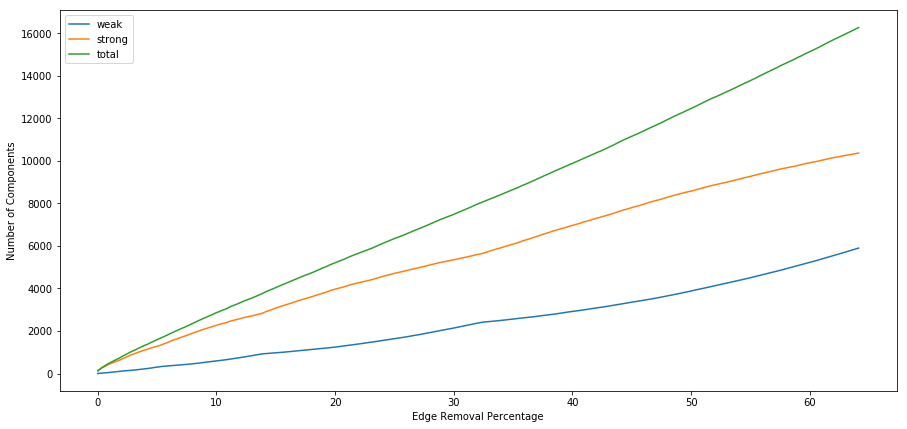

In [100]:
res_test("complete_networld_cap.edgelist", runs=5, redistribute=True)